# 4rd p30/50 PCA1/1 Crop.7 Affine.7 + Toe HPLv3 

## 改回 annotation_1345_good.csv
## heel保持 HPLv2
annotation_1307_HPLv2Toe_Good.csv

# 20210303-085343

# 101 Course of transfer learning and Fine tune 2021-01-01

## [How-to] 1. k-fold for cross validation

#### Create a simple k-fold for train classification model.

* In this short course you learned:

* data pipline

* transfer learning

* fine tune

* callbacks


todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


In [3]:
from pytictoc import TicToc

t_timer = TicToc() #create instance of class

t_timer.tic() #Start timer

### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# CSVNAME = ""


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# data-train # # current best dataset.1424-79.
ann = 'annotation_1345_good.csv'
im_p = 'train/images/'
CSVNAME = "K1345K10L195"

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train-HPL-1123
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'
# CSVNAME = ""

# # data-train # # HPLv2Toe
# ann = 'annotation_1307_HPLv2Toe_Good.csv'
# im_p = 'train/images/'
# CSVNAME = "HPLv2toeK10L195"


df = pd.read_csv(ann)
df[1120:]

images  x1   y1  x2   y2
1120  image_6195.jpg  52  127  75  370
1121  image_6196.jpg  62  138  29  383
1122  image_6197.jpg  54  135  78  380
1123  image_6198.jpg  60  125  29  384
1124  image_6199.jpg  51  147  70  353
...              ...  ..  ...  ..  ...
1340  image_6419.jpg  60  135  70  381
1341  image_6421.jpg  53  157  76  376
1342  image_6422.jpg  49  154  33  375
1343  image_6423.jpg  64  149  76  381
1344  image_6424.jpg  55  147  36  385

[225 rows x 5 columns]

In [8]:
len(df)

1345

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

images  x1   y1  x2   y2
0  image_0720.png  69  118  78  384
1  image_0031.png  44  107  80  367
2  image_6259.jpg  63  157  71  380
3  image_0234.png  54  117  76  369
4  image_0570.jpg  49  127  66  348
5  image_6204.jpg  41  118  33  365
6  image_0102.png  60  136  24  383
7  image_0605.jpg  60  136  17  381
8  image_6265.jpg  52  150  79  363
9  image_6056.png  55  153  30  383

See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1345

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_0720.png' 69 118 78 384
take sample: b'image_0031.png' 44 107 80 367
take sample: b'image_6259.jpg' 63 157 71 380
take sample: b'image_0234.png' 54 117 76 369
take sample: b'image_0570.jpg' 49 127 66 348


In [15]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0570.jpg


In [16]:
len(list_ds)

1345

#### Check ds iterator for consuming

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_0720.png' 69 118
b'image_0031.png' 44 107
b'image_6259.jpg' 63 157
b'image_0234.png' 54 117


In [19]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_0720.png' 69 118 78 384
b'image_0720.png' 69 118 78 384
b'image_0720.png' 69 118 78 384
b'image_0720.png' 69 118 78 384
===== Create iterator once and pull out to above cell. =====
b'image_0720.png' 69 118 78 384
b'image_0031.png' 44 107 80 367
b'image_6259.jpg' 63 157 71 380
b'image_0234.png' 54 117 76 369


#### Process path to image tensor in DS

In [20]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [21]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [22]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 69 38
f <dtype: 'string'>
x <dtype: 'int64'>


In [23]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=69>

In [24]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

[2021-02-23] New k-split ds

In [25]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(f'whole samples = {len(train_ds_map_toe)}')
# print(f'val_size = {val_size}')

# print('ds_train = ', tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print('ds_valid = ', tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [26]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

In [27]:
# ## testing cell
# kf = []
# for k in range(5):
#     kf.append(train_ds_map_heel.shard(num_shards=5, index=k))
#     print("k =", k,"num=", tf.data.experimental.cardinality(kf[k]).numpy())

In [28]:
# kf

In [29]:

# for img, [x,y] in kf[1].take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# print('y', y.dtype)

In [30]:
# ## testing cell

# range_k_0 = train_ds_map_heel.window(5)

# print(len(range_k_0))
# print(tf.data.experimental.cardinality(range_k_0).numpy())

In [31]:
# ## testing cell

# def get_train_valid_k_split():
#     x = tf.data.Dataset.range(1000)
#     val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    
#     for k in range(5):
#         train_num = x.take(val_size + k*val_size)
#         valid_num = x.skip(k*val_size)
        
#         print("k=", k)
#         print(tf.data.experimental.cardinality(train_num).numpy())
#         print(tf.data.experimental.cardinality(valid_num).numpy())
    
    
# get_train_valid_k_split()

In [32]:
## testing cell

# 
# tf.slice
# tf.data.experimental.choose_from_datasets


# x = list_ds
# val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.2)
x = tf.data.Dataset.range(10)

def check_KFold_ds(x, K=5):
    
    val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    print("val_size=", val_size)
    
    for k in range(K):
#         k_train = x.take(val_size + k*val_size)
#         k_valid = x.skip(k*val_size)
#         k_train = tf.slice(x, k*val_size, val_size) #only for pure tensors not 
#         k_valid = x.skip(k*val_size)

        # may skip twicce to performe kflod
        t_take = x.take(k*val_size)
        t_skip = x.skip(k*val_size+val_size)
        k_train = t_take.concatenate(t_skip)
        
        v_skip = x.skip(k*val_size)
        k_valid = v_skip.take(val_size)

        print("k =", k,"k*val_size+val_size", k*val_size+val_size, "k_train num=", tf.data.experimental.cardinality(k_train).numpy())


        # x = tf.data.Dataset.range(10)
#         for n in k_train:
#             print(n.numpy())
#         for n in k_valid:
#             print(n.numpy())
        
        # list_ds
#         for img, x1, y1, x2, y2 in k_train:
#             print(x1, y1)

        # train_ds_map_toe
#         for img, (x, y) in k_train:
#             print(x.numpy(), y.numpy())

    
    
    
check_KFold_ds(x)
# check_KFold_ds(list_ds)    
# check_KFold_ds(train_ds_map_toe)

val_size= 2
k = 0 k*val_size+val_size 2 k_train num= 8
k = 1 k*val_size+val_size 4 k_train num= 8
k = 2 k*val_size+val_size 6 k_train num= 8
k = 3 k*val_size+val_size 8 k_train num= 8
k = 4 k*val_size+val_size 10 k_train num= 8


In [33]:
# x = tf.data.Dataset.range(10)
# val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
# print("val_size=", val_size)

def get_KFold_ds(x, K=0):
        
    k = K
    # may skip twicce to perform kflod
    # train ds
    t_take = x.take(k*val_size)
    t_skip = x.skip(k*val_size+val_size)
    k_train = t_take.concatenate(t_skip)
    # val ds
    v_skip = x.skip(k*val_size)
    k_valid = v_skip.take(val_size)

    return k_train, k_valid

In [34]:
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)
t, v = get_KFold_ds(train_ds_map_toe, 1)

print(tf.data.experimental.cardinality(t).numpy())
print(tf.data.experimental.cardinality(v).numpy())

# for n in v:
#     print(n.numpy())

1211
134


In [35]:
train_ds_map_toe

<ParallelMapDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

In [36]:
v

<TakeDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

# Albumentation pipeline

In [37]:

# # for NO keypoint augment
# transforms = A.Compose([
# #             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
# #             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
    
#             # try other augm, seems to strong...
#             A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
#             A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True),
#             A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.8, 1.5), per_channel=False, elementwise=False),
#             A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.25),

# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label




# # Testing keypoints augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=1),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.HorizontalFlip(p=0.5),
#             ]
#             , 
#             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )





# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1.0),
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.9, 0.99), ratio=(1.0, 1.0), interpolation=0, p=0.7),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine(scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
    #2021-02-26
#             A.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),#fallout image make train stop. NOT support keypoints!!!!!
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 








###  for AToe ###
# some pp will outside of image bcs p2 is close to 400.



# Testing keypoints augment
transforms_AToe = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    
            A.HorizontalFlip(p=0.5),
#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


# Testing keypoints augment
# @tf.function
def aug_fn_AToe(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms_AToe(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data_AToe(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn_AToe, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 




def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [38]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


def configure_for_performance_cache_train_AToe(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data_AToe, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds





# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [39]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [40]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
# valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# # Heel ds_pre
# train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

#### Check ds_prefetch samples

In [41]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

In [42]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')


In [43]:
# # create it_ds once
# it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

In [44]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_heel_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')

In [45]:
# # create it_ds once
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

In [46]:
# %%time

# # for albu keypoint

# # for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)

# plt.figure(figsize=(8, 8))
# # for images, labels in valid_ds_pre_toe_s.take(1):
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')
        

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [47]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [48]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [49]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [50]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [51]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [52]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [53]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [54]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [55]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [56]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [57]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [58]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [59]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [60]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [61]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [62]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

# EFNE Training

maybe mae better than ed loss?

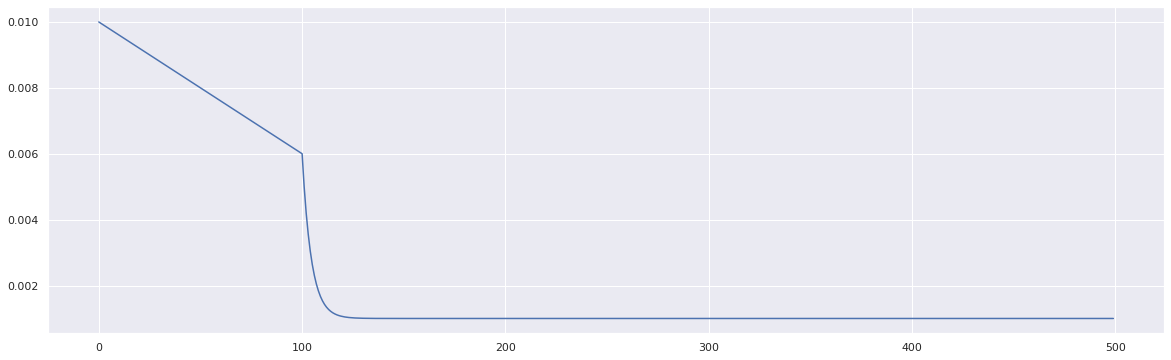

In [63]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [64]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [65]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

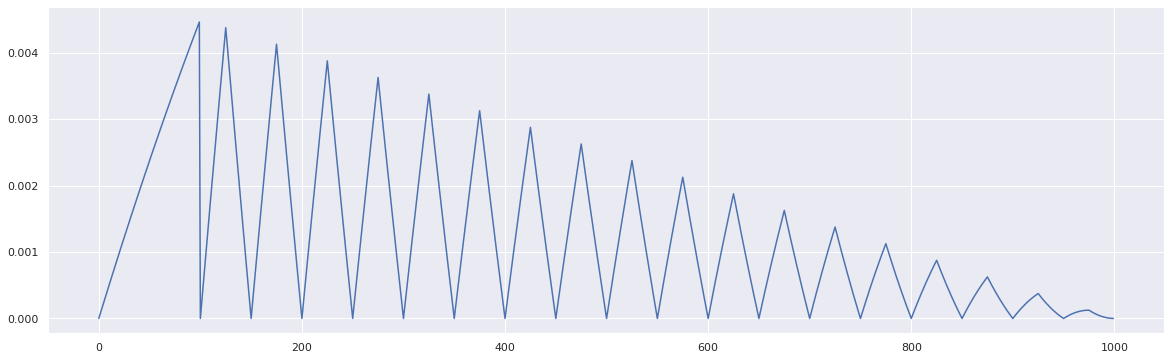

In [66]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [67]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [68]:
# 2.4999999999999966e-08 ~ 0.004459954505 1e-2~1e-6 

In [69]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUp(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-2 # currently best for foot pp
#     base_lr = 1e-8# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-2
#     first_decay_steps = 100


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUp(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

In [70]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUpLSW(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-3 # currently best for foot pp
#     base_lr = 1e-6# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 20
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-3
#     first_decay_steps = 50


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch-lr_ramp_ep)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

CPU times: user 611 ms, sys: 48.8 ms, total: 659 ms
Wall time: 553 ms


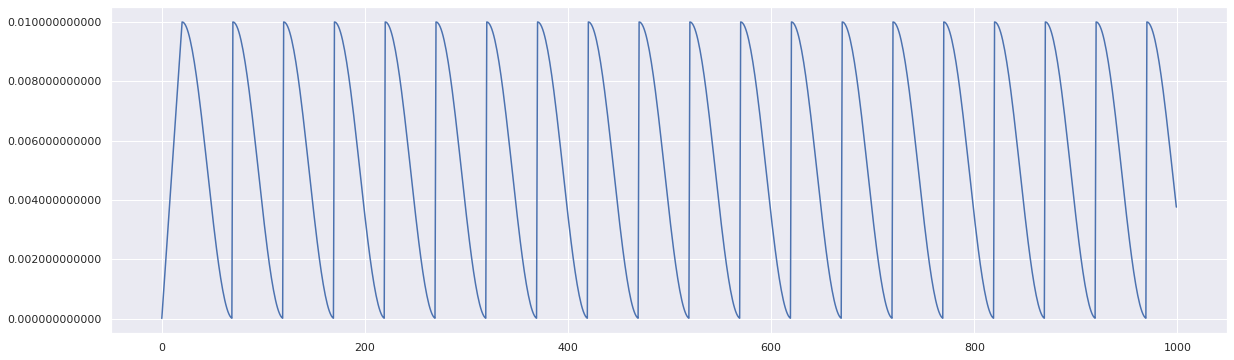

In [71]:
%%time
"""
cosine_decay_restarts是cosine_decay的cycle版本。
first_decay_steps是指第一次完全下降的step數，
t_mul是指每一次循環的步數都將乘以t_mul倍，
m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
alpha
"""

from matplotlib.ticker import FormatStrFormatter



ep_num = 1000



def CosineDecayCLRWarmUpLSW_2(epoch):
    
    #step_size = 25 # currently best for foot pp
    max_lr = 1e-2 # currently best for foot pp
    base_lr = 1e-6# 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 20
    lr_sus_ep  = 0
    #lr_decay   = 0.8


    initial_learning_rate = 1e-2
    first_decay_steps = 50


    lr_decayed_fn = (
      tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1,
          m_mul=1,
          alpha = 0.000001,
          name="CCosineDecayRestarts"))
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
    else:
        lr = lr_decayed_fn(epoch-lr_ramp_ep)
    return lr



rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW_2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)

In [72]:
print('{} ~ {}'.format(min(y), max(y)))

1e-06 ~ 0.009999999776482582


In [73]:
# 1.8774175103430935e-08 ~ 0.0010000000474974513 1e-3 1e-6

In [74]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [75]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [76]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [77]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [78]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [79]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [80]:
model_name = 'EfficientNetB0'

In [81]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th, K):
    return './' + log_dir_name + '/' + th + '_K' + K + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# # th = 'heel'

# # print(get_best_model_name(th,K))

# best_model_name = get_best_model_name(th, K)


# best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name:', best_model_name)

In [82]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     PrintLRtoe()
# ]

In [84]:
# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [85]:
# """Supervised pre-training 減少每次fold都要重新train的時間
# 只先改toe"""

# # Transfer learning from pre-trained weights
# def load_pretrained_efn_model():
#     pre_model_toe_name = "20210224-200728/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5"
#     model = tf.keras.models.load_model(pre_model_toe_name,compile=False)

#     # Freeze the pretrained weights
#     model.trainable = False
# #     print("base_model.trainable : ", base_model.trainable)

# #     # Rebuild top
# #     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# #     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
# #     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
# #     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

# #     # Compile new model
# #     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 4 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             print('layer trainable +1', layer.name)
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model

In [86]:
def unfreeze_model(model):
#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166  block3a_expand_conv 195
#
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block3a_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [87]:
# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2
# with strategy.scope():
#     model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [88]:
# len(model_toe.layers)

In [89]:
# tt = 0
# nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

In [90]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [91]:
# count_model_trainOrNot_layers(model_toe)

In [92]:
# model_toe.summary()

In [93]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre_toe_s, 
#                       verbose=1, 
#                       epochs=ep_num_transf, 
#                       validation_data=valid_ds_pre_toe_s, 
#                       callbacks=callbacks)#, validation_split=0.1)

# K-Fold Training

2021-02-23 v1

### Toe K-model

In [94]:
%%time

# big K = 5 (fold 0 ~ 4) 
KFlodNum = 10



history_toe = []
history_toe_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("\n \n K = ", k, "\n")
    # Toe split
    train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
    # Toe ds_pre
    train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
    valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
#     # heel split
#     train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
#     # Heel ds_pre
#     train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
#     valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    th = 'toe'
    # th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_toe_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_toe_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRtoe()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
#         model_toe = load_pretrained_efn_model() # from 20210224-200728 ed5.3
#         count_model_trainOrNot_layers(model_toe)
        
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_tl)#, validation_split=0.1)
    history_toe.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_toe)
    count_model_trainOrNot_layers(model_toe)
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_fn)#, validation_split=0.1)
    history_toe_finetune.append(hist)



 
 K =  0 

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210303-085343/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens


[20210303-0855-40] Learning rate for epoch 17 is 0.009359999559819698
Epoch 17/500
17/19 [=========================>....] - ETA: 0s - loss: 14.6577
Epoch 00017: val_loss did not improve from 11.19868
19/19 [==============================] - 0s 21ms/step - loss: 14.5955 - val_loss: 11.8121

[20210303-0855-45] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
16/19 [========================>.....] - ETA: 0s - loss: 15.3062
Epoch 00018: val_loss did not improve from 11.19868
19/19 [==============================] - 0s 22ms/step - loss: 15.1500 - val_loss: 11.4158

[20210303-0855-50] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
18/19 [===========================>..] - ETA: 0s - loss: 14.6545
Epoch 00019: val_loss did not improve from 11.19868
19/19 [==============================] - 0s 21ms/step - loss: 14.5959 - val_loss: 11.5324

[20210303-0855-55] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
19/19 [==============================] - ET


[20210303-0857-55] Learning rate for epoch 44 is 0.00827999971807003
Epoch 44/500
16/19 [========================>.....] - ETA: 0s - loss: 13.4827
Epoch 00044: val_loss did not improve from 10.60534
19/19 [==============================] - 0s 23ms/step - loss: 13.5458 - val_loss: 10.9407

[20210303-0858-00] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
16/19 [========================>.....] - ETA: 0s - loss: 13.7057
Epoch 00045: val_loss did not improve from 10.60534
19/19 [==============================] - 0s 22ms/step - loss: 13.6494 - val_loss: 10.8182

[20210303-0858-05] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
19/19 [==============================] - ETA: 0s - loss: 13.7167
Epoch 00046: val_loss did not improve from 10.60534
19/19 [==============================] - 0s 23ms/step - loss: 13.7167 - val_loss: 11.0228

[20210303-0858-09] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
16/19 [========================>.....] - ETA: 0

19/19 [==============================] - ETA: 0s - loss: 13.9795
Epoch 00004: val_loss did not improve from 10.51463
19/19 [==============================] - 1s 66ms/step - loss: 13.9795 - val_loss: 10.7773

[20210303-0901-34] Learning rate for epoch 5 is 0.0001996780774788931
Epoch 5/1000
19/19 [==============================] - ETA: 0s - loss: 13.0441
Epoch 00005: val_loss did not improve from 10.51463
19/19 [==============================] - 1s 69ms/step - loss: 13.0441 - val_loss: 11.4916

[20210303-0901-40] Learning rate for epoch 6 is 0.000249222619459033
Epoch 6/1000
19/19 [==============================] - ETA: 0s - loss: 12.2138
Epoch 00006: val_loss did not improve from 10.51463
19/19 [==============================] - 1s 65ms/step - loss: 12.2138 - val_loss: 11.4086

[20210303-0901-46] Learning rate for epoch 7 is 0.0002986671752296388
Epoch 7/1000
19/19 [==============================] - ETA: 0s - loss: 12.3290
Epoch 00007: val_loss improved from 10.51463 to 9.72335, saving

19/19 [==============================] - ETA: 0s - loss: 9.2469
Epoch 00030: val_loss did not improve from 8.03941
19/19 [==============================] - 1s 63ms/step - loss: 9.2469 - val_loss: 8.5359

[20210303-0904-09] Learning rate for epoch 31 is 0.0014553394867107272
Epoch 31/1000
19/19 [==============================] - ETA: 0s - loss: 9.0462
Epoch 00031: val_loss did not improve from 8.03941
19/19 [==============================] - 1s 68ms/step - loss: 9.0462 - val_loss: 9.6248

[20210303-0904-15] Learning rate for epoch 32 is 0.0015022843144834042
Epoch 32/1000
19/19 [==============================] - ETA: 0s - loss: 8.7744
Epoch 00032: val_loss did not improve from 8.03941
19/19 [==============================] - 1s 66ms/step - loss: 8.7744 - val_loss: 8.5042

[20210303-0904-20] Learning rate for epoch 33 is 0.0015491291414946318
Epoch 33/1000
19/19 [==============================] - ETA: 0s - loss: 8.8615
Epoch 00033: val_loss did not improve from 8.03941
19/19 [===========

19/19 [==============================] - ETA: 0s - loss: 8.0021
Epoch 00058: val_loss did not improve from 6.77393
19/19 [==============================] - 1s 66ms/step - loss: 8.0021 - val_loss: 7.1040

[20210303-0906-52] Learning rate for epoch 59 is 0.0027319977525621653
Epoch 59/1000
19/19 [==============================] - ETA: 0s - loss: 7.8470
Epoch 00059: val_loss did not improve from 6.77393
19/19 [==============================] - 1s 64ms/step - loss: 7.8470 - val_loss: 7.1582

[20210303-0906-58] Learning rate for epoch 60 is 0.0027761429082602262
Epoch 60/1000
19/19 [==============================] - ETA: 0s - loss: 7.7896
Epoch 00060: val_loss did not improve from 6.77393
19/19 [==============================] - 1s 66ms/step - loss: 7.7896 - val_loss: 8.9689

[20210303-0907-04] Learning rate for epoch 61 is 0.002820187946781516
Epoch 61/1000
19/19 [==============================] - ETA: 0s - loss: 7.9029
Epoch 00061: val_loss did not improve from 6.77393
19/19 [============


[20210303-0909-30] Learning rate for epoch 86 is 0.0038888186682015657
Epoch 86/1000
19/19 [==============================] - ETA: 0s - loss: 7.2065
Epoch 00086: val_loss did not improve from 6.31791
19/19 [==============================] - 1s 67ms/step - loss: 7.2065 - val_loss: 6.3670

[20210303-0909-36] Learning rate for epoch 87 is 0.00393026415258646
Epoch 87/1000
19/19 [==============================] - ETA: 0s - loss: 7.4391
Epoch 00087: val_loss improved from 6.31791 to 6.08473, saving model to ./20210303-085343/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 98ms/step - loss: 7.4391 - val_loss: 6.0847

[20210303-0909-42] Learning rate for epoch 88 is 0.00397160928696394
Epoch 88/1000
19/19 [==============================] - ETA: 0s - loss: 7.6087
Epoch 00088: val_loss did not improve from 6.08473
19/19 [==============================] - 1s 63ms/step - loss: 7.6087 - val_loss: 7.0142

[20210303-0909-48] Learning rate for epoch 89 is

19/19 [==============================] - ETA: 0s - loss: 6.7714
Epoch 00112: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 66ms/step - loss: 6.7714 - val_loss: 6.4017

[20210303-0912-11] Learning rate for epoch 113 is 0.002131430897861719
Epoch 113/1000
19/19 [==============================] - ETA: 0s - loss: 6.8243
Epoch 00113: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 67ms/step - loss: 6.8243 - val_loss: 6.0310

[20210303-0912-17] Learning rate for epoch 114 is 0.0023064129054546356
Epoch 114/1000
19/19 [==============================] - ETA: 0s - loss: 6.8617
Epoch 00114: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 69ms/step - loss: 6.8617 - val_loss: 6.1966

[20210303-0912-23] Learning rate for epoch 115 is 0.0024809949100017548
Epoch 115/1000
19/19 [==============================] - ETA: 0s - loss: 7.0419
Epoch 00115: val_loss did not improve from 5.78854
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 6.3705
Epoch 00140: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 69ms/step - loss: 6.3705 - val_loss: 6.4342

[20210303-0914-54] Learning rate for epoch 141 is 0.0017202580347657204
Epoch 141/1000
19/19 [==============================] - ETA: 0s - loss: 6.8170
Epoch 00141: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 65ms/step - loss: 6.8170 - val_loss: 6.3602

[20210303-0915-00] Learning rate for epoch 142 is 0.0015464748721569777
Epoch 142/1000
19/19 [==============================] - ETA: 0s - loss: 6.6602
Epoch 00142: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 66ms/step - loss: 6.6602 - val_loss: 6.4609

[20210303-0915-06] Learning rate for epoch 143 is 0.0013730917125940323
Epoch 143/1000
19/19 [==============================] - ETA: 0s - loss: 6.6481
Epoch 00143: val_loss did not improve from 5.78854
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.4737
Epoch 00168: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 65ms/step - loss: 6.4737 - val_loss: 6.6325

[20210303-0917-37] Learning rate for epoch 169 is 0.002995316404849291
Epoch 169/1000
19/19 [==============================] - ETA: 0s - loss: 6.4359
Epoch 00169: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 64ms/step - loss: 6.4359 - val_loss: 6.5925

[20210303-0917-43] Learning rate for epoch 170 is 0.0031578997150063515
Epoch 170/1000
19/19 [==============================] - ETA: 0s - loss: 6.3946
Epoch 00170: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 67ms/step - loss: 6.3946 - val_loss: 6.4885

[20210303-0917-49] Learning rate for epoch 171 is 0.0033200830221176147
Epoch 171/1000
19/19 [==============================] - ETA: 0s - loss: 6.6070
Epoch 00171: val_loss did not improve from 5.78854
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 6.0635
Epoch 00196: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 65ms/step - loss: 6.0635 - val_loss: 6.1465

[20210303-0920-20] Learning rate for epoch 197 is 0.0006435376708395779
Epoch 197/1000
19/19 [==============================] - ETA: 0s - loss: 5.8971
Epoch 00197: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 67ms/step - loss: 5.8971 - val_loss: 6.0877

[20210303-0920-26] Learning rate for epoch 198 is 0.0004821533220820129
Epoch 198/1000
19/19 [==============================] - ETA: 0s - loss: 5.8409
Epoch 00198: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 69ms/step - loss: 5.8409 - val_loss: 6.0292

[20210303-0920-32] Learning rate for epoch 199 is 0.0003211689181625843
Epoch 199/1000
19/19 [==============================] - ETA: 0s - loss: 6.0520
Epoch 00199: val_loss did not improve from 5.78854
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.5393
Epoch 00224: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 66ms/step - loss: 6.5393 - val_loss: 6.3290

[20210303-0923-02] Learning rate for epoch 225 is 0.003724815556779504
Epoch 225/1000
19/19 [==============================] - ETA: 0s - loss: 6.4698
Epoch 00225: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 63ms/step - loss: 6.4698 - val_loss: 6.1500

[20210303-0923-08] Learning rate for epoch 226 is 0.003874999936670065
Epoch 226/1000
19/19 [==============================] - ETA: 0s - loss: 6.5543
Epoch 00226: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 68ms/step - loss: 6.5543 - val_loss: 6.8295

[20210303-0923-14] Learning rate for epoch 227 is 0.0037152154836803675
Epoch 227/1000
19/19 [==============================] - ETA: 0s - loss: 6.3791
Epoch 00227: val_loss did not improve from 5.78854
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.6782
Epoch 00252: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 68ms/step - loss: 5.6782 - val_loss: 6.0567

[20210303-0925-44] Learning rate for epoch 253 is 0.0002995440736413002
Epoch 253/1000
19/19 [==============================] - ETA: 0s - loss: 5.8438
Epoch 00253: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 65ms/step - loss: 5.8438 - val_loss: 6.0929

[20210303-0925-49] Learning rate for epoch 254 is 0.0004485286772251129
Epoch 254/1000
19/19 [==============================] - ETA: 0s - loss: 5.8137
Epoch 00254: val_loss did not improve from 5.78854
19/19 [==============================] - 1s 65ms/step - loss: 5.8137 - val_loss: 6.1778

[20210303-0925-55] Learning rate for epoch 255 is 0.0005971133359707892
Epoch 255/1000
19/19 [==============================] - ETA: 0s - loss: 5.7308
Epoch 00255: val_loss did not improve from 5.78854
19/19 [=====

19/19 [==============================] - 1s 42ms/step - loss: 14.5509 - val_loss: 10.2154

[20210303-0927-59] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
19/19 [==============================] - ETA: 0s - loss: 14.3532
Epoch 00018: val_loss did not improve from 10.21535
19/19 [==============================] - 0s 22ms/step - loss: 14.3532 - val_loss: 10.2349

[20210303-0928-04] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
19/19 [==============================] - ETA: 0s - loss: 14.4199
Epoch 00019: val_loss improved from 10.21535 to 9.94778, saving model to ./20210303-085343/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 14.4199 - val_loss: 9.9478

[20210303-0928-09] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 14.6535
Epoch 00020: val_loss did not improve from 9.94778
19/19 [==============================] - 


[20210303-0930-09] Learning rate for epoch 44 is 0.00827999971807003
Epoch 44/500
17/19 [=========================>....] - ETA: 0s - loss: 13.8477
Epoch 00044: val_loss did not improve from 9.64090
19/19 [==============================] - 0s 22ms/step - loss: 13.7947 - val_loss: 9.7583

[20210303-0930-15] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
17/19 [=========================>....] - ETA: 0s - loss: 13.6139
Epoch 00045: val_loss did not improve from 9.64090
19/19 [==============================] - 0s 23ms/step - loss: 13.6958 - val_loss: 9.7504

[20210303-0930-20] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
17/19 [=========================>....] - ETA: 0s - loss: 13.5960
Epoch 00046: val_loss did not improve from 9.64090
19/19 [==============================] - 0s 22ms/step - loss: 13.5841 - val_loss: 9.8462

[20210303-0930-24] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
16/19 [========================>.....] - ETA: 0s - lo


[20210303-0932-28] Learning rate for epoch 72 is 0.007160000037401915
Epoch 72/500
19/19 [==============================] - ETA: 0s - loss: 13.5708
Epoch 00072: val_loss did not improve from 9.61222
19/19 [==============================] - 0s 22ms/step - loss: 13.5708 - val_loss: 9.6386

[20210303-0932-33] Learning rate for epoch 73 is 0.007120000198483467
Epoch 73/500
19/19 [==============================] - ETA: 0s - loss: 13.4291
Epoch 00073: val_loss did not improve from 9.61222
19/19 [==============================] - 0s 21ms/step - loss: 13.4291 - val_loss: 9.7526

[20210303-0932-38] Learning rate for epoch 74 is 0.007079999893903732
Epoch 74/500
19/19 [==============================] - ETA: 0s - loss: 13.7331
Epoch 00074: val_loss did not improve from 9.61222
19/19 [==============================] - 0s 22ms/step - loss: 13.7331 - val_loss: 9.8387

[20210303-0932-43] Learning rate for epoch 75 is 0.007040000054985285
Epoch 75/500
18/19 [===========================>..] - ETA: 0s 

17/19 [=========================>....] - ETA: 0s - loss: 13.1788
Epoch 00099: val_loss improved from 9.45747 to 9.44464, saving model to ./20210303-085343/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 13.0877 - val_loss: 9.4446

[20210303-0934-48] Learning rate for epoch 100 is 0.006039999891072512
Epoch 100/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1481
Epoch 00100: val_loss did not improve from 9.44464
19/19 [==============================] - 0s 22ms/step - loss: 13.1386 - val_loss: 9.4594

[20210303-0934-53] Learning rate for epoch 101 is 0.006000000052154064
Epoch 101/500
19/19 [==============================] - ETA: 0s - loss: 13.1703
Epoch 00101: val_loss did not improve from 9.44464
19/19 [==============================] - 0s 22ms/step - loss: 13.1703 - val_loss: 9.5753

[20210303-0934-58] Learning rate for epoch 102 is 0.004999999888241291
Epoch 102/500
18/19 [===========================>..] 

17/19 [=========================>....] - ETA: 0s - loss: 12.8131
Epoch 00127: val_loss did not improve from 9.44464
19/19 [==============================] - 0s 22ms/step - loss: 12.9046 - val_loss: 9.5296

[20210303-0937-05] Learning rate for epoch 128 is 0.0010120893130078912
Epoch 128/500
17/19 [=========================>....] - ETA: 0s - loss: 13.0532
Epoch 00128: val_loss did not improve from 9.44464
19/19 [==============================] - 0s 22ms/step - loss: 13.0536 - val_loss: 9.4958

[20210303-0937-09] Learning rate for epoch 129 is 0.0010096713667735457
Epoch 129/500
19/19 [==============================] - ETA: 0s - loss: 13.0013
Epoch 00129: val_loss did not improve from 9.44464
19/19 [==============================] - 0s 23ms/step - loss: 13.0013 - val_loss: 9.5251

*********************************** Start fine tune ***********************************
tt: 195, nt:46, total layers:241
*********************************** Start fine tune ***********************************



19/19 [==============================] - ETA: 0s - loss: 9.5946
Epoch 00024: val_loss did not improve from 6.76944
19/19 [==============================] - 1s 64ms/step - loss: 9.5946 - val_loss: 7.1800

[20210303-0940-25] Learning rate for epoch 25 is 0.001171570853330195
Epoch 25/1000
19/19 [==============================] - ETA: 0s - loss: 9.3426
Epoch 00025: val_loss improved from 6.76944 to 6.51510, saving model to ./20210303-085343/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 94ms/step - loss: 9.3426 - val_loss: 6.5151

[20210303-0940-32] Learning rate for epoch 26 is 0.001219115569256246
Epoch 26/1000
19/19 [==============================] - ETA: 0s - loss: 9.3537
Epoch 00026: val_loss did not improve from 6.51510
19/19 [==============================] - 1s 69ms/step - loss: 9.3537 - val_loss: 7.5053

[20210303-0940-37] Learning rate for epoch 27 is 0.0012665604008361697
Epoch 27/1000
19/19 [==============================] - ETA: 0

19/19 [==============================] - ETA: 0s - loss: 7.6884
Epoch 00052: val_loss did not improve from 5.88298
19/19 [==============================] - 1s 67ms/step - loss: 7.6884 - val_loss: 6.0532

[20210303-0943-07] Learning rate for epoch 53 is 0.002465027617290616
Epoch 53/1000
19/19 [==============================] - ETA: 0s - loss: 7.8015
Epoch 00053: val_loss did not improve from 5.88298
19/19 [==============================] - 1s 65ms/step - loss: 7.8015 - val_loss: 7.0377

[20210303-0943-13] Learning rate for epoch 54 is 0.0025097725447267294
Epoch 54/1000
19/19 [==============================] - ETA: 0s - loss: 7.9461
Epoch 00054: val_loss did not improve from 5.88298
19/19 [==============================] - 1s 65ms/step - loss: 7.9461 - val_loss: 7.1627

[20210303-0943-19] Learning rate for epoch 55 is 0.0025544175878167152
Epoch 55/1000
19/19 [==============================] - ETA: 0s - loss: 7.9736
Epoch 00055: val_loss improved from 5.88298 to 5.63033, saving model t

19/19 [==============================] - ETA: 0s - loss: 7.0708
Epoch 00080: val_loss did not improve from 5.24184
19/19 [==============================] - 1s 67ms/step - loss: 7.0708 - val_loss: 6.4824

[20210303-0945-50] Learning rate for epoch 81 is 0.0036800920497626066
Epoch 81/1000
19/19 [==============================] - ETA: 0s - loss: 7.4210
Epoch 00081: val_loss did not improve from 5.24184
19/19 [==============================] - 1s 68ms/step - loss: 7.4210 - val_loss: 6.4560

[20210303-0945-56] Learning rate for epoch 82 is 0.003722037188708782
Epoch 82/1000
19/19 [==============================] - ETA: 0s - loss: 7.5464
Epoch 00082: val_loss did not improve from 5.24184
19/19 [==============================] - 1s 66ms/step - loss: 7.5464 - val_loss: 6.5379

[20210303-0946-02] Learning rate for epoch 83 is 0.003763882676139474
Epoch 83/1000
19/19 [==============================] - ETA: 0s - loss: 7.4969
Epoch 00083: val_loss did not improve from 5.24184
19/19 [=============

19/19 [==============================] - ETA: 0s - loss: 6.6858
Epoch 00108: val_loss did not improve from 5.14669
19/19 [==============================] - 1s 64ms/step - loss: 6.6858 - val_loss: 5.2760

[20210303-0948-32] Learning rate for epoch 109 is 0.001427503302693367
Epoch 109/1000
19/19 [==============================] - ETA: 0s - loss: 6.6621
Epoch 00109: val_loss did not improve from 5.14669
19/19 [==============================] - 1s 64ms/step - loss: 6.6621 - val_loss: 5.2847

[20210303-0948-38] Learning rate for epoch 110 is 0.0016040850896388292
Epoch 110/1000
19/19 [==============================] - ETA: 0s - loss: 6.7539
Epoch 00110: val_loss did not improve from 5.14669
19/19 [==============================] - 1s 67ms/step - loss: 6.7539 - val_loss: 5.1554

[20210303-0948-44] Learning rate for epoch 111 is 0.001780266989953816
Epoch 111/1000
19/19 [==============================] - ETA: 0s - loss: 6.6608
Epoch 00111: val_loss did not improve from 5.14669
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 6.9452
Epoch 00136: val_loss did not improve from 5.14669
19/19 [==============================] - 1s 68ms/step - loss: 6.9452 - val_loss: 5.8267

[20210303-0951-15] Learning rate for epoch 137 is 0.0024193900171667337
Epoch 137/1000
19/19 [==============================] - ETA: 0s - loss: 6.4707
Epoch 00137: val_loss did not improve from 5.14669
19/19 [==============================] - 1s 65ms/step - loss: 6.4707 - val_loss: 6.2007

[20210303-0951-21] Learning rate for epoch 138 is 0.0022440070752054453
Epoch 138/1000
19/19 [==============================] - ETA: 0s - loss: 6.6720
Epoch 00138: val_loss did not improve from 5.14669
19/19 [==============================] - 1s 66ms/step - loss: 6.6720 - val_loss: 5.9327

[20210303-0951-27] Learning rate for epoch 139 is 0.002069024136289954
Epoch 139/1000
19/19 [==============================] - ETA: 0s - loss: 6.5905
Epoch 00139: val_loss did not improve from 5.14669
19/19 [======


[20210303-0953-52] Learning rate for epoch 164 is 0.0021764009725302458
Epoch 164/1000
19/19 [==============================] - ETA: 0s - loss: 6.2096
Epoch 00164: val_loss did not improve from 4.98504
19/19 [==============================] - 1s 73ms/step - loss: 6.2096 - val_loss: 5.1679

[20210303-0953-58] Learning rate for epoch 165 is 0.002340983832255006
Epoch 165/1000
19/19 [==============================] - ETA: 0s - loss: 6.4004
Epoch 00165: val_loss did not improve from 4.98504
19/19 [==============================] - 1s 67ms/step - loss: 6.4004 - val_loss: 5.5444

[20210303-0954-04] Learning rate for epoch 166 is 0.002505166921764612
Epoch 166/1000
19/19 [==============================] - ETA: 0s - loss: 6.4393
Epoch 00166: val_loss did not improve from 4.98504
19/19 [==============================] - 1s 69ms/step - loss: 6.4393 - val_loss: 5.5245

[20210303-0954-10] Learning rate for epoch 167 is 0.002668950008228421
Epoch 167/1000
19/19 [==============================] - E

19/19 [==============================] - ETA: 0s - loss: 6.0856
Epoch 00192: val_loss did not improve from 4.98504
19/19 [==============================] - 1s 65ms/step - loss: 6.0856 - val_loss: 5.3254

[20210303-0956-42] Learning rate for epoch 193 is 0.001293074688874185
Epoch 193/1000
19/19 [==============================] - ETA: 0s - loss: 6.0613
Epoch 00193: val_loss did not improve from 4.98504
19/19 [==============================] - 1s 70ms/step - loss: 6.0613 - val_loss: 5.2822

[20210303-0956-48] Learning rate for epoch 194 is 0.0011300905607640743
Epoch 194/1000
19/19 [==============================] - ETA: 0s - loss: 6.1714
Epoch 00194: val_loss did not improve from 4.98504
19/19 [==============================] - 1s 69ms/step - loss: 6.1714 - val_loss: 5.1607

[20210303-0956-54] Learning rate for epoch 195 is 0.0009675062610767782
Epoch 195/1000
19/19 [==============================] - ETA: 0s - loss: 6.0827
Epoch 00195: val_loss improved from 4.98504 to 4.90357, saving m


[20210303-0959-20] Learning rate for epoch 220 is 0.002967893611639738
Epoch 220/1000
19/19 [==============================] - ETA: 0s - loss: 6.4560
Epoch 00220: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 67ms/step - loss: 6.4560 - val_loss: 6.4604

[20210303-0959-26] Learning rate for epoch 221 is 0.003120078006759286
Epoch 221/1000
19/19 [==============================] - ETA: 0s - loss: 6.3011
Epoch 00221: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 68ms/step - loss: 6.3011 - val_loss: 5.7977

[20210303-0959-32] Learning rate for epoch 222 is 0.0032718623988330364
Epoch 222/1000
19/19 [==============================] - ETA: 0s - loss: 6.3699
Epoch 00222: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 65ms/step - loss: 6.3699 - val_loss: 6.1903

[20210303-0959-38] Learning rate for epoch 223 is 0.0034232467878609896
Epoch 223/1000
19/19 [==============================] - 

19/19 [==============================] - ETA: 0s - loss: 5.7066
Epoch 00248: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 66ms/step - loss: 5.7066 - val_loss: 5.1566

[20210303-1002-09] Learning rate for epoch 249 is 0.00030114591936580837
Epoch 249/1000
19/19 [==============================] - ETA: 0s - loss: 5.8048
Epoch 00249: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 64ms/step - loss: 5.8048 - val_loss: 5.1556

[20210303-1002-14] Learning rate for epoch 250 is 0.00015056047413963825
Epoch 250/1000
19/19 [==============================] - ETA: 0s - loss: 5.6921
Epoch 00250: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 63ms/step - loss: 5.6921 - val_loss: 5.1702

[20210303-1002-20] Learning rate for epoch 251 is 3.7500001326407073e-07
Epoch 251/1000
19/19 [==============================] - ETA: 0s - loss: 5.6478
Epoch 00251: val_loss did not improve from 4.88351
19/19 [==

19/19 [==============================] - ETA: 0s - loss: 6.4213
Epoch 00276: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 67ms/step - loss: 6.4213 - val_loss: 5.8371

[20210303-1004-51] Learning rate for epoch 277 is 0.0034752145875245333
Epoch 277/1000
19/19 [==============================] - ETA: 0s - loss: 6.2364
Epoch 00277: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 71ms/step - loss: 6.2364 - val_loss: 6.4539

[20210303-1004-57] Learning rate for epoch 278 is 0.003325828816741705
Epoch 278/1000
19/19 [==============================] - ETA: 0s - loss: 6.1597
Epoch 00278: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 70ms/step - loss: 6.1597 - val_loss: 5.2678

[20210303-1005-03] Learning rate for epoch 279 is 0.0031768432818353176
Epoch 279/1000
19/19 [==============================] - ETA: 0s - loss: 6.2354
Epoch 00279: val_loss did not improve from 4.88351
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.4876
Epoch 00304: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 70ms/step - loss: 5.4876 - val_loss: 5.1819

[20210303-1007-36] Learning rate for epoch 305 is 0.0005570923094637692
Epoch 305/1000
19/19 [==============================] - ETA: 0s - loss: 5.6277
Epoch 00305: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 66ms/step - loss: 5.6277 - val_loss: 5.1227

[20210303-1007-41] Learning rate for epoch 306 is 0.0006952779949642718
Epoch 306/1000
19/19 [==============================] - ETA: 0s - loss: 5.4625
Epoch 00306: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 65ms/step - loss: 5.4625 - val_loss: 5.2415

[20210303-1007-47] Learning rate for epoch 307 is 0.0008330637356266379
Epoch 307/1000
19/19 [==============================] - ETA: 0s - loss: 5.7342
Epoch 00307: val_loss did not improve from 4.88351
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.7757
Epoch 00332: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 65ms/step - loss: 5.7757 - val_loss: 5.7298

[20210303-1010-19] Learning rate for epoch 333 is 0.0024048935156315565
Epoch 333/1000
19/19 [==============================] - ETA: 0s - loss: 5.9585
Epoch 00333: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 66ms/step - loss: 5.9585 - val_loss: 5.9302

[20210303-1010-25] Learning rate for epoch 334 is 0.0022679066751152277
Epoch 334/1000
19/19 [==============================] - ETA: 0s - loss: 5.8820
Epoch 00334: val_loss did not improve from 4.88351
19/19 [==============================] - 1s 68ms/step - loss: 5.8820 - val_loss: 5.9732

[20210303-1010-31] Learning rate for epoch 335 is 0.0021313198376446962
Epoch 335/1000
19/19 [==============================] - ETA: 0s - loss: 5.9729
Epoch 00335: val_loss did not improve from 4.88351
19/19 [=====


[20210303-1013-02] Learning rate for epoch 5 is 0.009840000420808792
Epoch 5/500
19/19 [==============================] - ETA: 0s - loss: 17.9077
Epoch 00005: val_loss improved from 11.39558 to 11.15272, saving model to ./20210303-085343/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 44ms/step - loss: 17.9077 - val_loss: 11.1527

[20210303-1013-07] Learning rate for epoch 6 is 0.009800000116229057
Epoch 6/500
17/19 [=========================>....] - ETA: 0s - loss: 18.1121
Epoch 00006: val_loss improved from 11.15272 to 10.89190, saving model to ./20210303-085343/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 18.1516 - val_loss: 10.8919

[20210303-1013-12] Learning rate for epoch 7 is 0.009759999811649323
Epoch 7/500
16/19 [========================>.....] - ETA: 0s - loss: 16.5897
Epoch 00007: val_loss did not improve from 10.89190
19/19 [==============================] - 0s 2

19/19 [==============================] - ETA: 0s - loss: 14.7583
Epoch 00029: val_loss did not improve from 9.75476
19/19 [==============================] - 0s 21ms/step - loss: 14.7583 - val_loss: 9.8334

[20210303-1015-10] Learning rate for epoch 30 is 0.008840000256896019
Epoch 30/500
19/19 [==============================] - ETA: 0s - loss: 14.0248
Epoch 00030: val_loss did not improve from 9.75476
19/19 [==============================] - 0s 23ms/step - loss: 14.0248 - val_loss: 9.8764

[20210303-1015-15] Learning rate for epoch 31 is 0.008799999952316284
Epoch 31/500
18/19 [===========================>..] - ETA: 0s - loss: 14.2862
Epoch 00031: val_loss did not improve from 9.75476
19/19 [==============================] - 0s 21ms/step - loss: 14.3374 - val_loss: 10.1542

[20210303-1015-20] Learning rate for epoch 32 is 0.00875999964773655
Epoch 32/500
19/19 [==============================] - ETA: 0s - loss: 14.1052
Epoch 00032: val_loss did not improve from 9.75476
19/19 [==========

16/19 [========================>.....] - ETA: 0s - loss: 13.8064
Epoch 00057: val_loss did not improve from 9.68408
19/19 [==============================] - 0s 23ms/step - loss: 13.9009 - val_loss: 9.6912

[20210303-1017-29] Learning rate for epoch 58 is 0.007720000110566616
Epoch 58/500
17/19 [=========================>....] - ETA: 0s - loss: 13.6153
Epoch 00058: val_loss did not improve from 9.68408
19/19 [==============================] - 0s 23ms/step - loss: 13.5704 - val_loss: 9.8189

[20210303-1017-34] Learning rate for epoch 59 is 0.007679999805986881
Epoch 59/500
19/19 [==============================] - ETA: 0s - loss: 13.8129
Epoch 00059: val_loss did not improve from 9.68408
19/19 [==============================] - 0s 24ms/step - loss: 13.8129 - val_loss: 9.8804

[20210303-1017-39] Learning rate for epoch 60 is 0.007639999967068434
Epoch 60/500
17/19 [=========================>....] - ETA: 0s - loss: 13.6300
Epoch 00060: val_loss did not improve from 9.68408
19/19 [==========

19/19 [==============================] - ETA: 0s - loss: 13.6407
Epoch 00085: val_loss did not improve from 9.59112
19/19 [==============================] - 0s 24ms/step - loss: 13.6407 - val_loss: 9.9962

[20210303-1019-49] Learning rate for epoch 86 is 0.006599999964237213
Epoch 86/500
19/19 [==============================] - ETA: 0s - loss: 13.6396
Epoch 00086: val_loss did not improve from 9.59112
19/19 [==============================] - 0s 23ms/step - loss: 13.6396 - val_loss: 9.8883

[20210303-1019-54] Learning rate for epoch 87 is 0.006560000125318766
Epoch 87/500
19/19 [==============================] - ETA: 0s - loss: 13.2731
Epoch 00087: val_loss did not improve from 9.59112
19/19 [==============================] - 0s 25ms/step - loss: 13.2731 - val_loss: 9.6144

[20210303-1020-00] Learning rate for epoch 88 is 0.006519999820739031
Epoch 88/500
19/19 [==============================] - ETA: 0s - loss: 13.7401
Epoch 00088: val_loss did not improve from 9.59112
19/19 [==========


[20210303-1022-57] Learning rate for epoch 12 is 0.0005443901172839105
Epoch 12/1000
19/19 [==============================] - ETA: 0s - loss: 10.7472
Epoch 00012: val_loss did not improve from 8.08146
19/19 [==============================] - 1s 70ms/step - loss: 10.7472 - val_loss: 8.7239

[20210303-1023-02] Learning rate for epoch 13 is 0.0005932347266934812
Epoch 13/1000
19/19 [==============================] - ETA: 0s - loss: 11.0133
Epoch 00013: val_loss improved from 8.08146 to 7.65932, saving model to ./20210303-085343/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 101ms/step - loss: 11.0133 - val_loss: 7.6593

[20210303-1023-09] Learning rate for epoch 14 is 0.0006419793353416026
Epoch 14/1000
19/19 [==============================] - ETA: 0s - loss: 10.6458
Epoch 00014: val_loss did not improve from 7.65932
19/19 [==============================] - 1s 69ms/step - loss: 10.6458 - val_loss: 7.7925

[20210303-1023-15] Learning rate for 

19/19 [==============================] - ETA: 0s - loss: 8.5788
Epoch 00038: val_loss did not improve from 6.18836
19/19 [==============================] - 1s 69ms/step - loss: 8.5788 - val_loss: 7.5241

[20210303-1025-40] Learning rate for epoch 39 is 0.0018280982039868832
Epoch 39/1000
19/19 [==============================] - ETA: 0s - loss: 8.3367
Epoch 00039: val_loss did not improve from 6.18836
19/19 [==============================] - 1s 70ms/step - loss: 8.3367 - val_loss: 6.9790

[20210303-1025-46] Learning rate for epoch 40 is 0.0018742431420832872
Epoch 40/1000
19/19 [==============================] - ETA: 0s - loss: 8.6699
Epoch 00040: val_loss did not improve from 6.18836
19/19 [==============================] - 1s 68ms/step - loss: 8.6699 - val_loss: 7.5714

[20210303-1025-51] Learning rate for epoch 41 is 0.0019202879630029202
Epoch 41/1000
19/19 [==============================] - ETA: 0s - loss: 8.3836
Epoch 00041: val_loss improved from 6.18836 to 6.02823, saving model 


[20210303-1028-22] Learning rate for epoch 66 is 0.0030389137100428343
Epoch 66/1000
19/19 [==============================] - ETA: 0s - loss: 7.5490
Epoch 00066: val_loss did not improve from 5.71900
19/19 [==============================] - 1s 73ms/step - loss: 7.5490 - val_loss: 7.3382

[20210303-1028-28] Learning rate for epoch 67 is 0.003082358743995428
Epoch 67/1000
19/19 [==============================] - ETA: 0s - loss: 7.8758
Epoch 00067: val_loss did not improve from 5.71900
19/19 [==============================] - 1s 71ms/step - loss: 7.8758 - val_loss: 6.3482

[20210303-1028-34] Learning rate for epoch 68 is 0.0031257038936018944
Epoch 68/1000
19/19 [==============================] - ETA: 0s - loss: 7.4763
Epoch 00068: val_loss did not improve from 5.71900
19/19 [==============================] - 1s 72ms/step - loss: 7.4763 - val_loss: 5.8420

[20210303-1028-39] Learning rate for epoch 69 is 0.003168949158862233
Epoch 69/1000
19/19 [==============================] - ETA: 0s 


[20210303-1031-10] Learning rate for epoch 94 is 0.004217581823468208
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 7.5003
Epoch 00094: val_loss did not improve from 5.43258
19/19 [==============================] - 1s 72ms/step - loss: 7.5003 - val_loss: 8.0955

[20210303-1031-16] Learning rate for epoch 95 is 0.004258227068930864
Epoch 95/1000
19/19 [==============================] - ETA: 0s - loss: 7.3957
Epoch 00095: val_loss did not improve from 5.43258
19/19 [==============================] - 1s 70ms/step - loss: 7.3957 - val_loss: 7.3662

[20210303-1031-22] Learning rate for epoch 96 is 0.0042987726628780365
Epoch 96/1000
19/19 [==============================] - ETA: 0s - loss: 7.1260
Epoch 00096: val_loss did not improve from 5.43258
19/19 [==============================] - 1s 70ms/step - loss: 7.1260 - val_loss: 7.6534

[20210303-1031-28] Learning rate for epoch 97 is 0.0043392181396484375
Epoch 97/1000
19/19 [==============================] - ETA: 0s 


[20210303-1033-58] Learning rate for epoch 122 is 0.003691870253533125
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 6.8835
Epoch 00122: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 71ms/step - loss: 6.8835 - val_loss: 6.0896

[20210303-1034-04] Learning rate for epoch 123 is 0.0038632526993751526
Epoch 123/1000
19/19 [==============================] - ETA: 0s - loss: 6.8316
Epoch 00123: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 70ms/step - loss: 6.8316 - val_loss: 6.0016

[20210303-1034-10] Learning rate for epoch 124 is 0.004034235142171383
Epoch 124/1000
19/19 [==============================] - ETA: 0s - loss: 6.7807
Epoch 00124: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 70ms/step - loss: 6.7807 - val_loss: 5.8337

[20210303-1034-16] Learning rate for epoch 125 is 0.004204817581921816
Epoch 125/1000
19/19 [==============================] - E

19/19 [==============================] - ETA: 0s - loss: 6.0290
Epoch 00150: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 69ms/step - loss: 6.0290 - val_loss: 5.3187

[20210303-1036-51] Learning rate for epoch 151 is 4.249999960848072e-07
Epoch 151/1000
19/19 [==============================] - ETA: 0s - loss: 6.2962
Epoch 00151: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 72ms/step - loss: 6.2962 - val_loss: 5.3192

[20210303-1036-58] Learning rate for epoch 152 is 0.00017020752420648932
Epoch 152/1000
19/19 [==============================] - ETA: 0s - loss: 5.8892
Epoch 00152: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 71ms/step - loss: 5.8892 - val_loss: 5.3483

[20210303-1037-04] Learning rate for epoch 153 is 0.0003395900712348521
Epoch 153/1000
19/19 [==============================] - ETA: 0s - loss: 6.1147
Epoch 00153: val_loss did not improve from 5.29452
19/19 [====

19/19 [==============================] - ETA: 0s - loss: 6.6002
Epoch 00178: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 74ms/step - loss: 6.6002 - val_loss: 6.2354

[20210303-1039-38] Learning rate for epoch 179 is 0.0036168494261801243
Epoch 179/1000
19/19 [==============================] - ETA: 0s - loss: 6.6703
Epoch 00179: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 70ms/step - loss: 6.6703 - val_loss: 6.3693

[20210303-1039-44] Learning rate for epoch 180 is 0.003448265604674816
Epoch 180/1000
19/19 [==============================] - ETA: 0s - loss: 6.6659
Epoch 00180: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 71ms/step - loss: 6.6659 - val_loss: 7.1735

[20210303-1039-50] Learning rate for epoch 181 is 0.003280082019045949
Epoch 181/1000
19/19 [==============================] - ETA: 0s - loss: 6.7968
Epoch 00181: val_loss did not improve from 5.29452
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.8661
Epoch 00206: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 72ms/step - loss: 5.8661 - val_loss: 5.4212

[20210303-1042-26] Learning rate for epoch 207 is 0.0009531017276458442
Epoch 207/1000
19/19 [==============================] - ETA: 0s - loss: 5.9380
Epoch 00207: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 72ms/step - loss: 5.9380 - val_loss: 5.3523

[20210303-1042-32] Learning rate for epoch 208 is 0.0011104855220764875
Epoch 208/1000
19/19 [==============================] - ETA: 0s - loss: 6.0926
Epoch 00208: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 71ms/step - loss: 6.0926 - val_loss: 5.4610

[20210303-1042-38] Learning rate for epoch 209 is 0.0012674692552536726
Epoch 209/1000
19/19 [==============================] - ETA: 0s - loss: 6.0428
Epoch 00209: val_loss did not improve from 5.29452
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.3083
Epoch 00234: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 69ms/step - loss: 6.3083 - val_loss: 6.2771

[20210303-1045-14] Learning rate for epoch 235 is 0.0024513378739356995
Epoch 235/1000
19/19 [==============================] - ETA: 0s - loss: 6.2755
Epoch 00235: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 73ms/step - loss: 6.2755 - val_loss: 6.3398

[20210303-1045-20] Learning rate for epoch 236 is 0.002295152982696891
Epoch 236/1000
19/19 [==============================] - ETA: 0s - loss: 6.4070
Epoch 00236: val_loss did not improve from 5.29452
19/19 [==============================] - 1s 74ms/step - loss: 6.4070 - val_loss: 7.0996

[20210303-1045-26] Learning rate for epoch 237 is 0.0021393680945038795
Epoch 237/1000
19/19 [==============================] - ETA: 0s - loss: 6.3836
Epoch 00237: val_loss did not improve from 5.29452
19/19 [======

19/19 [==============================] - 6s 300ms/step - loss: 74.2810 - val_loss: 56.2420

[20210303-1048-00] Learning rate for epoch 2 is 0.009960000403225422
Epoch 2/500
19/19 [==============================] - ETA: 0s - loss: 35.0622
Epoch 00002: val_loss improved from 56.24200 to 24.68575, saving model to ./20210303-085343/toe_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 3s 167ms/step - loss: 35.0622 - val_loss: 24.6858

[20210303-1048-08] Learning rate for epoch 3 is 0.009920000098645687
Epoch 3/500
19/19 [==============================] - ETA: 0s - loss: 21.5761
Epoch 00003: val_loss improved from 24.68575 to 14.02617, saving model to ./20210303-085343/toe_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 6s 324ms/step - loss: 21.5761 - val_loss: 14.0262

[20210303-1048-18] Learning rate for epoch 4 is 0.009879999794065952
Epoch 4/500
19/19 [==============================] - ETA: 0s - loss: 18.9857
Epoc


[20210303-1050-16] Learning rate for epoch 27 is 0.008960000239312649
Epoch 27/500
17/19 [=========================>....] - ETA: 0s - loss: 13.9039
Epoch 00027: val_loss improved from 11.28249 to 11.19955, saving model to ./20210303-085343/toe_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 13.9775 - val_loss: 11.1995

[20210303-1050-22] Learning rate for epoch 28 is 0.008919999934732914
Epoch 28/500
19/19 [==============================] - ETA: 0s - loss: 14.3448
Epoch 00028: val_loss did not improve from 11.19955
19/19 [==============================] - 0s 25ms/step - loss: 14.3448 - val_loss: 11.5901

[20210303-1050-27] Learning rate for epoch 29 is 0.00887999963015318
Epoch 29/500
19/19 [==============================] - ETA: 0s - loss: 14.0680
Epoch 00029: val_loss improved from 11.19955 to 11.00320, saving model to ./20210303-085343/toe_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] -


[20210303-1052-34] Learning rate for epoch 54 is 0.00788000039756298
Epoch 54/500
19/19 [==============================] - ETA: 0s - loss: 13.3334
Epoch 00054: val_loss did not improve from 10.70968
19/19 [==============================] - 0s 24ms/step - loss: 13.3334 - val_loss: 10.9834

[20210303-1052-39] Learning rate for epoch 55 is 0.007840000092983246
Epoch 55/500
16/19 [========================>.....] - ETA: 0s - loss: 13.3275
Epoch 00055: val_loss did not improve from 10.70968
19/19 [==============================] - 0s 23ms/step - loss: 13.5088 - val_loss: 10.8158

[20210303-1052-44] Learning rate for epoch 56 is 0.007799999788403511
Epoch 56/500
19/19 [==============================] - ETA: 0s - loss: 13.5846
Epoch 00056: val_loss did not improve from 10.70968
19/19 [==============================] - 0s 25ms/step - loss: 13.5846 - val_loss: 10.7430

[20210303-1052-49] Learning rate for epoch 57 is 0.0077599999494850636
Epoch 57/500
19/19 [==============================] - ET

19/19 [==============================] - ETA: 0s - loss: 10.3554
Epoch 00017: val_loss did not improve from 8.32405
19/19 [==============================] - 1s 72ms/step - loss: 10.3554 - val_loss: 9.4907

[20210303-1055-52] Learning rate for epoch 18 is 0.0008359579369425774
Epoch 18/1000
19/19 [==============================] - ETA: 0s - loss: 10.1779
Epoch 00018: val_loss did not improve from 8.32405
19/19 [==============================] - 1s 73ms/step - loss: 10.1779 - val_loss: 9.1561

[20210303-1055-58] Learning rate for epoch 19 is 0.000884202599991113
Epoch 19/1000
19/19 [==============================] - ETA: 0s - loss: 10.2181
Epoch 00019: val_loss did not improve from 8.32405
19/19 [==============================] - 1s 76ms/step - loss: 10.2181 - val_loss: 8.5814

[20210303-1056-04] Learning rate for epoch 20 is 0.0009323473204858601
Epoch 20/1000
19/19 [==============================] - ETA: 0s - loss: 10.4746
Epoch 00020: val_loss did not improve from 8.32405
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 8.2844
Epoch 00044: val_loss did not improve from 6.96881
19/19 [==============================] - 1s 71ms/step - loss: 8.2844 - val_loss: 7.6516

[20210303-1058-36] Learning rate for epoch 45 is 0.0021034677047282457
Epoch 45/1000
19/19 [==============================] - ETA: 0s - loss: 8.2614
Epoch 00045: val_loss did not improve from 6.96881
19/19 [==============================] - 1s 72ms/step - loss: 8.2614 - val_loss: 7.1675

[20210303-1058-42] Learning rate for epoch 46 is 0.002149012638255954
Epoch 46/1000
19/19 [==============================] - ETA: 0s - loss: 8.1657
Epoch 00046: val_loss did not improve from 6.96881
19/19 [==============================] - 1s 69ms/step - loss: 8.1657 - val_loss: 9.1710

[20210303-1058-47] Learning rate for epoch 47 is 0.0021944576874375343
Epoch 47/1000
19/19 [==============================] - ETA: 0s - loss: 8.3198
Epoch 00047: val_loss did not improve from 6.96881
19/19 [============

19/19 [==============================] - ETA: 0s - loss: 7.7264
Epoch 00072: val_loss did not improve from 6.33986
19/19 [==============================] - 1s 70ms/step - loss: 7.7264 - val_loss: 7.3352

[20210303-1101-23] Learning rate for epoch 73 is 0.0033409299794584513
Epoch 73/1000
19/19 [==============================] - ETA: 0s - loss: 7.6169
Epoch 00073: val_loss did not improve from 6.33986
19/19 [==============================] - 1s 72ms/step - loss: 7.6169 - val_loss: 7.7993

[20210303-1101-29] Learning rate for epoch 74 is 0.0033836751244962215
Epoch 74/1000
19/19 [==============================] - ETA: 0s - loss: 7.5312
Epoch 00074: val_loss did not improve from 6.33986
19/19 [==============================] - 1s 70ms/step - loss: 7.5312 - val_loss: 7.5622

[20210303-1101-34] Learning rate for epoch 75 is 0.0034263203851878643
Epoch 75/1000
19/19 [==============================] - ETA: 0s - loss: 7.4079
Epoch 00075: val_loss did not improve from 6.33986
19/19 [===========

19/19 [==============================] - ETA: 0s - loss: 7.1459
Epoch 00100: val_loss did not improve from 6.17673
19/19 [==============================] - 1s 71ms/step - loss: 7.1459 - val_loss: 9.6942

[20210303-1104-08] Learning rate for epoch 101 is 4.4999998749517545e-07
Epoch 101/1000
19/19 [==============================] - ETA: 0s - loss: 7.4223
Epoch 00101: val_loss did not improve from 6.17673
19/19 [==============================] - 1s 69ms/step - loss: 7.4223 - val_loss: 8.9552

[20210303-1104-14] Learning rate for epoch 102 is 0.00018023152370005846
Epoch 102/1000
19/19 [==============================] - ETA: 0s - loss: 7.0583
Epoch 00102: val_loss did not improve from 6.17673
19/19 [==============================] - 1s 67ms/step - loss: 7.0583 - val_loss: 7.5399

[20210303-1104-20] Learning rate for epoch 103 is 0.000359613070031628
Epoch 103/1000
19/19 [==============================] - ETA: 0s - loss: 6.7037
Epoch 00103: val_loss did not improve from 6.17673
19/19 [====

19/19 [==============================] - ETA: 0s - loss: 6.9361
Epoch 00127: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 72ms/step - loss: 6.9361 - val_loss: 7.2463

[20210303-1106-49] Learning rate for epoch 128 is 0.004015835002064705
Epoch 128/1000
19/19 [==============================] - ETA: 0s - loss: 7.0103
Epoch 00128: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 71ms/step - loss: 7.0103 - val_loss: 8.2907

[20210303-1106-55] Learning rate for epoch 129 is 0.003836852265521884
Epoch 129/1000
19/19 [==============================] - ETA: 0s - loss: 7.0992
Epoch 00129: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 72ms/step - loss: 7.0992 - val_loss: 7.0591

[20210303-1107-01] Learning rate for epoch 130 is 0.003658269764855504
Epoch 130/1000
19/19 [==============================] - ETA: 0s - loss: 6.8148
Epoch 00130: val_loss did not improve from 5.85648
19/19 [========

19/19 [==============================] - ETA: 0s - loss: 5.7643
Epoch 00155: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 69ms/step - loss: 5.7643 - val_loss: 6.3821

[20210303-1109-36] Learning rate for epoch 156 is 0.0008453379850834608
Epoch 156/1000
19/19 [==============================] - ETA: 0s - loss: 6.0130
Epoch 00156: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 68ms/step - loss: 6.0130 - val_loss: 6.4010

[20210303-1109-42] Learning rate for epoch 157 is 0.0010131207527592778
Epoch 157/1000
19/19 [==============================] - ETA: 0s - loss: 6.0658
Epoch 00157: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 71ms/step - loss: 6.0658 - val_loss: 6.2650

[20210303-1109-48] Learning rate for epoch 158 is 0.0011805035173892975
Epoch 158/1000
19/19 [==============================] - ETA: 0s - loss: 6.3162
Epoch 00158: val_loss did not improve from 5.85648
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.5629
Epoch 00183: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 70ms/step - loss: 6.5629 - val_loss: 7.5470

[20210303-1112-20] Learning rate for epoch 184 is 0.0027779308147728443
Epoch 184/1000
19/19 [==============================] - ETA: 0s - loss: 6.4930
Epoch 00184: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 67ms/step - loss: 6.4930 - val_loss: 6.7975

[20210303-1112-26] Learning rate for epoch 185 is 0.0026113467756658792
Epoch 185/1000
19/19 [==============================] - ETA: 0s - loss: 6.0729
Epoch 00185: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 71ms/step - loss: 6.0729 - val_loss: 6.9157

[20210303-1112-32] Learning rate for epoch 186 is 0.002445162972435355
Epoch 186/1000
19/19 [==============================] - ETA: 0s - loss: 6.2420
Epoch 00186: val_loss did not improve from 5.85648
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.7079
Epoch 00211: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 71ms/step - loss: 5.7079 - val_loss: 6.4290

[20210303-1115-08] Learning rate for epoch 212 is 0.001736020902171731
Epoch 212/1000
19/19 [==============================] - ETA: 0s - loss: 6.2022
Epoch 00212: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 71ms/step - loss: 6.2022 - val_loss: 6.5766

[20210303-1115-14] Learning rate for epoch 213 is 0.0018914048559963703
Epoch 213/1000
19/19 [==============================] - ETA: 0s - loss: 5.9006
Epoch 00213: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 71ms/step - loss: 5.9006 - val_loss: 6.8325

[20210303-1115-20] Learning rate for epoch 214 is 0.0020463888067752123
Epoch 214/1000
19/19 [==============================] - ETA: 0s - loss: 5.9062
Epoch 00214: val_loss did not improve from 5.85648
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 6.0649
Epoch 00239: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 67ms/step - loss: 6.0649 - val_loss: 6.9559

[20210303-1117-55] Learning rate for epoch 240 is 0.0016744130989536643
Epoch 240/1000
19/19 [==============================] - ETA: 0s - loss: 6.0724
Epoch 00240: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 72ms/step - loss: 6.0724 - val_loss: 6.6956

[20210303-1118-01] Learning rate for epoch 241 is 0.0015202279901131988
Epoch 241/1000
19/19 [==============================] - ETA: 0s - loss: 5.9141
Epoch 00241: val_loss did not improve from 5.85648
19/19 [==============================] - 1s 70ms/step - loss: 5.9141 - val_loss: 6.6529

[20210303-1118-07] Learning rate for epoch 242 is 0.0013664428843185306
Epoch 242/1000
19/19 [==============================] - ETA: 0s - loss: 6.1624
Epoch 00242: val_loss did not improve from 5.85648
19/19 [=====

base_model.trainable :  False

[20210303-1120-24] Learning rate for epoch 1 is 0.009999999776482582
Epoch 1/500
18/19 [===========================>..] - ETA: 0s - loss: 75.6834
Epoch 00001: val_loss improved from inf to 60.61309, saving model to ./20210303-085343/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 6s 313ms/step - loss: 75.0418 - val_loss: 60.6131

[20210303-1120-40] Learning rate for epoch 2 is 0.009960000403225422
Epoch 2/500
19/19 [==============================] - ETA: 0s - loss: 35.5359
Epoch 00002: val_loss improved from 60.61309 to 20.90923, saving model to ./20210303-085343/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 3s 172ms/step - loss: 35.5359 - val_loss: 20.9092

[20210303-1120-48] Learning rate for epoch 3 is 0.009920000098645687
Epoch 3/500
19/19 [==============================] - ETA: 0s - loss: 20.7685
Epoch 00003: val_loss improved from 20.90923 to 13.47456, saving model


[20210303-1122-47] Learning rate for epoch 25 is 0.009039999917149544
Epoch 25/500
19/19 [==============================] - ETA: 0s - loss: 14.3506
Epoch 00025: val_loss did not improve from 10.29929
19/19 [==============================] - 0s 24ms/step - loss: 14.3506 - val_loss: 10.5006

[20210303-1122-53] Learning rate for epoch 26 is 0.008999999612569809
Epoch 26/500
19/19 [==============================] - ETA: 0s - loss: 14.3665
Epoch 00026: val_loss did not improve from 10.29929
19/19 [==============================] - 0s 25ms/step - loss: 14.3665 - val_loss: 10.4674

[20210303-1122-58] Learning rate for epoch 27 is 0.008960000239312649
Epoch 27/500
19/19 [==============================] - ETA: 0s - loss: 13.9211
Epoch 00027: val_loss did not improve from 10.29929
19/19 [==============================] - 0s 25ms/step - loss: 13.9211 - val_loss: 10.3639

[20210303-1123-03] Learning rate for epoch 28 is 0.008919999934732914
Epoch 28/500
19/19 [==============================] - ET


[20210303-1125-04] Learning rate for epoch 52 is 0.007960000075399876
Epoch 52/500
19/19 [==============================] - ETA: 0s - loss: 13.7541
Epoch 00052: val_loss did not improve from 9.79340
19/19 [==============================] - 0s 24ms/step - loss: 13.7541 - val_loss: 10.4205

[20210303-1125-09] Learning rate for epoch 53 is 0.00791999977082014
Epoch 53/500
16/19 [========================>.....] - ETA: 0s - loss: 13.4981
Epoch 00053: val_loss did not improve from 9.79340
19/19 [==============================] - 0s 23ms/step - loss: 13.5829 - val_loss: 10.9903

[20210303-1125-14] Learning rate for epoch 54 is 0.00788000039756298
Epoch 54/500
16/19 [========================>.....] - ETA: 0s - loss: 13.4454
Epoch 00054: val_loss did not improve from 9.79340
19/19 [==============================] - 0s 25ms/step - loss: 13.4556 - val_loss: 9.8783

[20210303-1125-19] Learning rate for epoch 55 is 0.007840000092983246
Epoch 55/500
19/19 [==============================] - ETA: 0s 


[20210303-1127-52] Learning rate for epoch 2 is 5.044450517743826e-05
Epoch 2/1000
19/19 [==============================] - ETA: 0s - loss: 14.6425 ETA: 0s - los
Epoch 00002: val_loss did not improve from 9.79340
19/19 [==============================] - 4s 194ms/step - loss: 14.6425 - val_loss: 10.4405

[20210303-1128-00] Learning rate for epoch 3 is 0.00010028902033809572
Epoch 3/1000
19/19 [==============================] - ETA: 0s - loss: 13.8881
Epoch 00003: val_loss did not improve from 9.79340
19/19 [==============================] - 16s 857ms/step - loss: 13.8881 - val_loss: 10.4835

[20210303-1128-21] Learning rate for epoch 4 is 0.00015003354928921908
Epoch 4/1000
19/19 [==============================] - ETA: 0s - loss: 13.8748
Epoch 00004: val_loss did not improve from 9.79340
19/19 [==============================] - 1s 72ms/step - loss: 13.8748 - val_loss: 11.1086

[20210303-1128-27] Learning rate for epoch 5 is 0.0001996780774788931
Epoch 5/1000
19/19 [====================


[20210303-1130-52] Learning rate for epoch 29 is 0.0013611499452963471
Epoch 29/1000
19/19 [==============================] - ETA: 0s - loss: 9.3154
Epoch 00029: val_loss did not improve from 7.88531
19/19 [==============================] - 1s 73ms/step - loss: 9.3154 - val_loss: 8.6330

[20210303-1130-58] Learning rate for epoch 30 is 0.001408294658176601
Epoch 30/1000
19/19 [==============================] - ETA: 0s - loss: 8.9435
Epoch 00030: val_loss did not improve from 7.88531
19/19 [==============================] - 1s 67ms/step - loss: 8.9435 - val_loss: 11.5480

[20210303-1131-04] Learning rate for epoch 31 is 0.0014553394867107272
Epoch 31/1000
19/19 [==============================] - ETA: 0s - loss: 8.9353
Epoch 00031: val_loss did not improve from 7.88531
19/19 [==============================] - 1s 68ms/step - loss: 8.9353 - val_loss: 8.2986

[20210303-1131-10] Learning rate for epoch 32 is 0.0015022843144834042
Epoch 32/1000
19/19 [==============================] - ETA: 0

19/19 [==============================] - ETA: 0s - loss: 7.7381
Epoch 00056: val_loss did not improve from 5.66667
19/19 [==============================] - 1s 68ms/step - loss: 7.7381 - val_loss: 5.9517

[20210303-1133-39] Learning rate for epoch 57 is 0.0026434077881276608
Epoch 57/1000
19/19 [==============================] - ETA: 0s - loss: 7.8252
Epoch 00057: val_loss did not improve from 5.66667
19/19 [==============================] - 1s 69ms/step - loss: 7.8252 - val_loss: 6.2517

[20210303-1133-44] Learning rate for epoch 58 is 0.0026877527125179768
Epoch 58/1000
19/19 [==============================] - ETA: 0s - loss: 7.9569
Epoch 00058: val_loss did not improve from 5.66667
19/19 [==============================] - 1s 71ms/step - loss: 7.9569 - val_loss: 6.1289

[20210303-1133-50] Learning rate for epoch 59 is 0.0027319977525621653
Epoch 59/1000
19/19 [==============================] - ETA: 0s - loss: 8.1179
Epoch 00059: val_loss did not improve from 5.66667
19/19 [===========


[20210303-1136-21] Learning rate for epoch 85 is 0.003847273299470544
Epoch 85/1000
19/19 [==============================] - ETA: 0s - loss: 7.5301
Epoch 00085: val_loss did not improve from 5.66667
19/19 [==============================] - 1s 71ms/step - loss: 7.5301 - val_loss: 6.7627

[20210303-1136-27] Learning rate for epoch 86 is 0.0038888186682015657
Epoch 86/1000
19/19 [==============================] - ETA: 0s - loss: 7.2154
Epoch 00086: val_loss did not improve from 5.66667
19/19 [==============================] - 1s 68ms/step - loss: 7.2154 - val_loss: 6.6187

[20210303-1136-33] Learning rate for epoch 87 is 0.00393026415258646
Epoch 87/1000
19/19 [==============================] - ETA: 0s - loss: 7.3504
Epoch 00087: val_loss did not improve from 5.66667
19/19 [==============================] - 1s 70ms/step - loss: 7.3504 - val_loss: 6.4975

[20210303-1136-39] Learning rate for epoch 88 is 0.00397160928696394
Epoch 88/1000
19/19 [==============================] - ETA: 0s - l


[20210303-1139-02] Learning rate for epoch 112 is 0.0019560488872230053
Epoch 112/1000
19/19 [==============================] - ETA: 0s - loss: 6.4589
Epoch 00112: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 70ms/step - loss: 6.4589 - val_loss: 5.7792

[20210303-1139-08] Learning rate for epoch 113 is 0.002131430897861719
Epoch 113/1000
19/19 [==============================] - ETA: 0s - loss: 7.0160
Epoch 00113: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 64ms/step - loss: 7.0160 - val_loss: 5.8255

[20210303-1139-14] Learning rate for epoch 114 is 0.0023064129054546356
Epoch 114/1000
19/19 [==============================] - ETA: 0s - loss: 6.6953
Epoch 00114: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 67ms/step - loss: 6.6953 - val_loss: 5.9330

[20210303-1139-19] Learning rate for epoch 115 is 0.0024809949100017548
Epoch 115/1000
19/19 [==============================] -

19/19 [==============================] - ETA: 0s - loss: 6.4599
Epoch 00140: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 69ms/step - loss: 6.4599 - val_loss: 5.7396

[20210303-1141-54] Learning rate for epoch 141 is 0.0017202580347657204
Epoch 141/1000
19/19 [==============================] - ETA: 0s - loss: 6.4868
Epoch 00141: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 67ms/step - loss: 6.4868 - val_loss: 5.8106

[20210303-1142-00] Learning rate for epoch 142 is 0.0015464748721569777
Epoch 142/1000
19/19 [==============================] - ETA: 0s - loss: 6.3331
Epoch 00142: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 69ms/step - loss: 6.3331 - val_loss: 5.3909

[20210303-1142-06] Learning rate for epoch 143 is 0.0013730917125940323
Epoch 143/1000
19/19 [==============================] - ETA: 0s - loss: 6.3440
Epoch 00143: val_loss did not improve from 5.36182
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.2956
Epoch 00168: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 68ms/step - loss: 6.2956 - val_loss: 5.7906

[20210303-1144-39] Learning rate for epoch 169 is 0.002995316404849291
Epoch 169/1000
19/19 [==============================] - ETA: 0s - loss: 6.7386
Epoch 00169: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 70ms/step - loss: 6.7386 - val_loss: 6.7693

[20210303-1144-45] Learning rate for epoch 170 is 0.0031578997150063515
Epoch 170/1000
19/19 [==============================] - ETA: 0s - loss: 6.6114
Epoch 00170: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 70ms/step - loss: 6.6114 - val_loss: 6.2895

[20210303-1144-51] Learning rate for epoch 171 is 0.0033200830221176147
Epoch 171/1000
19/19 [==============================] - ETA: 0s - loss: 6.2685
Epoch 00171: val_loss did not improve from 5.36182
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.9506
Epoch 00196: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 68ms/step - loss: 5.9506 - val_loss: 5.5902

[20210303-1147-22] Learning rate for epoch 197 is 0.0006435376708395779
Epoch 197/1000
19/19 [==============================] - ETA: 0s - loss: 5.9689
Epoch 00197: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 66ms/step - loss: 5.9689 - val_loss: 5.5869

[20210303-1147-28] Learning rate for epoch 198 is 0.0004821533220820129
Epoch 198/1000
19/19 [==============================] - ETA: 0s - loss: 6.0179
Epoch 00198: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 69ms/step - loss: 6.0179 - val_loss: 5.5612

[20210303-1147-33] Learning rate for epoch 199 is 0.0003211689181625843
Epoch 199/1000
19/19 [==============================] - ETA: 0s - loss: 5.8089
Epoch 00199: val_loss did not improve from 5.36182
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.2435
Epoch 00224: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 70ms/step - loss: 6.2435 - val_loss: 6.4255

[20210303-1150-06] Learning rate for epoch 225 is 0.003724815556779504
Epoch 225/1000
19/19 [==============================] - ETA: 0s - loss: 6.3393
Epoch 00225: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 69ms/step - loss: 6.3393 - val_loss: 6.7207

[20210303-1150-11] Learning rate for epoch 226 is 0.003874999936670065
Epoch 226/1000
19/19 [==============================] - ETA: 0s - loss: 6.3542
Epoch 00226: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 69ms/step - loss: 6.3542 - val_loss: 7.1778

[20210303-1150-17] Learning rate for epoch 227 is 0.0037152154836803675
Epoch 227/1000
19/19 [==============================] - ETA: 0s - loss: 6.6203
Epoch 00227: val_loss did not improve from 5.36182
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.9110
Epoch 00252: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 73ms/step - loss: 5.9110 - val_loss: 5.5821

[20210303-1152-53] Learning rate for epoch 253 is 0.0002995440736413002
Epoch 253/1000
19/19 [==============================] - ETA: 0s - loss: 5.5197
Epoch 00253: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 71ms/step - loss: 5.5197 - val_loss: 5.5990

[20210303-1152-59] Learning rate for epoch 254 is 0.0004485286772251129
Epoch 254/1000
19/19 [==============================] - ETA: 0s - loss: 5.4988
Epoch 00254: val_loss did not improve from 5.36182
19/19 [==============================] - 1s 68ms/step - loss: 5.4988 - val_loss: 5.5857

[20210303-1153-05] Learning rate for epoch 255 is 0.0005971133359707892
Epoch 255/1000
19/19 [==============================] - ETA: 0s - loss: 5.7238
Epoch 00255: val_loss did not improve from 5.36182
19/19 [=====

19/19 [==============================] - 1s 41ms/step - loss: 15.3381 - val_loss: 10.8147

[20210303-1155-13] Learning rate for epoch 16 is 0.009399999864399433
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 15.0440
Epoch 00016: val_loss did not improve from 10.81475
19/19 [==============================] - 0s 22ms/step - loss: 15.0440 - val_loss: 11.1679

[20210303-1155-18] Learning rate for epoch 17 is 0.009359999559819698
Epoch 17/500
18/19 [===========================>..] - ETA: 0s - loss: 14.8701
Epoch 00017: val_loss did not improve from 10.81475
19/19 [==============================] - 0s 21ms/step - loss: 14.7888 - val_loss: 11.5514

[20210303-1155-23] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
17/19 [=========================>....] - ETA: 0s - loss: 14.1988
Epoch 00018: val_loss did not improve from 10.81475
19/19 [==============================] - 0s 22ms/step - loss: 14.3154 - val_loss: 11.4329

[20210303-1155-28] Learning rate for

17/19 [=========================>....] - ETA: 0s - loss: 13.6749
Epoch 00042: val_loss did not improve from 10.31079
19/19 [==============================] - 0s 22ms/step - loss: 13.7154 - val_loss: 10.9542

[20210303-1157-28] Learning rate for epoch 43 is 0.008320000022649765
Epoch 43/500
19/19 [==============================] - ETA: 0s - loss: 14.0445
Epoch 00043: val_loss did not improve from 10.31079
19/19 [==============================] - 0s 23ms/step - loss: 14.0445 - val_loss: 10.8043

[20210303-1157-33] Learning rate for epoch 44 is 0.00827999971807003
Epoch 44/500
17/19 [=========================>....] - ETA: 0s - loss: 13.9176
Epoch 00044: val_loss did not improve from 10.31079
19/19 [==============================] - 0s 22ms/step - loss: 13.8854 - val_loss: 10.9749

[20210303-1157-38] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
19/19 [==============================] - ETA: 0s - loss: 13.8848
Epoch 00045: val_loss did not improve from 10.31079
19/19 [=====

17/19 [=========================>....] - ETA: 0s - loss: 13.6520
Epoch 00070: val_loss did not improve from 10.30599
19/19 [==============================] - 0s 23ms/step - loss: 13.6250 - val_loss: 10.4509

[20210303-1159-46] Learning rate for epoch 71 is 0.007199999876320362
Epoch 71/500
17/19 [=========================>....] - ETA: 0s - loss: 13.3493
Epoch 00071: val_loss did not improve from 10.30599
19/19 [==============================] - 0s 24ms/step - loss: 13.4124 - val_loss: 10.7044

[20210303-1159-51] Learning rate for epoch 72 is 0.007160000037401915
Epoch 72/500
19/19 [==============================] - ETA: 0s - loss: 13.4545
Epoch 00072: val_loss did not improve from 10.30599
19/19 [==============================] - 0s 24ms/step - loss: 13.4545 - val_loss: 10.8020

[20210303-1159-56] Learning rate for epoch 73 is 0.007120000198483467
Epoch 73/500
17/19 [=========================>....] - ETA: 0s - loss: 13.6343
Epoch 00073: val_loss did not improve from 10.30599
19/19 [===


[20210303-1201-59] Learning rate for epoch 98 is 0.006120000034570694
Epoch 98/500
19/19 [==============================] - ETA: 0s - loss: 13.0868
Epoch 00098: val_loss did not improve from 10.23753
19/19 [==============================] - 0s 24ms/step - loss: 13.0868 - val_loss: 10.4733

[20210303-1202-04] Learning rate for epoch 99 is 0.0060800001956522465
Epoch 99/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1329
Epoch 00099: val_loss did not improve from 10.23753
19/19 [==============================] - 0s 22ms/step - loss: 13.1725 - val_loss: 10.3420

[20210303-1202-09] Learning rate for epoch 100 is 0.006039999891072512
Epoch 100/500
19/19 [==============================] - ETA: 0s - loss: 13.2667
Epoch 00100: val_loss did not improve from 10.23753
19/19 [==============================] - 0s 24ms/step - loss: 13.2667 - val_loss: 10.8024

[20210303-1202-14] Learning rate for epoch 101 is 0.006000000052154064
Epoch 101/500
17/19 [=========================>....]

19/19 [==============================] - ETA: 0s - loss: 10.6334
Epoch 00012: val_loss improved from 8.35003 to 8.31209, saving model to ./20210303-085343/toe_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 98ms/step - loss: 10.6334 - val_loss: 8.3121

[20210303-1205-11] Learning rate for epoch 13 is 0.0005932347266934812
Epoch 13/1000
19/19 [==============================] - ETA: 0s - loss: 10.8723
Epoch 00013: val_loss did not improve from 8.31209
19/19 [==============================] - 1s 67ms/step - loss: 10.8723 - val_loss: 9.1320

[20210303-1205-16] Learning rate for epoch 14 is 0.0006419793353416026
Epoch 14/1000
19/19 [==============================] - ETA: 0s - loss: 10.7055
Epoch 00014: val_loss did not improve from 8.31209
19/19 [==============================] - 1s 70ms/step - loss: 10.7055 - val_loss: 9.0712

[20210303-1205-22] Learning rate for epoch 15 is 0.0006906240014359355
Epoch 15/1000
19/19 [==============================] 


[20210303-1207-50] Learning rate for epoch 40 is 0.0018742431420832872
Epoch 40/1000
19/19 [==============================] - ETA: 0s - loss: 8.4380
Epoch 00040: val_loss did not improve from 7.14827
19/19 [==============================] - 1s 68ms/step - loss: 8.4380 - val_loss: 9.4255

[20210303-1207-56] Learning rate for epoch 41 is 0.0019202879630029202
Epoch 41/1000
19/19 [==============================] - ETA: 0s - loss: 8.2109
Epoch 00041: val_loss did not improve from 7.14827
19/19 [==============================] - 1s 73ms/step - loss: 8.2109 - val_loss: 7.6052

[20210303-1208-02] Learning rate for epoch 42 is 0.0019662328995764256
Epoch 42/1000
19/19 [==============================] - ETA: 0s - loss: 8.0970
Epoch 00042: val_loss improved from 7.14827 to 6.89892, saving model to ./20210303-085343/toe_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 100ms/step - loss: 8.0970 - val_loss: 6.8989

[20210303-1208-08] Learning rate for epoch 


[20210303-1210-32] Learning rate for epoch 67 is 0.003082358743995428
Epoch 67/1000
19/19 [==============================] - ETA: 0s - loss: 7.7903
Epoch 00067: val_loss did not improve from 5.42865
19/19 [==============================] - 1s 69ms/step - loss: 7.7903 - val_loss: 5.8835

[20210303-1210-38] Learning rate for epoch 68 is 0.0031257038936018944
Epoch 68/1000
19/19 [==============================] - ETA: 0s - loss: 7.5953
Epoch 00068: val_loss did not improve from 5.42865
19/19 [==============================] - 1s 71ms/step - loss: 7.5953 - val_loss: 5.8381

[20210303-1210-44] Learning rate for epoch 69 is 0.003168949158862233
Epoch 69/1000
19/19 [==============================] - ETA: 0s - loss: 7.5905
Epoch 00069: val_loss did not improve from 5.42865
19/19 [==============================] - 1s 69ms/step - loss: 7.5905 - val_loss: 7.3448

[20210303-1210-49] Learning rate for epoch 70 is 0.0032120943069458008
Epoch 70/1000
19/19 [==============================] - ETA: 0s 

19/19 [==============================] - ETA: 0s - loss: 7.2332
Epoch 00095: val_loss did not improve from 5.37061
19/19 [==============================] - 1s 68ms/step - loss: 7.2332 - val_loss: 6.9384

[20210303-1213-23] Learning rate for epoch 96 is 0.0042987726628780365
Epoch 96/1000
19/19 [==============================] - ETA: 0s - loss: 7.3888
Epoch 00096: val_loss did not improve from 5.37061
19/19 [==============================] - 1s 70ms/step - loss: 7.3888 - val_loss: 6.2382

[20210303-1213-29] Learning rate for epoch 97 is 0.0043392181396484375
Epoch 97/1000
19/19 [==============================] - ETA: 0s - loss: 7.5938
Epoch 00097: val_loss did not improve from 5.37061
19/19 [==============================] - 1s 71ms/step - loss: 7.5938 - val_loss: 6.9330

[20210303-1213-34] Learning rate for epoch 98 is 0.004379563499242067
Epoch 98/1000
19/19 [==============================] - ETA: 0s - loss: 7.1942
Epoch 00098: val_loss did not improve from 5.37061
19/19 [============


[20210303-1215-56] Learning rate for epoch 122 is 0.003691870253533125
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 6.8220
Epoch 00122: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 66ms/step - loss: 6.8220 - val_loss: 5.9527

[20210303-1216-02] Learning rate for epoch 123 is 0.0038632526993751526
Epoch 123/1000
19/19 [==============================] - ETA: 0s - loss: 6.6471
Epoch 00123: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 68ms/step - loss: 6.6471 - val_loss: 6.2807

[20210303-1216-08] Learning rate for epoch 124 is 0.004034235142171383
Epoch 124/1000
19/19 [==============================] - ETA: 0s - loss: 6.7467
Epoch 00124: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 71ms/step - loss: 6.7467 - val_loss: 5.8298

[20210303-1216-13] Learning rate for epoch 125 is 0.004204817581921816
Epoch 125/1000
19/19 [==============================] - E

19/19 [==============================] - ETA: 0s - loss: 5.9847
Epoch 00150: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 71ms/step - loss: 5.9847 - val_loss: 5.4493

[20210303-1218-46] Learning rate for epoch 151 is 4.249999960848072e-07
Epoch 151/1000
19/19 [==============================] - ETA: 0s - loss: 6.1877
Epoch 00151: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 71ms/step - loss: 6.1877 - val_loss: 5.4756

[20210303-1218-52] Learning rate for epoch 152 is 0.00017020752420648932
Epoch 152/1000
19/19 [==============================] - ETA: 0s - loss: 6.0993
Epoch 00152: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 67ms/step - loss: 6.0993 - val_loss: 5.3816

[20210303-1218-58] Learning rate for epoch 153 is 0.0003395900712348521
Epoch 153/1000
19/19 [==============================] - ETA: 0s - loss: 6.0765
Epoch 00153: val_loss did not improve from 5.11362
19/19 [====

19/19 [==============================] - ETA: 0s - loss: 6.9509
Epoch 00178: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 69ms/step - loss: 6.9509 - val_loss: 6.8234

[20210303-1221-32] Learning rate for epoch 179 is 0.0036168494261801243
Epoch 179/1000
19/19 [==============================] - ETA: 0s - loss: 6.6009
Epoch 00179: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 70ms/step - loss: 6.6009 - val_loss: 8.3885

[20210303-1221-38] Learning rate for epoch 180 is 0.003448265604674816
Epoch 180/1000
19/19 [==============================] - ETA: 0s - loss: 6.6924
Epoch 00180: val_loss did not improve from 5.11362
19/19 [==============================] - 1s 71ms/step - loss: 6.6924 - val_loss: 7.4166

[20210303-1221-44] Learning rate for epoch 181 is 0.003280082019045949
Epoch 181/1000
19/19 [==============================] - ETA: 0s - loss: 6.6585
Epoch 00181: val_loss did not improve from 5.11362
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.9503
Epoch 00206: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 67ms/step - loss: 5.9503 - val_loss: 5.4570

[20210303-1224-15] Learning rate for epoch 207 is 0.0009531017276458442
Epoch 207/1000
19/19 [==============================] - ETA: 0s - loss: 5.9746
Epoch 00207: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 64ms/step - loss: 5.9746 - val_loss: 5.3929

[20210303-1224-20] Learning rate for epoch 208 is 0.0011104855220764875
Epoch 208/1000
19/19 [==============================] - ETA: 0s - loss: 5.8767
Epoch 00208: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 70ms/step - loss: 5.8767 - val_loss: 5.2203

[20210303-1224-26] Learning rate for epoch 209 is 0.0012674692552536726
Epoch 209/1000
19/19 [==============================] - ETA: 0s - loss: 6.0248
Epoch 00209: val_loss did not improve from 5.10376
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.1472
Epoch 00234: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 69ms/step - loss: 6.1472 - val_loss: 5.9918

[20210303-1226-57] Learning rate for epoch 235 is 0.0024513378739356995
Epoch 235/1000
19/19 [==============================] - ETA: 0s - loss: 6.3594
Epoch 00235: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 69ms/step - loss: 6.3594 - val_loss: 5.9904

[20210303-1227-03] Learning rate for epoch 236 is 0.002295152982696891
Epoch 236/1000
19/19 [==============================] - ETA: 0s - loss: 6.2491
Epoch 00236: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 71ms/step - loss: 6.2491 - val_loss: 6.0474

[20210303-1227-09] Learning rate for epoch 237 is 0.0021393680945038795
Epoch 237/1000
19/19 [==============================] - ETA: 0s - loss: 6.2821
Epoch 00237: val_loss did not improve from 5.10376
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.6915
Epoch 00262: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 70ms/step - loss: 5.6915 - val_loss: 5.7237

[20210303-1229-42] Learning rate for epoch 263 is 0.001771391835063696
Epoch 263/1000
19/19 [==============================] - ETA: 0s - loss: 5.7067
Epoch 00263: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 68ms/step - loss: 5.7067 - val_loss: 5.5057

[20210303-1229-48] Learning rate for epoch 264 is 0.0019163768738508224
Epoch 264/1000
19/19 [==============================] - ETA: 0s - loss: 6.0183
Epoch 00264: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 68ms/step - loss: 6.0183 - val_loss: 5.6757

[20210303-1229-54] Learning rate for epoch 265 is 0.0020609619095921516
Epoch 265/1000
19/19 [==============================] - ETA: 0s - loss: 5.9270
Epoch 00265: val_loss did not improve from 5.10376
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.7771
Epoch 00290: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 68ms/step - loss: 5.7771 - val_loss: 5.6221

[20210303-1232-26] Learning rate for epoch 291 is 0.0014202130259945989
Epoch 291/1000
19/19 [==============================] - ETA: 0s - loss: 5.8234
Epoch 00291: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 68ms/step - loss: 5.8234 - val_loss: 5.5894

[20210303-1232-32] Learning rate for epoch 292 is 0.001276426832191646
Epoch 292/1000
19/19 [==============================] - ETA: 0s - loss: 6.0250
Epoch 00292: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 71ms/step - loss: 6.0250 - val_loss: 5.6702

[20210303-1232-38] Learning rate for epoch 293 is 0.0011330407578498125
Epoch 293/1000
19/19 [==============================] - ETA: 0s - loss: 5.5662
Epoch 00293: val_loss did not improve from 5.10376
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.9374
Epoch 00318: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 72ms/step - loss: 5.9374 - val_loss: 5.6597

[20210303-1235-12] Learning rate for epoch 319 is 0.002455295529216528
Epoch 319/1000
19/19 [==============================] - ETA: 0s - loss: 5.7024
Epoch 00319: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 70ms/step - loss: 5.7024 - val_loss: 5.6598

[20210303-1235-18] Learning rate for epoch 320 is 0.002587881637737155
Epoch 320/1000
19/19 [==============================] - ETA: 0s - loss: 5.9144
Epoch 00320: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 71ms/step - loss: 5.9144 - val_loss: 6.5922

[20210303-1235-24] Learning rate for epoch 321 is 0.0027200679760426283
Epoch 321/1000
19/19 [==============================] - ETA: 0s - loss: 5.9991
Epoch 00321: val_loss did not improve from 5.10376
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.3721
Epoch 00346: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 69ms/step - loss: 5.3721 - val_loss: 5.3606

[20210303-1237-56] Learning rate for epoch 347 is 0.0005234747077338398
Epoch 347/1000
19/19 [==============================] - ETA: 0s - loss: 5.7761
Epoch 00347: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 73ms/step - loss: 5.7761 - val_loss: 5.4638

[20210303-1238-02] Learning rate for epoch 348 is 0.0003920873277820647
Epoch 348/1000
19/19 [==============================] - ETA: 0s - loss: 5.1842
Epoch 00348: val_loss did not improve from 5.10376
19/19 [==============================] - 1s 71ms/step - loss: 5.1842 - val_loss: 5.3555

[20210303-1238-08] Learning rate for epoch 349 is 0.0002610999217722565
Epoch 349/1000
19/19 [==============================] - ETA: 0s - loss: 5.2629
Epoch 00349: val_loss did not improve from 5.10376
19/19 [=====


[20210303-1240-10] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
19/19 [==============================] - ETA: 0s - loss: 14.8139
Epoch 00018: val_loss improved from 11.57819 to 11.36749, saving model to ./20210303-085343/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 14.8139 - val_loss: 11.3675

[20210303-1240-16] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
19/19 [==============================] - ETA: 0s - loss: 14.7617
Epoch 00019: val_loss did not improve from 11.36749
19/19 [==============================] - 0s 24ms/step - loss: 14.7617 - val_loss: 11.5339

[20210303-1240-21] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 14.7495
Epoch 00020: val_loss did not improve from 11.36749
19/19 [==============================] - 0s 22ms/step - loss: 14.7495 - val_loss: 11.4183

[20210303-1240-26] Learning rate for 

16/19 [========================>.....] - ETA: 0s - loss: 13.2269
Epoch 00044: val_loss did not improve from 11.06614
19/19 [==============================] - 0s 22ms/step - loss: 13.3105 - val_loss: 11.1286

[20210303-1242-27] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
19/19 [==============================] - ETA: 0s - loss: 14.1076
Epoch 00045: val_loss did not improve from 11.06614
19/19 [==============================] - 0s 22ms/step - loss: 14.1076 - val_loss: 11.0939

[20210303-1242-32] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
19/19 [==============================] - ETA: 0s - loss: 13.4311
Epoch 00046: val_loss improved from 11.06614 to 10.91567, saving model to ./20210303-085343/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 44ms/step - loss: 13.4311 - val_loss: 10.9157

[20210303-1242-37] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
17/19 [=========================>....] - 


[20210303-1244-42] Learning rate for epoch 72 is 0.007160000037401915
Epoch 72/500
19/19 [==============================] - ETA: 0s - loss: 13.2347
Epoch 00072: val_loss improved from 10.91292 to 10.81516, saving model to ./20210303-085343/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 44ms/step - loss: 13.2347 - val_loss: 10.8152

[20210303-1244-47] Learning rate for epoch 73 is 0.007120000198483467
Epoch 73/500
19/19 [==============================] - ETA: 0s - loss: 13.5246
Epoch 00073: val_loss did not improve from 10.81516
19/19 [==============================] - 0s 23ms/step - loss: 13.5246 - val_loss: 10.9111

[20210303-1244-52] Learning rate for epoch 74 is 0.007079999893903732
Epoch 74/500
16/19 [========================>.....] - ETA: 0s - loss: 13.4777
Epoch 00074: val_loss did not improve from 10.81516
19/19 [==============================] - 0s 23ms/step - loss: 13.3078 - val_loss: 11.0163

[20210303-1244-57] Learning rate for 

19/19 [==============================] - ETA: 0s - loss: 13.1069
Epoch 00099: val_loss did not improve from 10.73639
19/19 [==============================] - 0s 23ms/step - loss: 13.1069 - val_loss: 10.7692

[20210303-1247-01] Learning rate for epoch 100 is 0.006039999891072512
Epoch 100/500
19/19 [==============================] - ETA: 0s - loss: 13.3139
Epoch 00100: val_loss did not improve from 10.73639
19/19 [==============================] - 0s 22ms/step - loss: 13.3139 - val_loss: 10.8658

[20210303-1247-06] Learning rate for epoch 101 is 0.006000000052154064
Epoch 101/500
19/19 [==============================] - ETA: 0s - loss: 13.0676
Epoch 00101: val_loss did not improve from 10.73639
19/19 [==============================] - 0s 24ms/step - loss: 13.0676 - val_loss: 11.0899

[20210303-1247-11] Learning rate for epoch 102 is 0.004999999888241291
Epoch 102/500
19/19 [==============================] - ETA: 0s - loss: 13.2750
Epoch 00102: val_loss did not improve from 10.73639
19/1

19/19 [==============================] - ETA: 0s - loss: 10.9969
Epoch 00011: val_loss did not improve from 8.12071
19/19 [==============================] - 1s 69ms/step - loss: 10.9969 - val_loss: 8.6046

[20210303-1250-05] Learning rate for epoch 12 is 0.0005443901172839105
Epoch 12/1000
19/19 [==============================] - ETA: 0s - loss: 10.7560
Epoch 00012: val_loss did not improve from 8.12071
19/19 [==============================] - 1s 68ms/step - loss: 10.7560 - val_loss: 8.4425

[20210303-1250-10] Learning rate for epoch 13 is 0.0005932347266934812
Epoch 13/1000
19/19 [==============================] - ETA: 0s - loss: 10.8247
Epoch 00013: val_loss did not improve from 8.12071
19/19 [==============================] - 1s 69ms/step - loss: 10.8247 - val_loss: 8.7663

[20210303-1250-16] Learning rate for epoch 14 is 0.0006419793353416026
Epoch 14/1000
19/19 [==============================] - ETA: 0s - loss: 10.4359
Epoch 00014: val_loss did not improve from 8.12071
19/19 [====

19/19 [==============================] - ETA: 0s - loss: 8.5302
Epoch 00038: val_loss improved from 7.18556 to 7.02556, saving model to ./20210303-085343/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 95ms/step - loss: 8.5302 - val_loss: 7.0256

[20210303-1252-44] Learning rate for epoch 39 is 0.0018280982039868832
Epoch 39/1000
19/19 [==============================] - ETA: 0s - loss: 8.2924
Epoch 00039: val_loss did not improve from 7.02556
19/19 [==============================] - 1s 68ms/step - loss: 8.2924 - val_loss: 8.6980

[20210303-1252-50] Learning rate for epoch 40 is 0.0018742431420832872
Epoch 40/1000
19/19 [==============================] - ETA: 0s - loss: 8.3736
Epoch 00040: val_loss did not improve from 7.02556
19/19 [==============================] - 1s 70ms/step - loss: 8.3736 - val_loss: 8.8037

[20210303-1252-58] Learning rate for epoch 41 is 0.0019202879630029202
Epoch 41/1000
19/19 [==============================] - ETA:


[20210303-1255-20] Learning rate for epoch 65 is 0.0029953685589134693
Epoch 65/1000
19/19 [==============================] - ETA: 0s - loss: 7.5295
Epoch 00065: val_loss did not improve from 5.54137
19/19 [==============================] - 1s 67ms/step - loss: 7.5295 - val_loss: 5.6887

[20210303-1255-26] Learning rate for epoch 66 is 0.0030389137100428343
Epoch 66/1000
19/19 [==============================] - ETA: 0s - loss: 7.8437
Epoch 00066: val_loss did not improve from 5.54137
19/19 [==============================] - 1s 71ms/step - loss: 7.8437 - val_loss: 6.6928

[20210303-1255-31] Learning rate for epoch 67 is 0.003082358743995428
Epoch 67/1000
19/19 [==============================] - ETA: 0s - loss: 7.7978
Epoch 00067: val_loss did not improve from 5.54137
19/19 [==============================] - 1s 66ms/step - loss: 7.7978 - val_loss: 6.8037

[20210303-1255-37] Learning rate for epoch 68 is 0.0031257038936018944
Epoch 68/1000
19/19 [==============================] - ETA: 0s

19/19 [==============================] - ETA: 0s - loss: 7.3132
Epoch 00093: val_loss did not improve from 5.54137
19/19 [==============================] - 1s 68ms/step - loss: 7.3132 - val_loss: 8.0439

[20210303-1258-07] Learning rate for epoch 94 is 0.004217581823468208
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 7.2228
Epoch 00094: val_loss did not improve from 5.54137
19/19 [==============================] - 1s 69ms/step - loss: 7.2228 - val_loss: 7.4625

[20210303-1258-13] Learning rate for epoch 95 is 0.004258227068930864
Epoch 95/1000
19/19 [==============================] - ETA: 0s - loss: 7.2902
Epoch 00095: val_loss did not improve from 5.54137
19/19 [==============================] - 1s 66ms/step - loss: 7.2902 - val_loss: 7.0846

[20210303-1258-19] Learning rate for epoch 96 is 0.0042987726628780365
Epoch 96/1000
19/19 [==============================] - ETA: 0s - loss: 7.0719
Epoch 00096: val_loss did not improve from 5.54137
19/19 [=============

19/19 [==============================] - ETA: 0s - loss: 6.8860
Epoch 00120: val_loss did not improve from 5.26635
19/19 [==============================] - 1s 68ms/step - loss: 6.8860 - val_loss: 5.7184

[20210303-1300-47] Learning rate for epoch 121 is 0.0035200880374759436
Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 6.7912
Epoch 00121: val_loss did not improve from 5.26635
19/19 [==============================] - 1s 72ms/step - loss: 6.7912 - val_loss: 6.2392

[20210303-1300-53] Learning rate for epoch 122 is 0.003691870253533125
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 6.8798
Epoch 00122: val_loss did not improve from 5.26635
19/19 [==============================] - 1s 67ms/step - loss: 6.8798 - val_loss: 5.7553

[20210303-1300-59] Learning rate for epoch 123 is 0.0038632526993751526
Epoch 123/1000
19/19 [==============================] - ETA: 0s - loss: 6.9583
Epoch 00123: val_loss did not improve from 5.26635
19/19 [======


[20210303-1303-26] Learning rate for epoch 148 is 0.0005121753201819956
Epoch 148/1000
19/19 [==============================] - ETA: 0s - loss: 5.9879
Epoch 00148: val_loss did not improve from 5.20265
19/19 [==============================] - 1s 68ms/step - loss: 5.9879 - val_loss: 5.5130

[20210303-1303-31] Learning rate for epoch 149 is 0.00034119191695936024
Epoch 149/1000
19/19 [==============================] - ETA: 0s - loss: 5.9223
Epoch 00149: val_loss did not improve from 5.20265
19/19 [==============================] - 1s 69ms/step - loss: 5.9223 - val_loss: 5.2442

[20210303-1303-37] Learning rate for epoch 150 is 0.00017060847312677652
Epoch 150/1000
19/19 [==============================] - ETA: 0s - loss: 6.0056
Epoch 00150: val_loss improved from 5.20265 to 5.14723, saving model to ./20210303-085343/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 100ms/step - loss: 6.0056 - val_loss: 5.1472

[20210303-1303-44] Learning rate fo


[20210303-1306-03] Learning rate for epoch 175 is 0.003964816685765982
Epoch 175/1000
19/19 [==============================] - ETA: 0s - loss: 6.6480
Epoch 00175: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 68ms/step - loss: 6.6480 - val_loss: 6.3455

[20210303-1306-09] Learning rate for epoch 176 is 0.004124999977648258
Epoch 176/1000
19/19 [==============================] - ETA: 0s - loss: 6.4122
Epoch 00176: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 66ms/step - loss: 6.4122 - val_loss: 6.8535

[20210303-1306-15] Learning rate for epoch 177 is 0.003955216612666845
Epoch 177/1000
19/19 [==============================] - ETA: 0s - loss: 6.7005
Epoch 00177: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 70ms/step - loss: 6.7005 - val_loss: 6.6418

[20210303-1306-21] Learning rate for epoch 178 is 0.003785833017900586
Epoch 178/1000
19/19 [==============================] - ET

19/19 [==============================] - ETA: 0s - loss: 5.8162
Epoch 00203: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 70ms/step - loss: 5.8162 - val_loss: 5.2503

[20210303-1308-54] Learning rate for epoch 204 is 0.00047855067532509565
Epoch 204/1000
19/19 [==============================] - ETA: 0s - loss: 6.0399
Epoch 00204: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 67ms/step - loss: 6.0399 - val_loss: 5.3646

[20210303-1309-00] Learning rate for epoch 205 is 0.0006371343042701483
Epoch 205/1000
19/19 [==============================] - ETA: 0s - loss: 5.7606
Epoch 00205: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 65ms/step - loss: 5.7606 - val_loss: 5.3628

[20210303-1309-06] Learning rate for epoch 206 is 0.0007953179883770645
Epoch 206/1000
19/19 [==============================] - ETA: 0s - loss: 5.9150
Epoch 00206: val_loss did not improve from 5.00947
19/19 [====

19/19 [==============================] - ETA: 0s - loss: 6.1018
Epoch 00231: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 69ms/step - loss: 6.1018 - val_loss: 6.7028

[20210303-1311-37] Learning rate for epoch 232 is 0.002922292333096266
Epoch 232/1000
19/19 [==============================] - ETA: 0s - loss: 6.3865
Epoch 00232: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 65ms/step - loss: 6.3865 - val_loss: 6.5847

[20210303-1311-43] Learning rate for epoch 233 is 0.002764907432720065
Epoch 233/1000
19/19 [==============================] - ETA: 0s - loss: 6.2873
Epoch 00233: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 67ms/step - loss: 6.2873 - val_loss: 6.0811

[20210303-1311-49] Learning rate for epoch 234 is 0.0026079227682203054
Epoch 234/1000
19/19 [==============================] - ETA: 0s - loss: 6.2541
Epoch 00234: val_loss did not improve from 5.00947
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.7974
Epoch 00259: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 63ms/step - loss: 5.7974 - val_loss: 5.4538

[20210303-1314-20] Learning rate for epoch 260 is 0.0013340371660888195
Epoch 260/1000
19/19 [==============================] - ETA: 0s - loss: 5.6892
Epoch 00260: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 68ms/step - loss: 5.6892 - val_loss: 5.1940

[20210303-1314-26] Learning rate for epoch 261 is 0.0014802219811826944
Epoch 261/1000
19/19 [==============================] - ETA: 0s - loss: 5.6660
Epoch 00261: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 66ms/step - loss: 5.6660 - val_loss: 5.3974

[20210303-1314-32] Learning rate for epoch 262 is 0.0016260069096460938
Epoch 262/1000
19/19 [==============================] - ETA: 0s - loss: 5.6238
Epoch 00262: val_loss did not improve from 5.00947
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.8863
Epoch 00287: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 68ms/step - loss: 5.8863 - val_loss: 5.8155

[20210303-1317-03] Learning rate for epoch 288 is 0.001853971160016954
Epoch 288/1000
19/19 [==============================] - ETA: 0s - loss: 5.9834
Epoch 00288: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 64ms/step - loss: 5.9834 - val_loss: 5.6118

[20210303-1317-09] Learning rate for epoch 289 is 0.001708985073491931
Epoch 289/1000
19/19 [==============================] - ETA: 0s - loss: 5.9289
Epoch 00289: val_loss did not improve from 5.00947
19/19 [==============================] - 1s 67ms/step - loss: 5.9289 - val_loss: 5.5516

[20210303-1317-15] Learning rate for epoch 290 is 0.0015643991064280272
Epoch 290/1000
19/19 [==============================] - ETA: 0s - loss: 5.8616
Epoch 00290: val_loss did not improve from 5.00947
19/19 [=======

19/19 [==============================] - 1s 40ms/step - loss: 18.1301 - val_loss: 12.8193

[20210303-1319-42] Learning rate for epoch 6 is 0.009800000116229057
Epoch 6/500
19/19 [==============================] - ETA: 0s - loss: 17.2630
Epoch 00006: val_loss improved from 12.81934 to 12.45815, saving model to ./20210303-085343/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 17.2630 - val_loss: 12.4582

[20210303-1319-48] Learning rate for epoch 7 is 0.009759999811649323
Epoch 7/500
18/19 [===========================>..] - ETA: 0s - loss: 16.8073
Epoch 00007: val_loss improved from 12.45815 to 11.89145, saving model to ./20210303-085343/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 16.8525 - val_loss: 11.8914

[20210303-1319-53] Learning rate for epoch 8 is 0.009720000438392162
Epoch 8/500
19/19 [==============================] - ETA: 0s - loss: 16.0984
Epoch 0


[20210303-1321-48] Learning rate for epoch 30 is 0.008840000256896019
Epoch 30/500
19/19 [==============================] - ETA: 0s - loss: 14.1541
Epoch 00030: val_loss did not improve from 10.17580
19/19 [==============================] - 0s 24ms/step - loss: 14.1541 - val_loss: 10.4960

[20210303-1321-53] Learning rate for epoch 31 is 0.008799999952316284
Epoch 31/500
19/19 [==============================] - ETA: 0s - loss: 14.3635
Epoch 00031: val_loss did not improve from 10.17580
19/19 [==============================] - 0s 23ms/step - loss: 14.3635 - val_loss: 10.4759

[20210303-1321-58] Learning rate for epoch 32 is 0.00875999964773655
Epoch 32/500
19/19 [==============================] - ETA: 0s - loss: 14.3118
Epoch 00032: val_loss did not improve from 10.17580
19/19 [==============================] - 0s 24ms/step - loss: 14.3118 - val_loss: 10.7167

[20210303-1322-03] Learning rate for epoch 33 is 0.00872000027447939
Epoch 33/500
16/19 [========================>.....] - ETA:


[20210303-1324-06] Learning rate for epoch 58 is 0.007720000110566616
Epoch 58/500
19/19 [==============================] - ETA: 0s - loss: 13.6430
Epoch 00058: val_loss did not improve from 9.89372
19/19 [==============================] - 0s 23ms/step - loss: 13.6430 - val_loss: 10.0899

[20210303-1324-11] Learning rate for epoch 59 is 0.007679999805986881
Epoch 59/500
19/19 [==============================] - ETA: 0s - loss: 13.7782
Epoch 00059: val_loss did not improve from 9.89372
19/19 [==============================] - 0s 24ms/step - loss: 13.7782 - val_loss: 9.9233

[20210303-1324-16] Learning rate for epoch 60 is 0.007639999967068434
Epoch 60/500
19/19 [==============================] - ETA: 0s - loss: 13.8008
Epoch 00060: val_loss did not improve from 9.89372
19/19 [==============================] - 0s 24ms/step - loss: 13.8008 - val_loss: 9.9694

[20210303-1324-21] Learning rate for epoch 61 is 0.007600000128149986
Epoch 61/500
16/19 [========================>.....] - ETA: 0s

19/19 [==============================] - ETA: 0s - loss: 11.6865
Epoch 00008: val_loss improved from 9.40990 to 8.44761, saving model to ./20210303-085343/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 96ms/step - loss: 11.6865 - val_loss: 8.4476

[20210303-1327-16] Learning rate for epoch 9 is 0.00039725631359033287
Epoch 9/1000
19/19 [==============================] - ETA: 0s - loss: 11.4161
Epoch 00009: val_loss did not improve from 8.44761
19/19 [==============================] - 1s 67ms/step - loss: 11.4161 - val_loss: 8.4590

[20210303-1327-21] Learning rate for epoch 10 is 0.0004464008961804211
Epoch 10/1000
19/19 [==============================] - ETA: 0s - loss: 10.9944
Epoch 00010: val_loss improved from 8.44761 to 7.87418, saving model to ./20210303-085343/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 97ms/step - loss: 10.9944 - val_loss: 7.8742

[20210303-1327-28] Learning rate for 

19/19 [==============================] - ETA: 0s - loss: 8.7133
Epoch 00035: val_loss did not improve from 7.66593
19/19 [==============================] - 1s 69ms/step - loss: 8.7133 - val_loss: 7.8264

[20210303-1329-57] Learning rate for epoch 36 is 0.0016890636179596186
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 8.6558
Epoch 00036: val_loss did not improve from 7.66593
19/19 [==============================] - 1s 67ms/step - loss: 8.6558 - val_loss: 8.1163

[20210303-1330-03] Learning rate for epoch 37 is 0.0017355084419250488
Epoch 37/1000
19/19 [==============================] - ETA: 0s - loss: 8.6512
Epoch 00037: val_loss improved from 7.66593 to 7.02058, saving model to ./20210303-085343/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 98ms/step - loss: 8.6512 - val_loss: 7.0206

[20210303-1330-09] Learning rate for epoch 38 is 0.0017818533815443516
Epoch 38/1000
19/19 [==============================] - ETA:


[20210303-1332-41] Learning rate for epoch 63 is 0.0029079781379550695
Epoch 63/1000
19/19 [==============================] - ETA: 0s - loss: 7.8161
Epoch 00063: val_loss did not improve from 6.38754
19/19 [==============================] - 1s 68ms/step - loss: 7.8161 - val_loss: 6.8103

[20210303-1332-47] Learning rate for epoch 64 is 0.002951723290607333
Epoch 64/1000
19/19 [==============================] - ETA: 0s - loss: 7.6819
Epoch 00064: val_loss did not improve from 6.38754
19/19 [==============================] - 1s 72ms/step - loss: 7.6819 - val_loss: 7.0101

[20210303-1332-53] Learning rate for epoch 65 is 0.0029953685589134693
Epoch 65/1000
19/19 [==============================] - ETA: 0s - loss: 7.5737
Epoch 00065: val_loss did not improve from 6.38754
19/19 [==============================] - 1s 70ms/step - loss: 7.5737 - val_loss: 6.8326

[20210303-1332-59] Learning rate for epoch 66 is 0.0030389137100428343
Epoch 66/1000
19/19 [==============================] - ETA: 0s

19/19 [==============================] - ETA: 0s - loss: 7.4803
Epoch 00091: val_loss did not improve from 5.66616
19/19 [==============================] - 1s 70ms/step - loss: 7.4803 - val_loss: 6.2135

[20210303-1335-33] Learning rate for epoch 92 is 0.004135990981012583
Epoch 92/1000
19/19 [==============================] - ETA: 0s - loss: 7.3246
Epoch 00092: val_loss did not improve from 5.66616
19/19 [==============================] - 1s 69ms/step - loss: 7.3246 - val_loss: 6.4329

[20210303-1335-39] Learning rate for epoch 93 is 0.004176836460828781
Epoch 93/1000
19/19 [==============================] - ETA: 0s - loss: 7.0686
Epoch 00093: val_loss did not improve from 5.66616
19/19 [==============================] - 1s 68ms/step - loss: 7.0686 - val_loss: 6.3937

[20210303-1335-44] Learning rate for epoch 94 is 0.004217581823468208
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 7.3104
Epoch 00094: val_loss did not improve from 5.66616
19/19 [==============


[20210303-1338-17] Learning rate for epoch 120 is 0.003347905818372965
Epoch 120/1000
19/19 [==============================] - ETA: 0s - loss: 6.8940
Epoch 00120: val_loss did not improve from 5.66616
19/19 [==============================] - 1s 67ms/step - loss: 6.8940 - val_loss: 6.5193

[20210303-1338-23] Learning rate for epoch 121 is 0.0035200880374759436
Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 6.7793
Epoch 00121: val_loss did not improve from 5.66616
19/19 [==============================] - 1s 70ms/step - loss: 6.7793 - val_loss: 6.0939

[20210303-1338-29] Learning rate for epoch 122 is 0.003691870253533125
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 6.8336
Epoch 00122: val_loss did not improve from 5.66616
19/19 [==============================] - 1s 68ms/step - loss: 6.8336 - val_loss: 6.1370

[20210303-1338-35] Learning rate for epoch 123 is 0.0038632526993751526
Epoch 123/1000
19/19 [==============================] - 


[20210303-1341-01] Learning rate for epoch 148 is 0.0005121753201819956
Epoch 148/1000
19/19 [==============================] - ETA: 0s - loss: 6.1278
Epoch 00148: val_loss improved from 5.58794 to 5.58784, saving model to ./20210303-085343/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 100ms/step - loss: 6.1278 - val_loss: 5.5878

[20210303-1341-07] Learning rate for epoch 149 is 0.00034119191695936024
Epoch 149/1000
19/19 [==============================] - ETA: 0s - loss: 6.4392
Epoch 00149: val_loss did not improve from 5.58784
19/19 [==============================] - 1s 67ms/step - loss: 6.4392 - val_loss: 5.6038

[20210303-1341-13] Learning rate for epoch 150 is 0.00017060847312677652
Epoch 150/1000
19/19 [==============================] - ETA: 0s - loss: 5.9967
Epoch 00150: val_loss improved from 5.58784 to 5.55272, saving model to ./20210303-085343/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [=============================

19/19 [==============================] - ETA: 0s - loss: 6.7246
Epoch 00174: val_loss did not improve from 5.38225
19/19 [==============================] - 1s 68ms/step - loss: 6.7246 - val_loss: 5.8981

[20210303-1343-42] Learning rate for epoch 175 is 0.003964816685765982
Epoch 175/1000
19/19 [==============================] - ETA: 0s - loss: 6.4404
Epoch 00175: val_loss did not improve from 5.38225
19/19 [==============================] - 1s 68ms/step - loss: 6.4404 - val_loss: 7.2508

[20210303-1343-47] Learning rate for epoch 176 is 0.004124999977648258
Epoch 176/1000
19/19 [==============================] - ETA: 0s - loss: 6.7893
Epoch 00176: val_loss did not improve from 5.38225
19/19 [==============================] - 1s 68ms/step - loss: 6.7893 - val_loss: 6.5265

[20210303-1343-53] Learning rate for epoch 177 is 0.003955216612666845
Epoch 177/1000
19/19 [==============================] - ETA: 0s - loss: 6.5970
Epoch 00177: val_loss did not improve from 5.38225
19/19 [========


[20210303-1346-21] Learning rate for epoch 202 is 0.0001601835247129202
Epoch 202/1000
19/19 [==============================] - ETA: 0s - loss: 5.8334
Epoch 00202: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 68ms/step - loss: 5.8334 - val_loss: 5.2432

[20210303-1346-27] Learning rate for epoch 203 is 0.00031956707243807614
Epoch 203/1000
19/19 [==============================] - ETA: 0s - loss: 5.7320
Epoch 00203: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 69ms/step - loss: 5.7320 - val_loss: 5.3496

[20210303-1346-33] Learning rate for epoch 204 is 0.00047855067532509565
Epoch 204/1000
19/19 [==============================] - ETA: 0s - loss: 5.8766
Epoch 00204: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 68ms/step - loss: 5.8766 - val_loss: 5.3671

[20210303-1346-39] Learning rate for epoch 205 is 0.0006371343042701483
Epoch 205/1000
19/19 [==============================

19/19 [==============================] - ETA: 0s - loss: 6.3089
Epoch 00230: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 66ms/step - loss: 6.3089 - val_loss: 5.9827

[20210303-1349-13] Learning rate for epoch 231 is 0.00308007700368762
Epoch 231/1000
19/19 [==============================] - ETA: 0s - loss: 6.5946
Epoch 00231: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 70ms/step - loss: 6.5946 - val_loss: 5.8642

[20210303-1349-19] Learning rate for epoch 232 is 0.002922292333096266
Epoch 232/1000
19/19 [==============================] - ETA: 0s - loss: 6.3591
Epoch 00232: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 70ms/step - loss: 6.3591 - val_loss: 5.5504

[20210303-1349-24] Learning rate for epoch 233 is 0.002764907432720065
Epoch 233/1000
19/19 [==============================] - ETA: 0s - loss: 6.5267
Epoch 00233: val_loss did not improve from 5.20431
19/19 [=========

19/19 [==============================] - ETA: 0s - loss: 5.7228
Epoch 00258: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 69ms/step - loss: 5.7228 - val_loss: 5.6483

[20210303-1351-58] Learning rate for epoch 259 is 0.0011874522315338254
Epoch 259/1000
19/19 [==============================] - ETA: 0s - loss: 5.8660
Epoch 00259: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 69ms/step - loss: 5.8660 - val_loss: 5.5285

[20210303-1352-04] Learning rate for epoch 260 is 0.0013340371660888195
Epoch 260/1000
19/19 [==============================] - ETA: 0s - loss: 5.8845
Epoch 00260: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 70ms/step - loss: 5.8845 - val_loss: 5.4058

[20210303-1352-09] Learning rate for epoch 261 is 0.0014802219811826944
Epoch 261/1000
19/19 [==============================] - ETA: 0s - loss: 5.5179
Epoch 00261: val_loss did not improve from 5.20431
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.9041
Epoch 00286: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 65ms/step - loss: 5.9041 - val_loss: 6.2210

[20210303-1354-41] Learning rate for epoch 287 is 0.0019993570167571306
Epoch 287/1000
19/19 [==============================] - ETA: 0s - loss: 5.8473
Epoch 00287: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 66ms/step - loss: 5.8473 - val_loss: 6.1477

[20210303-1354-47] Learning rate for epoch 288 is 0.001853971160016954
Epoch 288/1000
19/19 [==============================] - ETA: 0s - loss: 6.0947
Epoch 00288: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 70ms/step - loss: 6.0947 - val_loss: 5.9445

[20210303-1354-53] Learning rate for epoch 289 is 0.001708985073491931
Epoch 289/1000
19/19 [==============================] - ETA: 0s - loss: 5.9137
Epoch 00289: val_loss did not improve from 5.20431
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.8237
Epoch 00314: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 69ms/step - loss: 5.8237 - val_loss: 6.0004

[20210303-1357-26] Learning rate for epoch 315 is 0.0019209509482607245
Epoch 315/1000
19/19 [==============================] - ETA: 0s - loss: 5.6996
Epoch 00315: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 67ms/step - loss: 5.6996 - val_loss: 5.6637

[20210303-1357-32] Learning rate for epoch 316 is 0.002055136952549219
Epoch 316/1000
19/19 [==============================] - ETA: 0s - loss: 5.8812
Epoch 00316: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 68ms/step - loss: 5.8812 - val_loss: 5.5285

[20210303-1357-37] Learning rate for epoch 317 is 0.002188923070207238
Epoch 317/1000
19/19 [==============================] - ETA: 0s - loss: 5.9217
Epoch 00317: val_loss did not improve from 5.20431
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.6301
Epoch 00342: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 67ms/step - loss: 5.6301 - val_loss: 5.3842

[20210303-1400-10] Learning rate for epoch 343 is 0.0010530237341299653
Epoch 343/1000
19/19 [==============================] - ETA: 0s - loss: 5.4166
Epoch 00343: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 70ms/step - loss: 5.4166 - val_loss: 5.5500

[20210303-1400-16] Learning rate for epoch 344 is 0.0009200365166179836
Epoch 344/1000
19/19 [==============================] - ETA: 0s - loss: 5.5159
Epoch 00344: val_loss did not improve from 5.20431
19/19 [==============================] - 1s 67ms/step - loss: 5.5159 - val_loss: 5.4638

[20210303-1400-21] Learning rate for epoch 345 is 0.0007874493021517992
Epoch 345/1000
19/19 [==============================] - ETA: 0s - loss: 5.6420
Epoch 00345: val_loss did not improve from 5.20431
19/19 [=====

16/19 [========================>.....] - ETA: 0s - loss: 15.3123
Epoch 00015: val_loss improved from 9.92387 to 9.83624, saving model to ./20210303-085343/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 44ms/step - loss: 15.2580 - val_loss: 9.8362

[20210303-1402-33] Learning rate for epoch 16 is 0.009399999864399433
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 15.1011
Epoch 00016: val_loss did not improve from 9.83624
19/19 [==============================] - 0s 24ms/step - loss: 15.1011 - val_loss: 9.9354

[20210303-1402-38] Learning rate for epoch 17 is 0.009359999559819698
Epoch 17/500
16/19 [========================>.....] - ETA: 0s - loss: 14.8627
Epoch 00017: val_loss did not improve from 9.83624
19/19 [==============================] - 0s 23ms/step - loss: 14.8842 - val_loss: 9.8743

[20210303-1402-43] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
16/19 [========================>.....] - ETA:


[20210303-1404-44] Learning rate for epoch 42 is 0.0083600003272295
Epoch 42/500
18/19 [===========================>..] - ETA: 0s - loss: 14.0056
Epoch 00042: val_loss did not improve from 9.54502
19/19 [==============================] - 0s 23ms/step - loss: 13.9579 - val_loss: 9.5968

[20210303-1404-49] Learning rate for epoch 43 is 0.008320000022649765
Epoch 43/500
19/19 [==============================] - ETA: 0s - loss: 13.9097
Epoch 00043: val_loss did not improve from 9.54502
19/19 [==============================] - 0s 25ms/step - loss: 13.9097 - val_loss: 9.7654

[20210303-1404-54] Learning rate for epoch 44 is 0.00827999971807003
Epoch 44/500
19/19 [==============================] - ETA: 0s - loss: 14.0606
Epoch 00044: val_loss did not improve from 9.54502
19/19 [==============================] - 0s 23ms/step - loss: 14.0606 - val_loss: 10.0324

[20210303-1404-58] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
16/19 [========================>.....] - ETA: 0s - l


[20210303-1407-34] Learning rate for epoch 3 is 0.00010028902033809572
Epoch 3/1000
19/19 [==============================] - ETA: 0s - loss: 14.5035
Epoch 00003: val_loss did not improve from 9.54502
19/19 [==============================] - 16s 837ms/step - loss: 14.5035 - val_loss: 11.4816

[20210303-1407-54] Learning rate for epoch 4 is 0.00015003354928921908
Epoch 4/1000
19/19 [==============================] - ETA: 0s - loss: 13.9447
Epoch 00004: val_loss did not improve from 9.54502
19/19 [==============================] - 1s 71ms/step - loss: 13.9447 - val_loss: 12.0924

[20210303-1408-00] Learning rate for epoch 5 is 0.0001996780774788931
Epoch 5/1000
19/19 [==============================] - ETA: 0s - loss: 13.2766
Epoch 00005: val_loss did not improve from 9.54502
19/19 [==============================] - 1s 67ms/step - loss: 13.2766 - val_loss: 13.3828

[20210303-1408-06] Learning rate for epoch 6 is 0.000249222619459033
Epoch 6/1000
19/19 [==============================] - ET

19/19 [==============================] - ETA: 0s - loss: 9.2317
Epoch 00030: val_loss did not improve from 7.40954
19/19 [==============================] - 1s 68ms/step - loss: 9.2317 - val_loss: 7.8991

[20210303-1410-34] Learning rate for epoch 31 is 0.0014553394867107272
Epoch 31/1000
19/19 [==============================] - ETA: 0s - loss: 9.1372
Epoch 00031: val_loss did not improve from 7.40954
19/19 [==============================] - 1s 66ms/step - loss: 9.1372 - val_loss: 8.7371

[20210303-1410-40] Learning rate for epoch 32 is 0.0015022843144834042
Epoch 32/1000
19/19 [==============================] - ETA: 0s - loss: 9.1502
Epoch 00032: val_loss did not improve from 7.40954
19/19 [==============================] - 1s 69ms/step - loss: 9.1502 - val_loss: 8.5704

[20210303-1410-46] Learning rate for epoch 33 is 0.0015491291414946318
Epoch 33/1000
19/19 [==============================] - ETA: 0s - loss: 9.0962
Epoch 00033: val_loss did not improve from 7.40954
19/19 [===========

19/19 [==============================] - ETA: 0s - loss: 8.0472
Epoch 00057: val_loss did not improve from 5.70567
19/19 [==============================] - 1s 64ms/step - loss: 8.0472 - val_loss: 6.0737

[20210303-1413-14] Learning rate for epoch 58 is 0.0026877527125179768
Epoch 58/1000
19/19 [==============================] - ETA: 0s - loss: 7.8228
Epoch 00058: val_loss did not improve from 5.70567
19/19 [==============================] - 1s 62ms/step - loss: 7.8228 - val_loss: 6.7815

[20210303-1413-19] Learning rate for epoch 59 is 0.0027319977525621653
Epoch 59/1000
19/19 [==============================] - ETA: 0s - loss: 8.0675
Epoch 00059: val_loss did not improve from 5.70567
19/19 [==============================] - 1s 69ms/step - loss: 8.0675 - val_loss: 7.3406

[20210303-1413-26] Learning rate for epoch 60 is 0.0027761429082602262
Epoch 60/1000
19/19 [==============================] - ETA: 0s - loss: 7.7751
Epoch 00060: val_loss did not improve from 5.70567
19/19 [===========

19/19 [==============================] - ETA: 0s - loss: 7.6420
Epoch 00085: val_loss improved from 5.62687 to 5.31582, saving model to ./20210303-085343/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 103ms/step - loss: 7.6420 - val_loss: 5.3158

[20210303-1416-01] Learning rate for epoch 86 is 0.0038888186682015657
Epoch 86/1000
19/19 [==============================] - ETA: 0s - loss: 7.5293
Epoch 00086: val_loss did not improve from 5.31582
19/19 [==============================] - 4s 194ms/step - loss: 7.5293 - val_loss: 6.7473

[20210303-1416-09] Learning rate for epoch 87 is 0.00393026415258646
Epoch 87/1000
19/19 [==============================] - ETA: 0s - loss: 7.6056
Epoch 00087: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 69ms/step - loss: 7.6056 - val_loss: 6.9325

[20210303-1416-15] Learning rate for epoch 88 is 0.00397160928696394
Epoch 88/1000
19/19 [==============================] - ETA: 0

19/19 [==============================] - ETA: 0s - loss: 7.0695
Epoch 00113: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 69ms/step - loss: 7.0695 - val_loss: 5.7481

[20210303-1418-49] Learning rate for epoch 114 is 0.0023064129054546356
Epoch 114/1000
19/19 [==============================] - ETA: 0s - loss: 6.8414
Epoch 00114: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 68ms/step - loss: 6.8414 - val_loss: 5.5341

[20210303-1418-55] Learning rate for epoch 115 is 0.0024809949100017548
Epoch 115/1000
19/19 [==============================] - ETA: 0s - loss: 6.9297
Epoch 00115: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 69ms/step - loss: 6.9297 - val_loss: 5.4199

[20210303-1419-01] Learning rate for epoch 116 is 0.0026551769115030766
Epoch 116/1000
19/19 [==============================] - ETA: 0s - loss: 6.9318
Epoch 00116: val_loss did not improve from 5.31582
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.6460
Epoch 00141: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 66ms/step - loss: 6.6460 - val_loss: 5.8991

[20210303-1421-36] Learning rate for epoch 142 is 0.0015464748721569777
Epoch 142/1000
19/19 [==============================] - ETA: 0s - loss: 6.4493
Epoch 00142: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 69ms/step - loss: 6.4493 - val_loss: 5.5048

[20210303-1421-41] Learning rate for epoch 143 is 0.0013730917125940323
Epoch 143/1000
19/19 [==============================] - ETA: 0s - loss: 6.2676
Epoch 00143: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 69ms/step - loss: 6.2676 - val_loss: 5.4219

[20210303-1421-47] Learning rate for epoch 144 is 0.0012001085560768843
Epoch 144/1000
19/19 [==============================] - ETA: 0s - loss: 6.6189
Epoch 00144: val_loss did not improve from 5.31582
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.5785
Epoch 00169: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 70ms/step - loss: 6.5785 - val_loss: 5.8107

[20210303-1424-17] Learning rate for epoch 170 is 0.0031578997150063515
Epoch 170/1000
19/19 [==============================] - ETA: 0s - loss: 6.5375
Epoch 00170: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 67ms/step - loss: 6.5375 - val_loss: 6.4737

[20210303-1424-23] Learning rate for epoch 171 is 0.0033200830221176147
Epoch 171/1000
19/19 [==============================] - ETA: 0s - loss: 6.7024
Epoch 00171: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 67ms/step - loss: 6.7024 - val_loss: 6.9393

[20210303-1424-29] Learning rate for epoch 172 is 0.0034818663261830807
Epoch 172/1000
19/19 [==============================] - ETA: 0s - loss: 6.6485
Epoch 00172: val_loss did not improve from 5.31582
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.9674
Epoch 00197: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 69ms/step - loss: 5.9674 - val_loss: 5.6020

[20210303-1427-01] Learning rate for epoch 198 is 0.0004821533220820129
Epoch 198/1000
19/19 [==============================] - ETA: 0s - loss: 6.1121
Epoch 00198: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 67ms/step - loss: 6.1121 - val_loss: 5.4988

[20210303-1427-07] Learning rate for epoch 199 is 0.0003211689181625843
Epoch 199/1000
19/19 [==============================] - ETA: 0s - loss: 5.8038
Epoch 00199: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 70ms/step - loss: 5.8038 - val_loss: 5.4898

[20210303-1427-13] Learning rate for epoch 200 is 0.00016058447363320738
Epoch 200/1000
19/19 [==============================] - ETA: 0s - loss: 6.0743
Epoch 00200: val_loss did not improve from 5.31582
19/19 [====

19/19 [==============================] - ETA: 0s - loss: 6.2634
Epoch 00225: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 69ms/step - loss: 6.2634 - val_loss: 5.4143

[20210303-1429-46] Learning rate for epoch 226 is 0.003874999936670065
Epoch 226/1000
19/19 [==============================] - ETA: 0s - loss: 6.5943
Epoch 00226: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 68ms/step - loss: 6.5943 - val_loss: 6.5457

[20210303-1429-51] Learning rate for epoch 227 is 0.0037152154836803675
Epoch 227/1000
19/19 [==============================] - ETA: 0s - loss: 6.5305
Epoch 00227: val_loss did not improve from 5.31582
19/19 [==============================] - 1s 68ms/step - loss: 6.5305 - val_loss: 6.7441

[20210303-1429-57] Learning rate for epoch 228 is 0.0035558310337364674
Epoch 228/1000
19/19 [==============================] - ETA: 0s - loss: 6.6469
Epoch 00228: val_loss did not improve from 5.31582
19/19 [======

19/19 [==============================] - 1s 43ms/step - loss: 15.4145 - val_loss: 10.1374

[20210303-1432-11] Learning rate for epoch 13 is 0.009519999846816063
Epoch 13/500
19/19 [==============================] - ETA: 0s - loss: 15.3913
Epoch 00013: val_loss did not improve from 10.13735
19/19 [==============================] - 0s 24ms/step - loss: 15.3913 - val_loss: 10.1440

[20210303-1432-16] Learning rate for epoch 14 is 0.009479999542236328
Epoch 14/500
19/19 [==============================] - ETA: 0s - loss: 15.1723
Epoch 00014: val_loss did not improve from 10.13735
19/19 [==============================] - 0s 24ms/step - loss: 15.1723 - val_loss: 10.5950

[20210303-1432-21] Learning rate for epoch 15 is 0.009440000168979168
Epoch 15/500
17/19 [=========================>....] - ETA: 0s - loss: 15.2479
Epoch 00015: val_loss did not improve from 10.13735
19/19 [==============================] - 0s 23ms/step - loss: 15.2632 - val_loss: 10.2017

[20210303-1432-26] Learning rate for


[20210303-1434-28] Learning rate for epoch 40 is 0.008440000005066395
Epoch 40/500
18/19 [===========================>..] - ETA: 0s - loss: 13.9467
Epoch 00040: val_loss did not improve from 9.53873
19/19 [==============================] - 0s 23ms/step - loss: 13.9567 - val_loss: 9.6018

[20210303-1434-33] Learning rate for epoch 41 is 0.00839999970048666
Epoch 41/500
18/19 [===========================>..] - ETA: 0s - loss: 14.2078
Epoch 00041: val_loss did not improve from 9.53873
19/19 [==============================] - 0s 22ms/step - loss: 14.2194 - val_loss: 9.6884

[20210303-1434-38] Learning rate for epoch 42 is 0.0083600003272295
Epoch 42/500
19/19 [==============================] - ETA: 0s - loss: 13.9268
Epoch 00042: val_loss did not improve from 9.53873
19/19 [==============================] - 0s 24ms/step - loss: 13.9268 - val_loss: 10.1728

[20210303-1434-43] Learning rate for epoch 43 is 0.008320000022649765
Epoch 43/500
17/19 [=========================>....] - ETA: 0s - 

19/19 [==============================] - ETA: 0s - loss: 13.3451
Epoch 00068: val_loss did not improve from 9.33713
19/19 [==============================] - 0s 25ms/step - loss: 13.3451 - val_loss: 9.9514

[20210303-1436-54] Learning rate for epoch 69 is 0.007280000019818544
Epoch 69/500
19/19 [==============================] - ETA: 0s - loss: 13.5085
Epoch 00069: val_loss did not improve from 9.33713
19/19 [==============================] - 0s 24ms/step - loss: 13.5085 - val_loss: 9.5017

[20210303-1436-59] Learning rate for epoch 70 is 0.007240000180900097
Epoch 70/500
19/19 [==============================] - ETA: 0s - loss: 13.5153
Epoch 00070: val_loss did not improve from 9.33713
19/19 [==============================] - 0s 24ms/step - loss: 13.5153 - val_loss: 9.4814

[20210303-1437-05] Learning rate for epoch 71 is 0.007199999876320362
Epoch 71/500
19/19 [==============================] - ETA: 0s - loss: 13.7265
Epoch 00071: val_loss did not improve from 9.33713
19/19 [==========


[20210303-1439-58] Learning rate for epoch 15 is 0.0006906240014359355
Epoch 15/1000
19/19 [==============================] - ETA: 0s - loss: 10.7368
Epoch 00015: val_loss did not improve from 7.73109
19/19 [==============================] - 1s 67ms/step - loss: 10.7368 - val_loss: 8.1144

[20210303-1440-04] Learning rate for epoch 16 is 0.0007391686085611582
Epoch 16/1000
19/19 [==============================] - ETA: 0s - loss: 10.8666
Epoch 00016: val_loss did not improve from 7.73109
19/19 [==============================] - 1s 70ms/step - loss: 10.8666 - val_loss: 8.2940

[20210303-1440-10] Learning rate for epoch 17 is 0.0007876132731325924
Epoch 17/1000
19/19 [==============================] - ETA: 0s - loss: 10.2551
Epoch 00017: val_loss did not improve from 7.73109
19/19 [==============================] - 1s 71ms/step - loss: 10.2551 - val_loss: 8.7974

[20210303-1440-16] Learning rate for epoch 18 is 0.0008359579369425774
Epoch 18/1000
19/19 [==============================] - 

19/19 [==============================] - ETA: 0s - loss: 8.3777
Epoch 00042: val_loss did not improve from 6.97447
19/19 [==============================] - 1s 70ms/step - loss: 8.3777 - val_loss: 7.0746

[20210303-1442-43] Learning rate for epoch 43 is 0.00201207771897316
Epoch 43/1000
19/19 [==============================] - ETA: 0s - loss: 8.2467
Epoch 00043: val_loss did not improve from 6.97447
19/19 [==============================] - 1s 68ms/step - loss: 8.2467 - val_loss: 7.2245

[20210303-1442-49] Learning rate for epoch 44 is 0.0020578226540237665
Epoch 44/1000
19/19 [==============================] - ETA: 0s - loss: 8.0625
Epoch 00044: val_loss improved from 6.97447 to 6.28439, saving model to ./20210303-085343/toe_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 97ms/step - loss: 8.0625 - val_loss: 6.2844

[20210303-1442-56] Learning rate for epoch 45 is 0.0021034677047282457
Epoch 45/1000
19/19 [==============================] - ETA: 0


[20210303-1445-23] Learning rate for epoch 70 is 0.0032120943069458008
Epoch 70/1000
19/19 [==============================] - ETA: 0s - loss: 7.6694
Epoch 00070: val_loss did not improve from 5.56918
19/19 [==============================] - 1s 67ms/step - loss: 7.6694 - val_loss: 5.7948

[20210303-1445-29] Learning rate for epoch 71 is 0.003255139570683241
Epoch 71/1000
19/19 [==============================] - ETA: 0s - loss: 7.6319
Epoch 00071: val_loss did not improve from 5.56918
19/19 [==============================] - 1s 64ms/step - loss: 7.6319 - val_loss: 6.6278

[20210303-1445-35] Learning rate for epoch 72 is 0.00329808471724391
Epoch 72/1000
19/19 [==============================] - ETA: 0s - loss: 7.6510
Epoch 00072: val_loss did not improve from 5.56918
19/19 [==============================] - 1s 71ms/step - loss: 7.6510 - val_loss: 7.9356

[20210303-1445-41] Learning rate for epoch 73 is 0.0033409299794584513
Epoch 73/1000
19/19 [==============================] - ETA: 0s -


[20210303-1448-11] Learning rate for epoch 98 is 0.004379563499242067
Epoch 98/1000
19/19 [==============================] - ETA: 0s - loss: 7.6248
Epoch 00098: val_loss did not improve from 5.23873
19/19 [==============================] - 1s 68ms/step - loss: 7.6248 - val_loss: 6.7057

[20210303-1448-17] Learning rate for epoch 99 is 0.004419809207320213
Epoch 99/1000
19/19 [==============================] - ETA: 0s - loss: 7.3548
Epoch 00099: val_loss did not improve from 5.23873
19/19 [==============================] - 1s 70ms/step - loss: 7.3548 - val_loss: 6.5478

[20210303-1448-22] Learning rate for epoch 100 is 0.004459954332560301
Epoch 100/1000
19/19 [==============================] - ETA: 0s - loss: 7.2988
Epoch 00100: val_loss did not improve from 5.23873
19/19 [==============================] - 1s 71ms/step - loss: 7.2988 - val_loss: 6.5933

[20210303-1448-28] Learning rate for epoch 101 is 4.4999998749517545e-07
Epoch 101/1000
19/19 [==============================] - ETA:


[20210303-1450-52] Learning rate for epoch 125 is 0.004204817581921816
Epoch 125/1000
19/19 [==============================] - ETA: 0s - loss: 7.5089
Epoch 00125: val_loss did not improve from 4.98540
19/19 [==============================] - 1s 70ms/step - loss: 7.5089 - val_loss: 7.7508

[20210303-1450-58] Learning rate for epoch 126 is 0.0043750000186264515
Epoch 126/1000
19/19 [==============================] - ETA: 0s - loss: 7.1489
Epoch 00126: val_loss did not improve from 4.98540
19/19 [==============================] - 1s 71ms/step - loss: 7.1489 - val_loss: 6.2592

[20210303-1451-04] Learning rate for epoch 127 is 0.0041952175088226795
Epoch 127/1000
19/19 [==============================] - ETA: 0s - loss: 7.0075
Epoch 00127: val_loss did not improve from 4.98540
19/19 [==============================] - 1s 68ms/step - loss: 7.0075 - val_loss: 8.4853

[20210303-1451-10] Learning rate for epoch 128 is 0.004015835002064705
Epoch 128/1000
19/19 [==============================] - 

19/19 [==============================] - ETA: 0s - loss: 6.2507
Epoch 00153: val_loss did not improve from 4.98540
19/19 [==============================] - 1s 67ms/step - loss: 6.2507 - val_loss: 5.0806

[20210303-1453-42] Learning rate for epoch 154 is 0.0005085726734250784
Epoch 154/1000
19/19 [==============================] - ETA: 0s - loss: 6.0206
Epoch 00154: val_loss did not improve from 4.98540
19/19 [==============================] - 1s 69ms/step - loss: 6.0206 - val_loss: 5.1508

[20210303-1453-48] Learning rate for epoch 155 is 0.0006771553307771683
Epoch 155/1000
19/19 [==============================] - ETA: 0s - loss: 6.1330
Epoch 00155: val_loss did not improve from 4.98540
19/19 [==============================] - 1s 67ms/step - loss: 6.1330 - val_loss: 4.9866

[20210303-1453-54] Learning rate for epoch 156 is 0.0008453379850834608
Epoch 156/1000
19/19 [==============================] - ETA: 0s - loss: 6.0767
Epoch 00156: val_loss did not improve from 4.98540
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.8642
Epoch 00181: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 70ms/step - loss: 6.8642 - val_loss: 6.8201

[20210303-1456-27] Learning rate for epoch 182 is 0.0031122982036322355
Epoch 182/1000
19/19 [==============================] - ETA: 0s - loss: 6.4587
Epoch 00182: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 69ms/step - loss: 6.4587 - val_loss: 6.4752

[20210303-1456-33] Learning rate for epoch 183 is 0.002944914624094963
Epoch 183/1000
19/19 [==============================] - ETA: 0s - loss: 6.5296
Epoch 00183: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 67ms/step - loss: 6.5296 - val_loss: 5.9513

[20210303-1456-39] Learning rate for epoch 184 is 0.0027779308147728443
Epoch 184/1000
19/19 [==============================] - ETA: 0s - loss: 6.6986
Epoch 00184: val_loss did not improve from 4.85869
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 6.0349
Epoch 00209: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 69ms/step - loss: 6.0349 - val_loss: 5.3727

[20210303-1459-12] Learning rate for epoch 210 is 0.0014240531018003821
Epoch 210/1000
19/19 [==============================] - ETA: 0s - loss: 6.0070
Epoch 00210: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 69ms/step - loss: 6.0070 - val_loss: 5.3542

[20210303-1459-18] Learning rate for epoch 211 is 0.0015802369453012943
Epoch 211/1000
19/19 [==============================] - ETA: 0s - loss: 6.0124
Epoch 00211: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 70ms/step - loss: 6.0124 - val_loss: 5.2531

[20210303-1459-24] Learning rate for epoch 212 is 0.001736020902171731
Epoch 212/1000
19/19 [==============================] - ETA: 0s - loss: 6.0989
Epoch 00212: val_loss did not improve from 4.85869
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 6.2785
Epoch 00237: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 67ms/step - loss: 6.2785 - val_loss: 5.6322

[20210303-1501-57] Learning rate for epoch 238 is 0.0019839832093566656
Epoch 238/1000
19/19 [==============================] - ETA: 0s - loss: 6.0791
Epoch 00238: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 69ms/step - loss: 6.0791 - val_loss: 5.3223

[20210303-1502-03] Learning rate for epoch 239 is 0.0018289980944246054
Epoch 239/1000
19/19 [==============================] - ETA: 0s - loss: 5.9700
Epoch 00239: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 67ms/step - loss: 5.9700 - val_loss: 5.7477

[20210303-1502-09] Learning rate for epoch 240 is 0.0016744130989536643
Epoch 240/1000
19/19 [==============================] - ETA: 0s - loss: 6.0127
Epoch 00240: val_loss did not improve from 4.85869
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.2277
Epoch 00265: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 63ms/step - loss: 6.2277 - val_loss: 5.7387

[20210303-1504-41] Learning rate for epoch 266 is 0.0022051469422876835
Epoch 266/1000
19/19 [==============================] - ETA: 0s - loss: 6.0756
Epoch 00266: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 70ms/step - loss: 6.0756 - val_loss: 5.6807

[20210303-1504-47] Learning rate for epoch 267 is 0.0023489322047680616
Epoch 267/1000
19/19 [==============================] - ETA: 0s - loss: 5.7002
Epoch 00267: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 70ms/step - loss: 5.7002 - val_loss: 6.6627

[20210303-1504-52] Learning rate for epoch 268 is 0.002492317231371999
Epoch 268/1000
19/19 [==============================] - ETA: 0s - loss: 5.8477
Epoch 00268: val_loss did not improve from 4.85869
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.6863
Epoch 00293: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 66ms/step - loss: 5.6863 - val_loss: 5.3484

[20210303-1507-24] Learning rate for epoch 294 is 0.0009900545701384544
Epoch 294/1000
19/19 [==============================] - ETA: 0s - loss: 5.9198
Epoch 00294: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 68ms/step - loss: 5.9198 - val_loss: 5.3041

[20210303-1507-30] Learning rate for epoch 295 is 0.0008474682690575719
Epoch 295/1000
19/19 [==============================] - ETA: 0s - loss: 5.7778
Epoch 00295: val_loss did not improve from 4.85869
19/19 [==============================] - 1s 68ms/step - loss: 5.7778 - val_loss: 5.2577

[20210303-1507-36] Learning rate for epoch 296 is 0.0007052819710224867
Epoch 296/1000
19/19 [==============================] - ETA: 0s - loss: 5.6317
Epoch 00296: val_loss did not improve from 4.85869
19/19 [=====

In [95]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

t_vl

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


[5.788538932800293,
 4.883513450622559,
 5.294516563415527,
 5.856475830078125,
 5.361820220947266,
 5.103756427764893,
 5.009469032287598,
 5.204312324523926,
 5.315823554992676,
 4.8586883544921875]

In [96]:
np.savetxt(f'{log_dir_name}/toe_FNED.txt', t_vl)

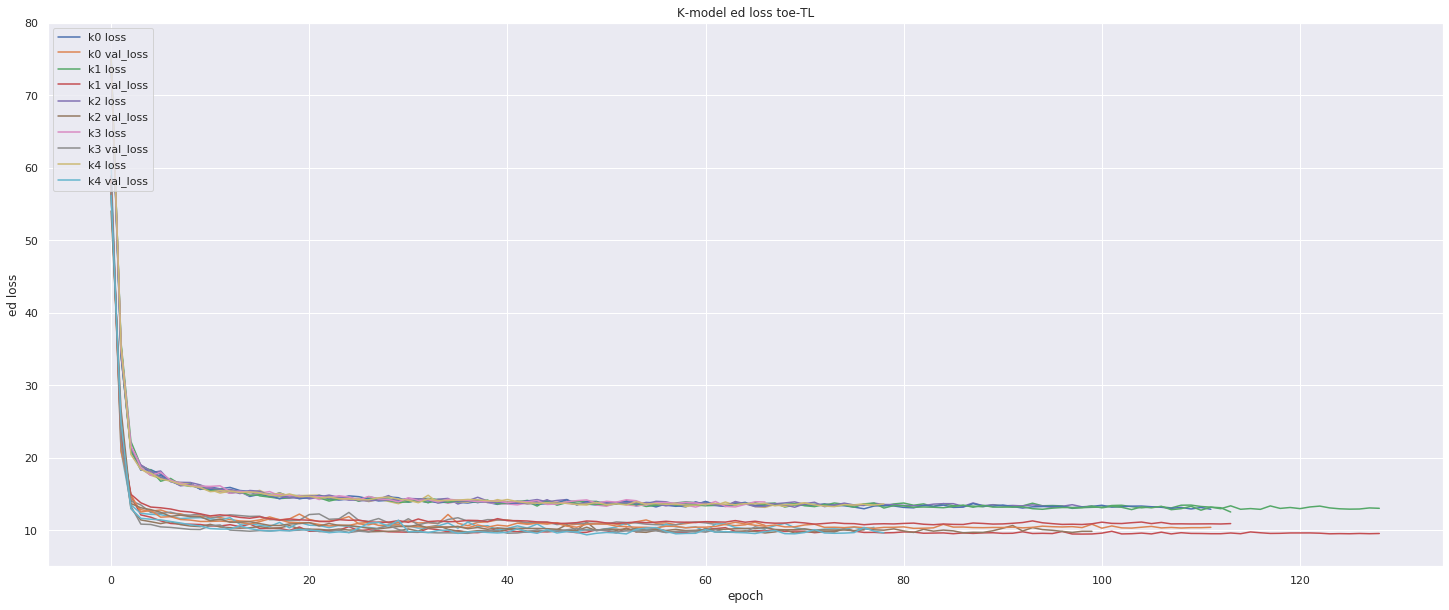

In [97]:
# Sum plot losses toe-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])

    
plt.title('K-model ed loss toe-TL')
plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_TL.png', bbox_inches = 'tight')

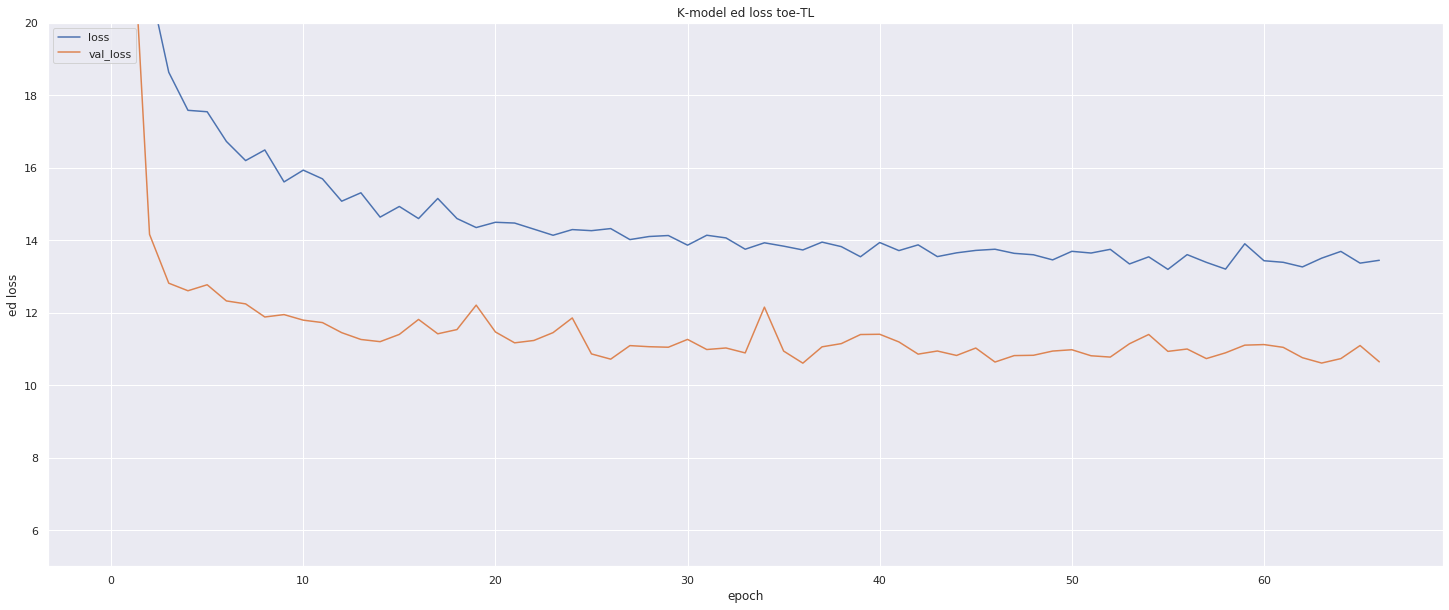

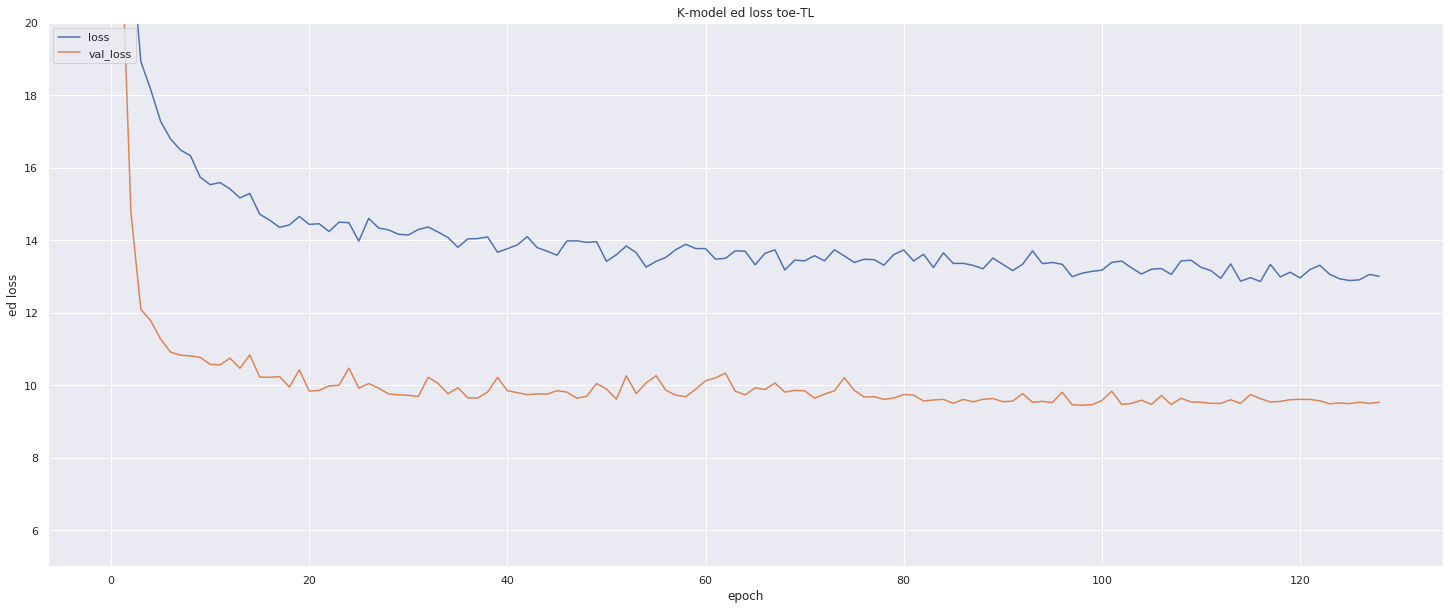

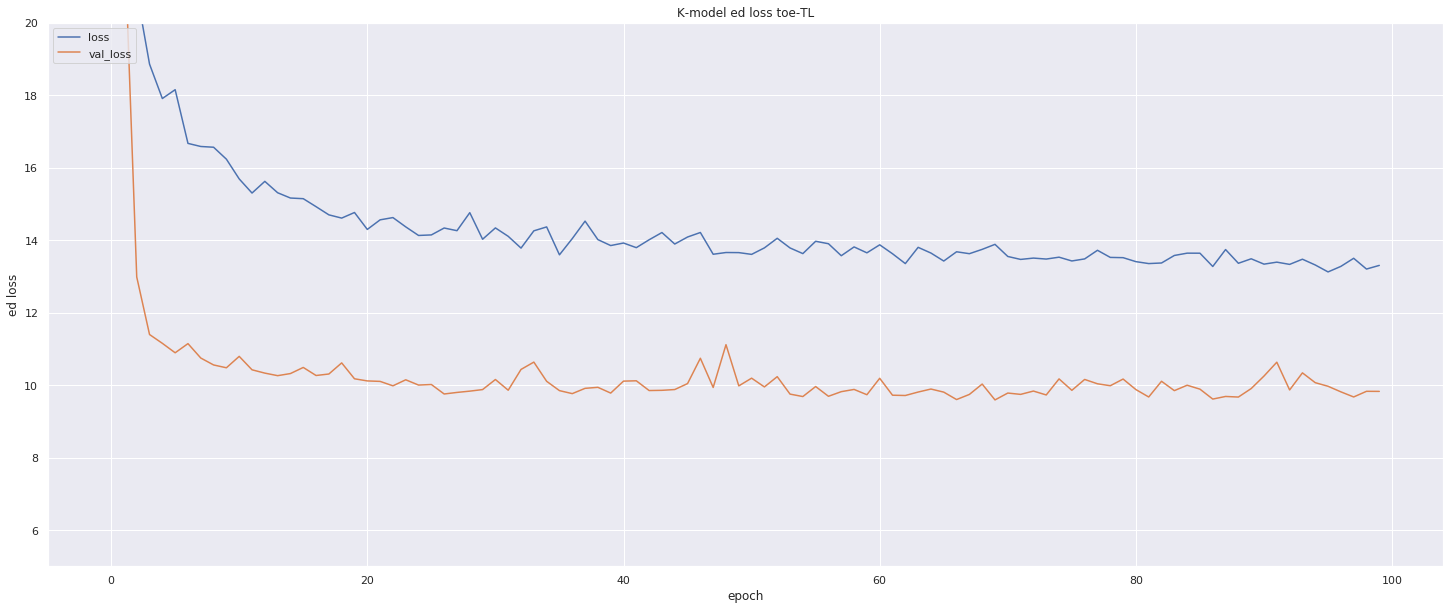

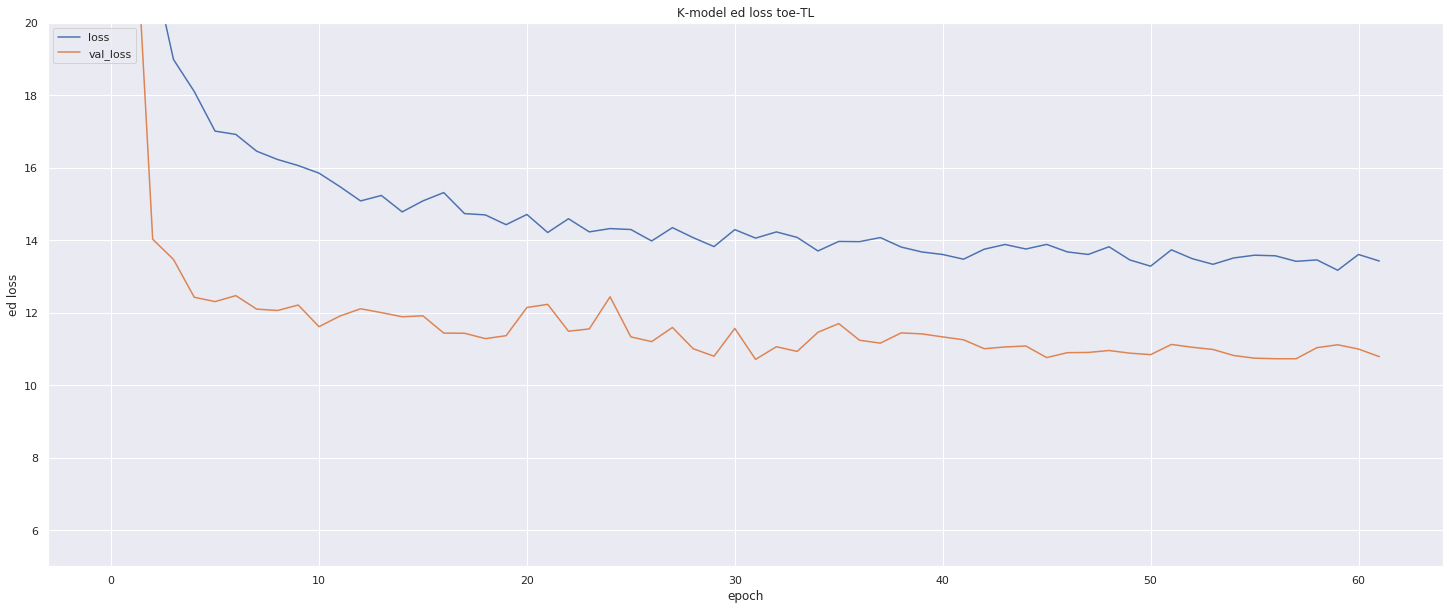

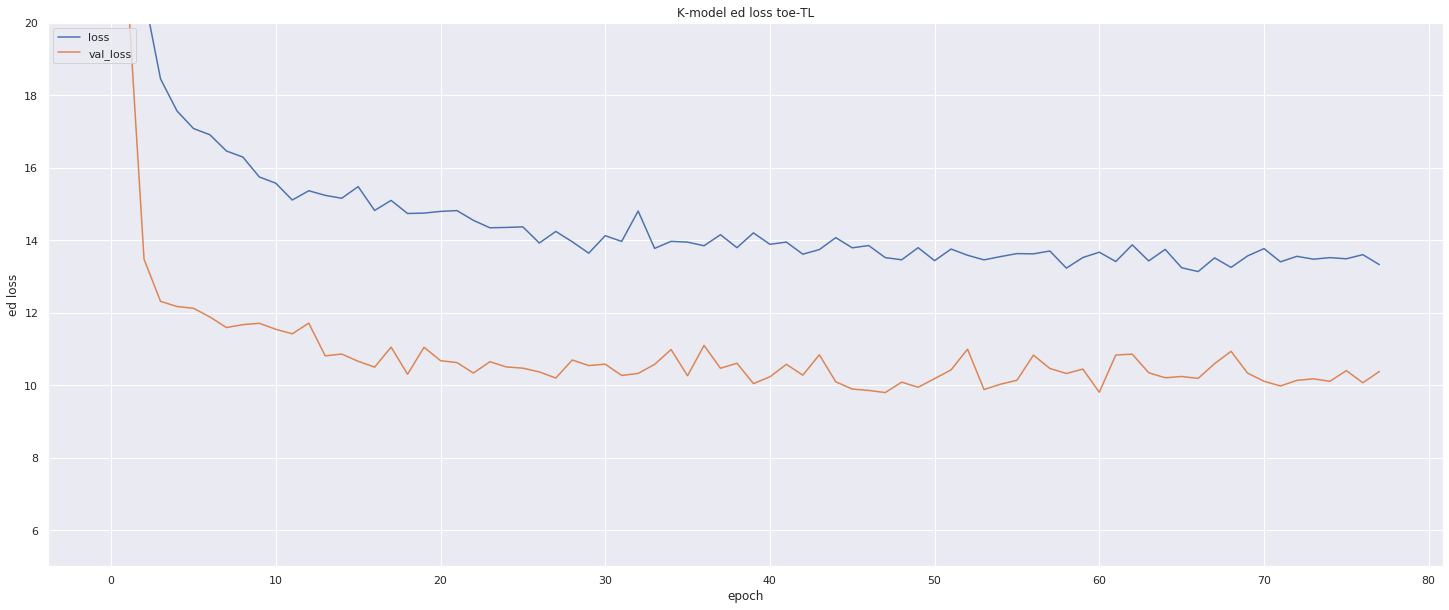

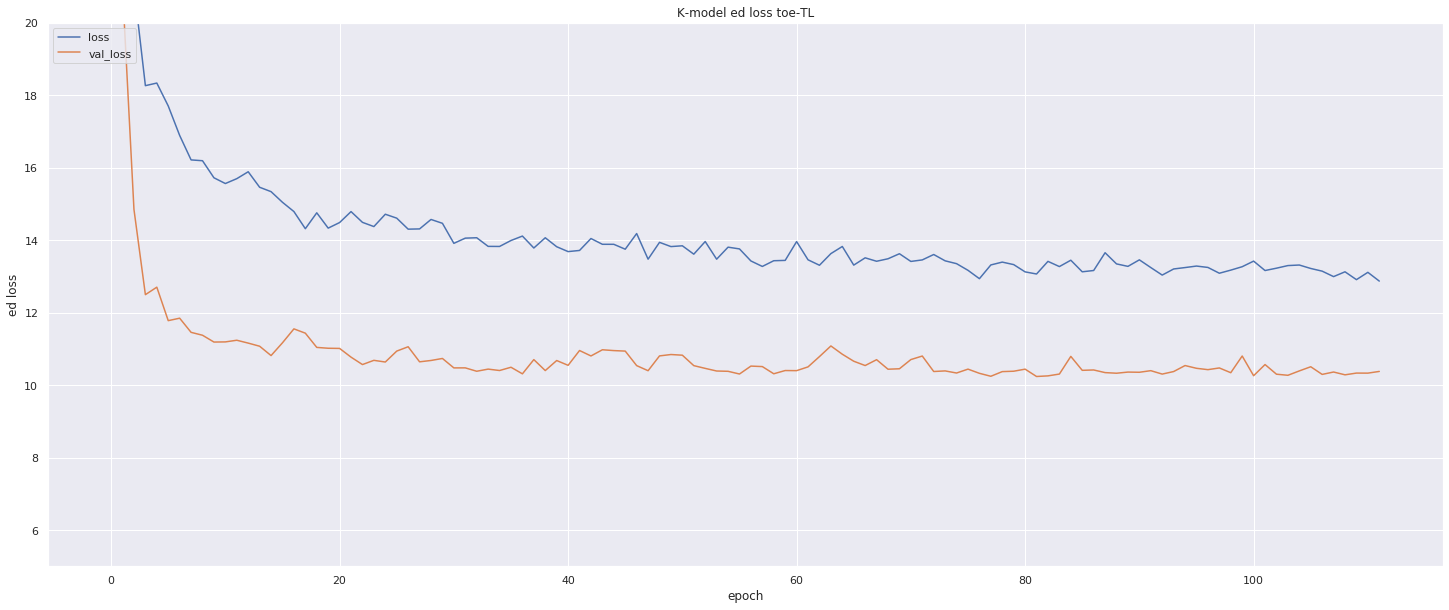

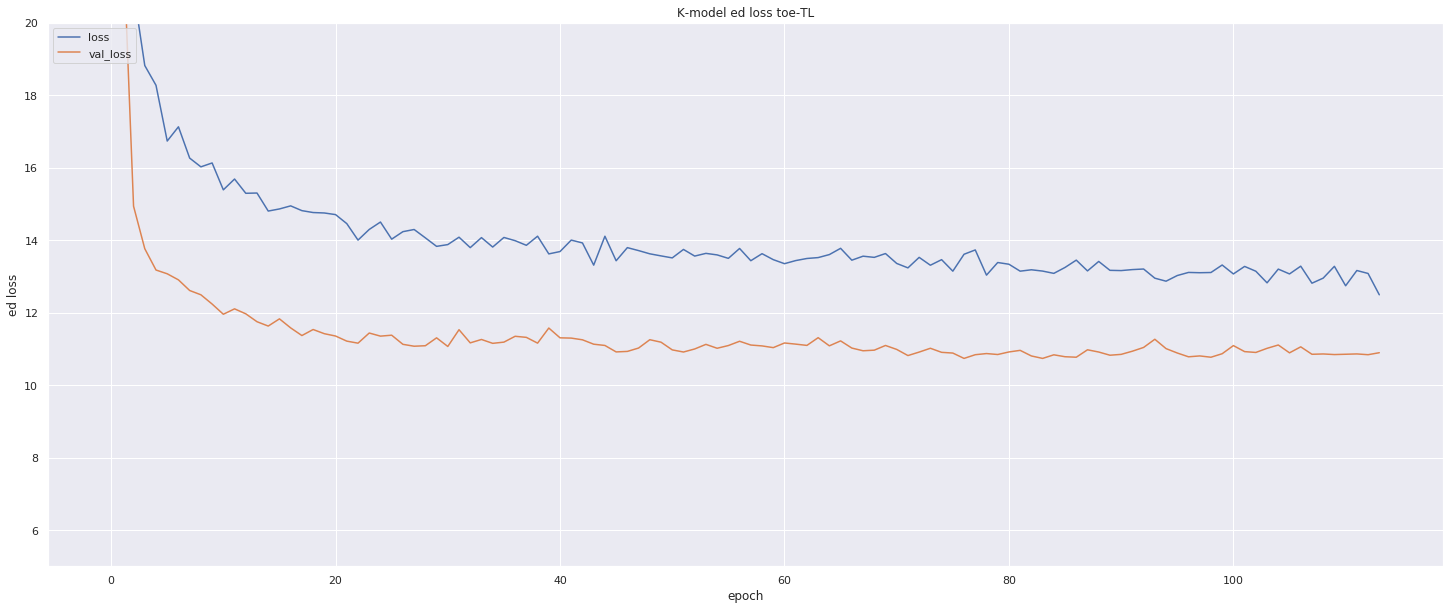

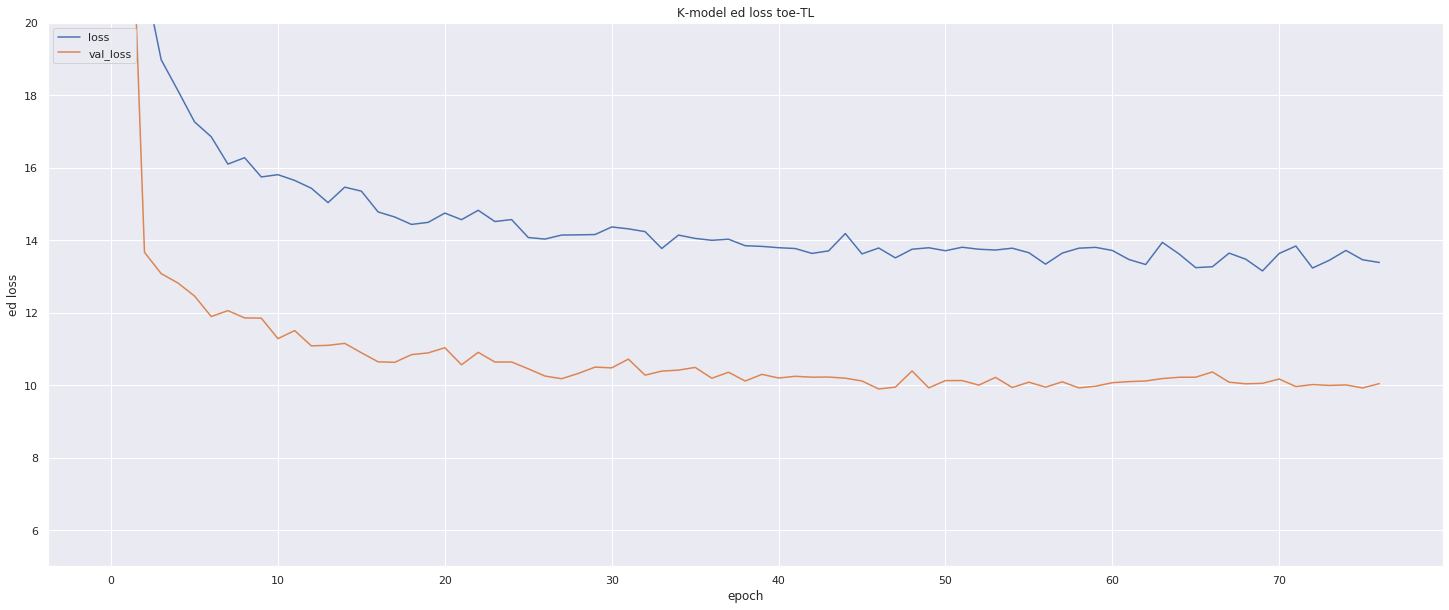

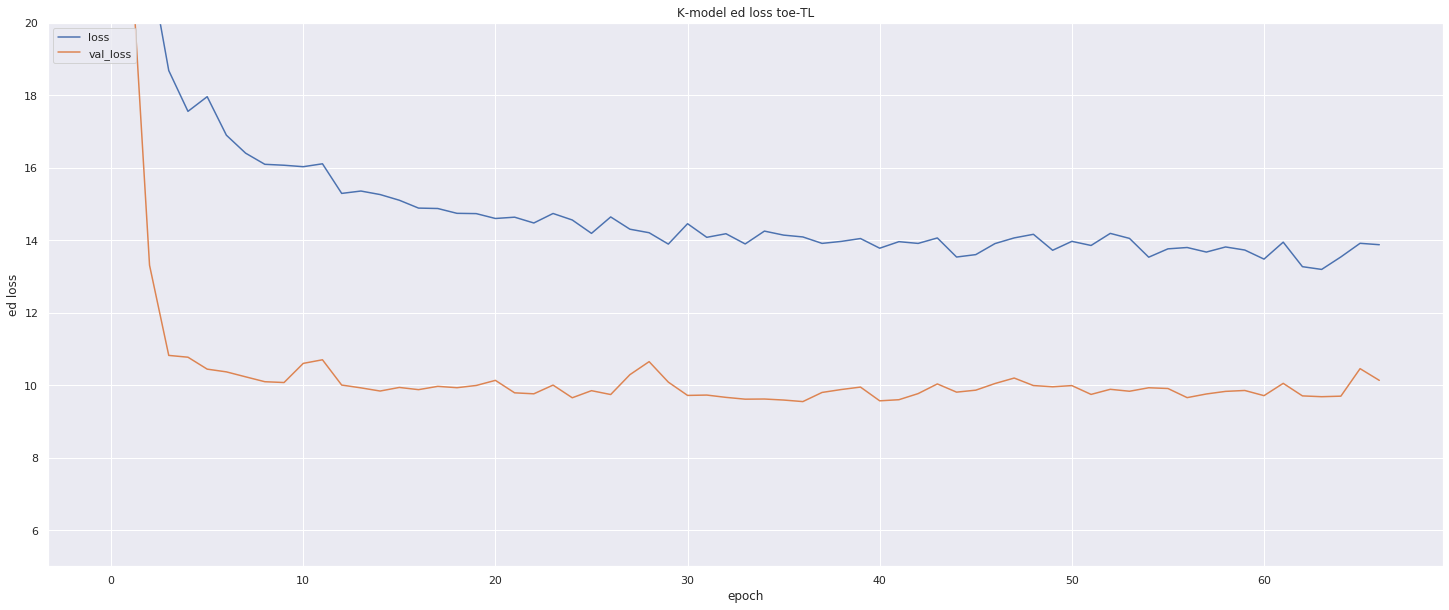

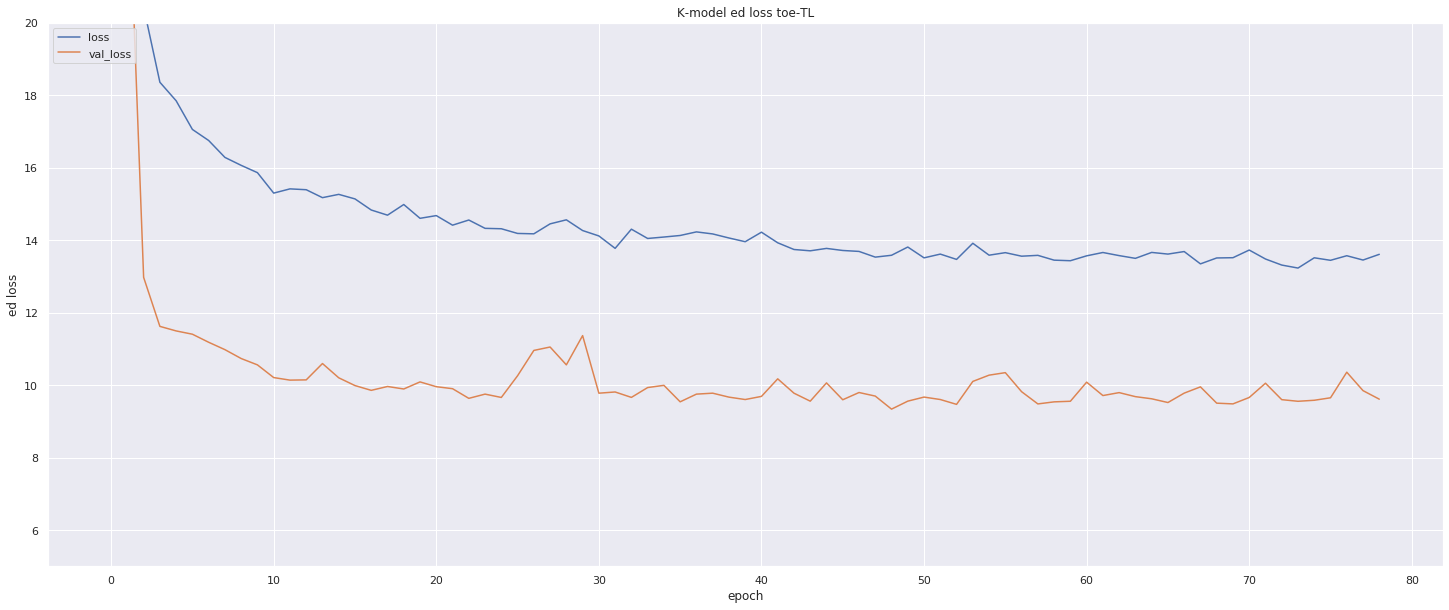

In [98]:
# Single plot loss toe-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])
    plt.title('K-model ed loss toe-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


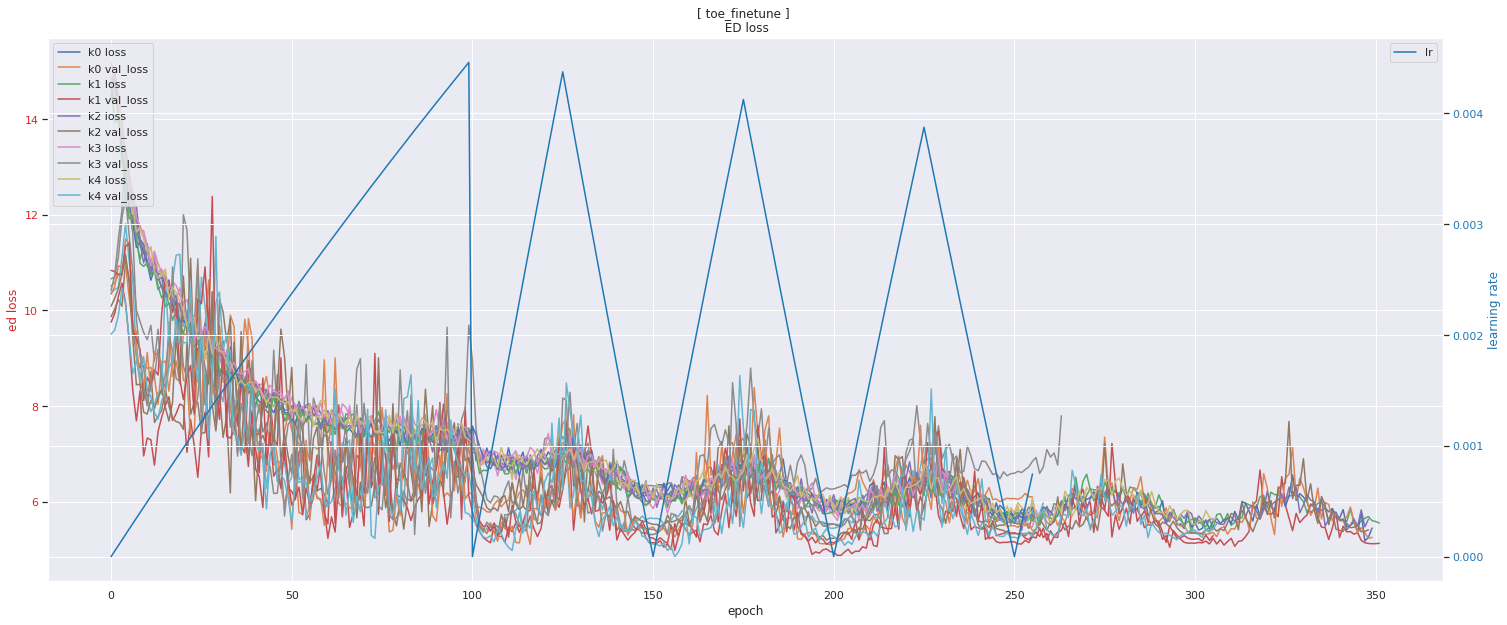

In [99]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


t_vl = np.mean(t_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_ft_Ksum-clr_ed{round(t_vl,4)}.png', bbox_inches = 'tight')

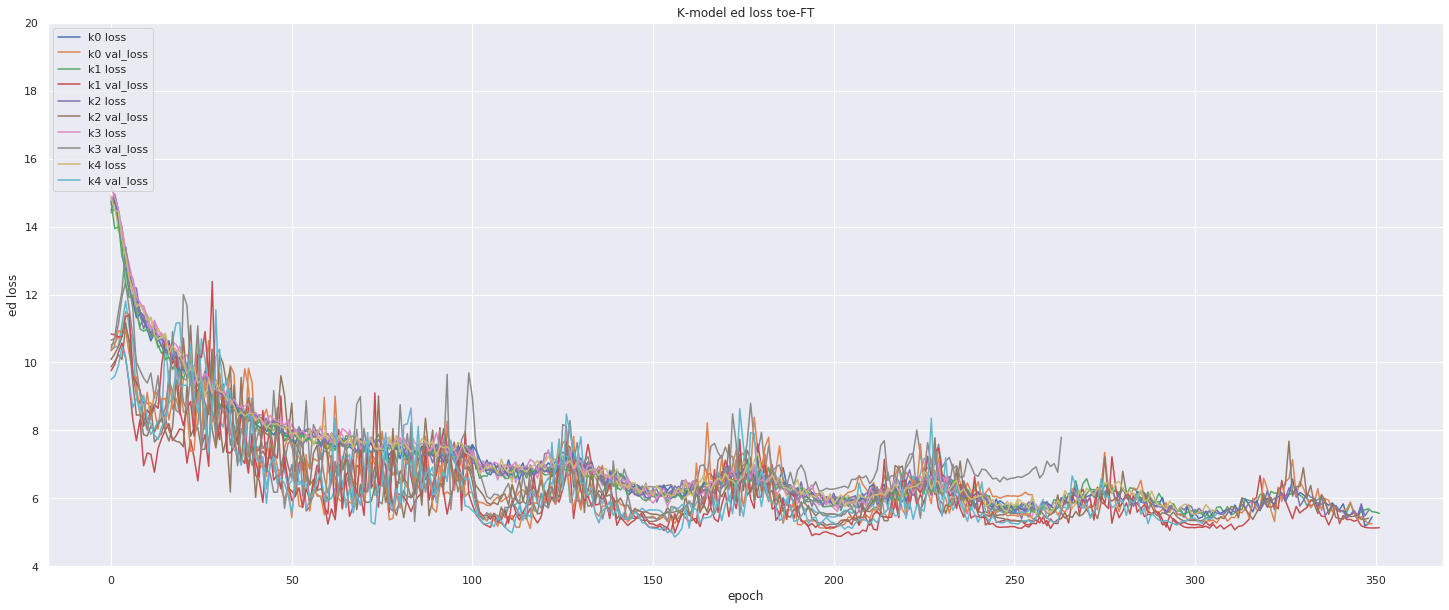

In [100]:
# Sum plot losses toe-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss toe-FT')
plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_FT.png', bbox_inches = 'tight')

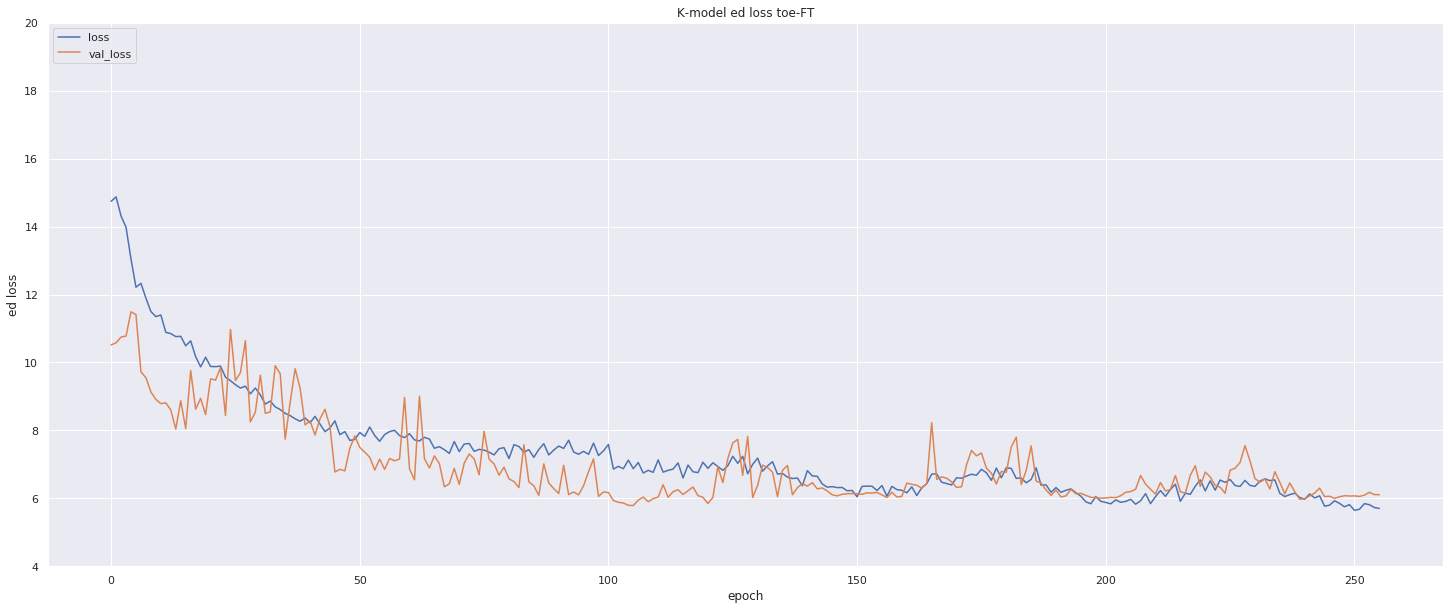

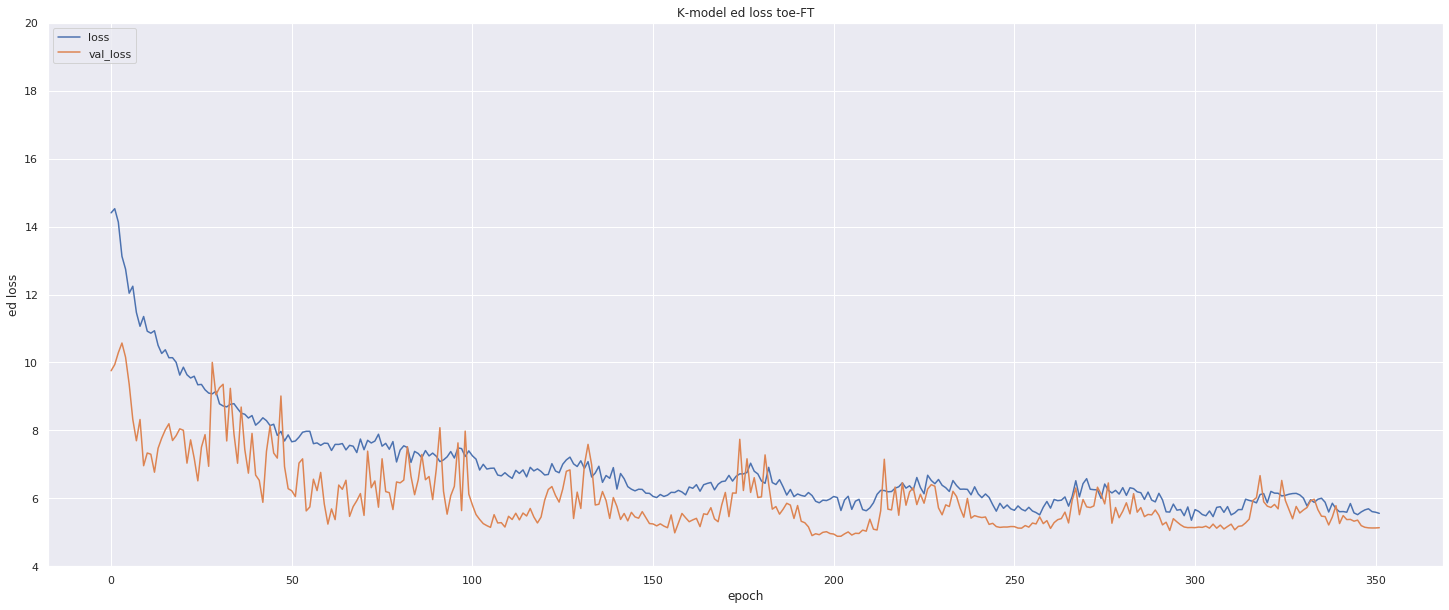

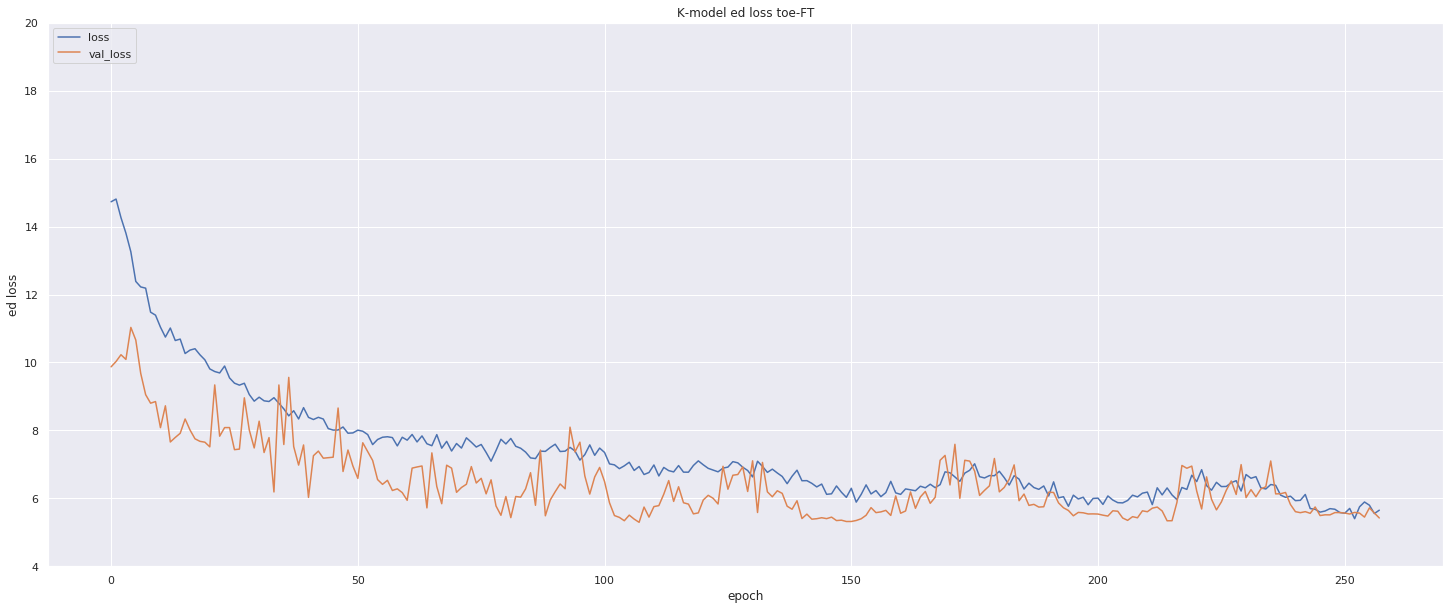

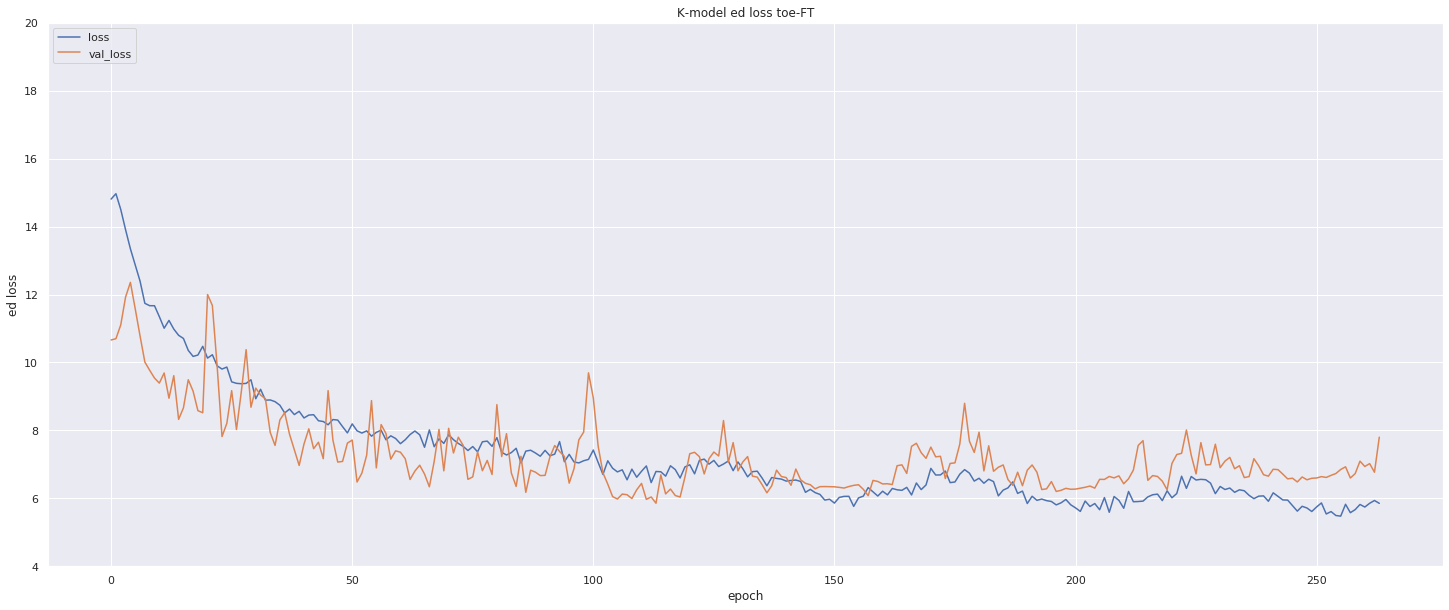

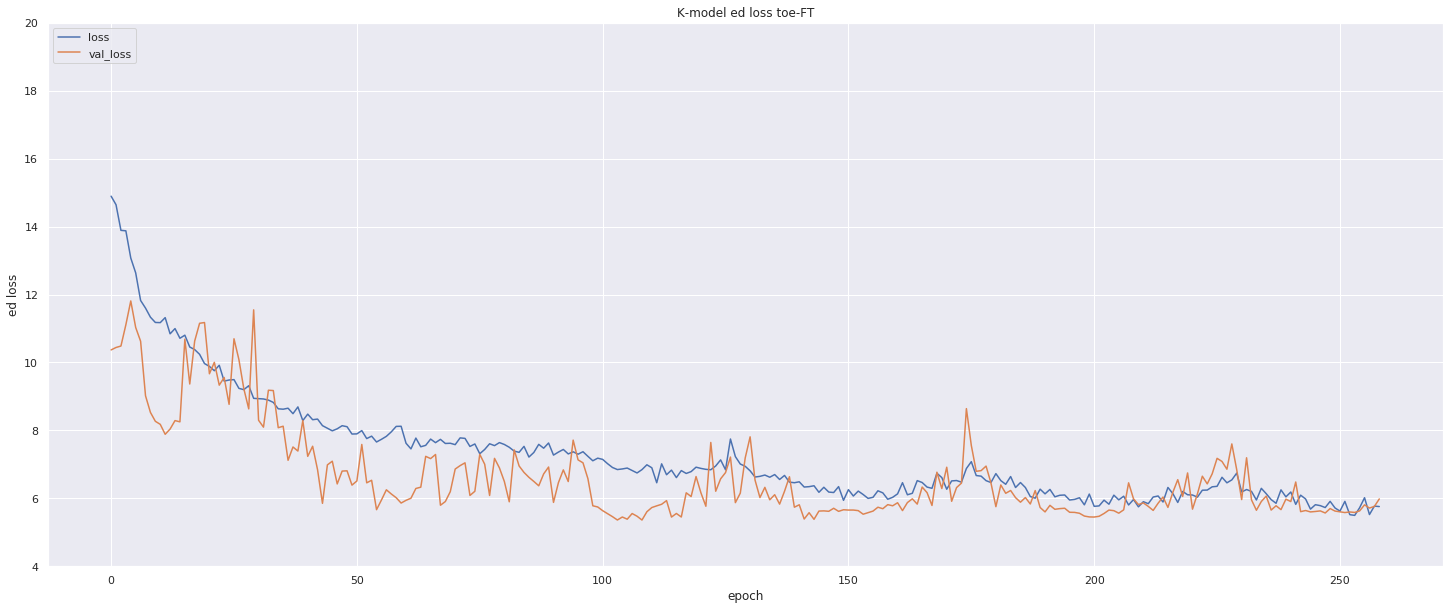

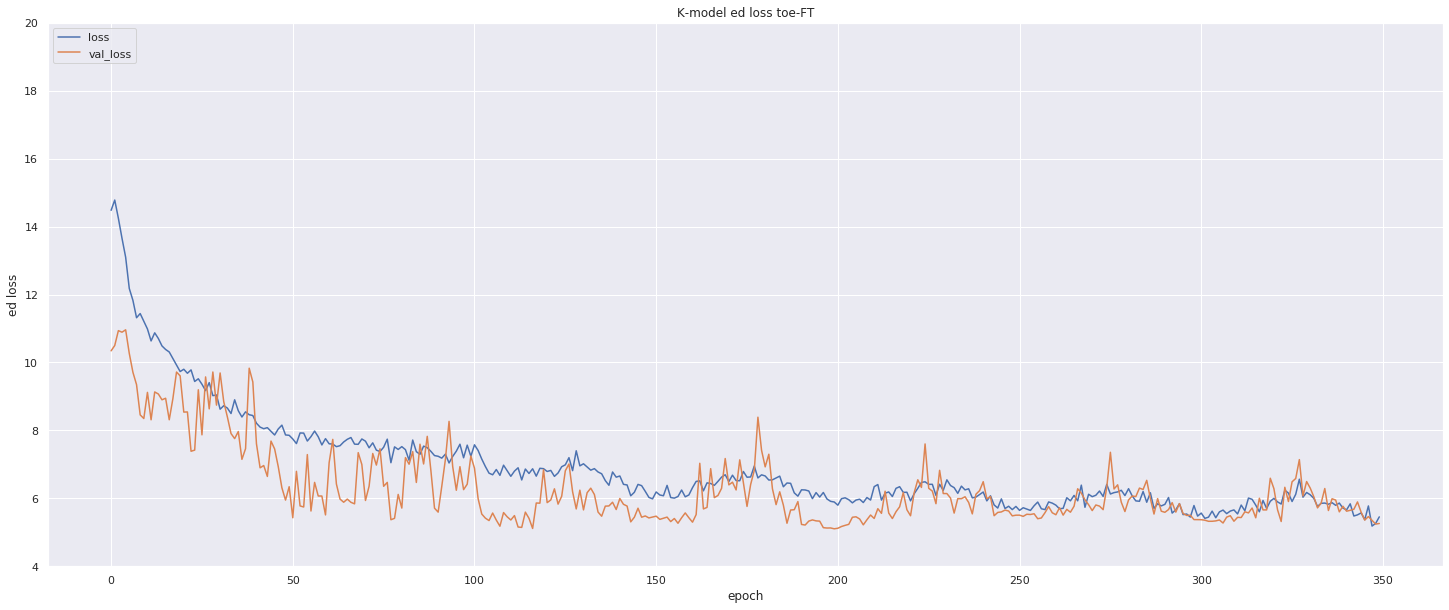

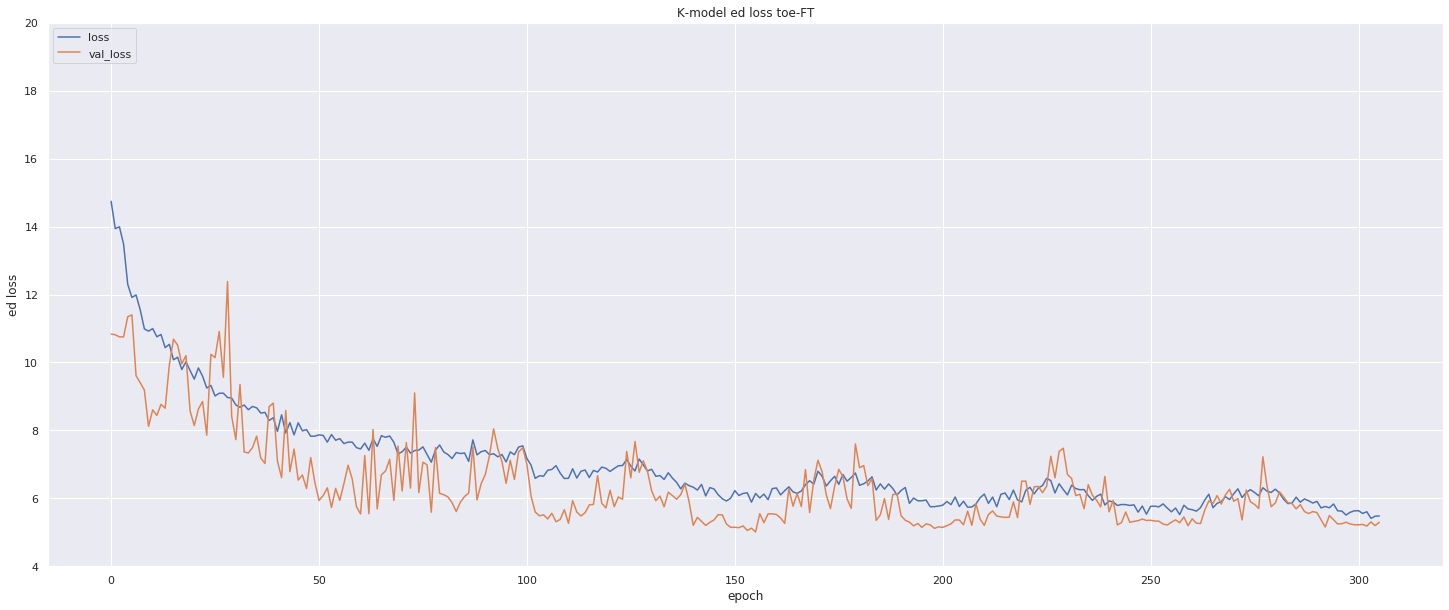

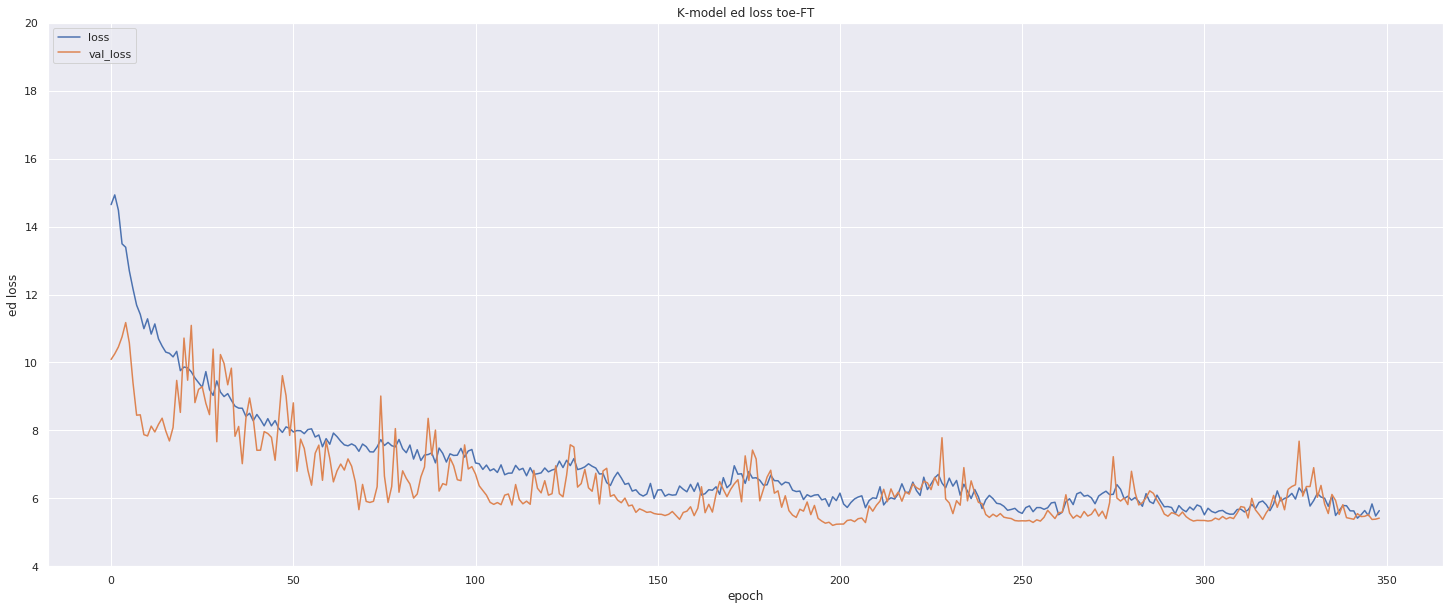

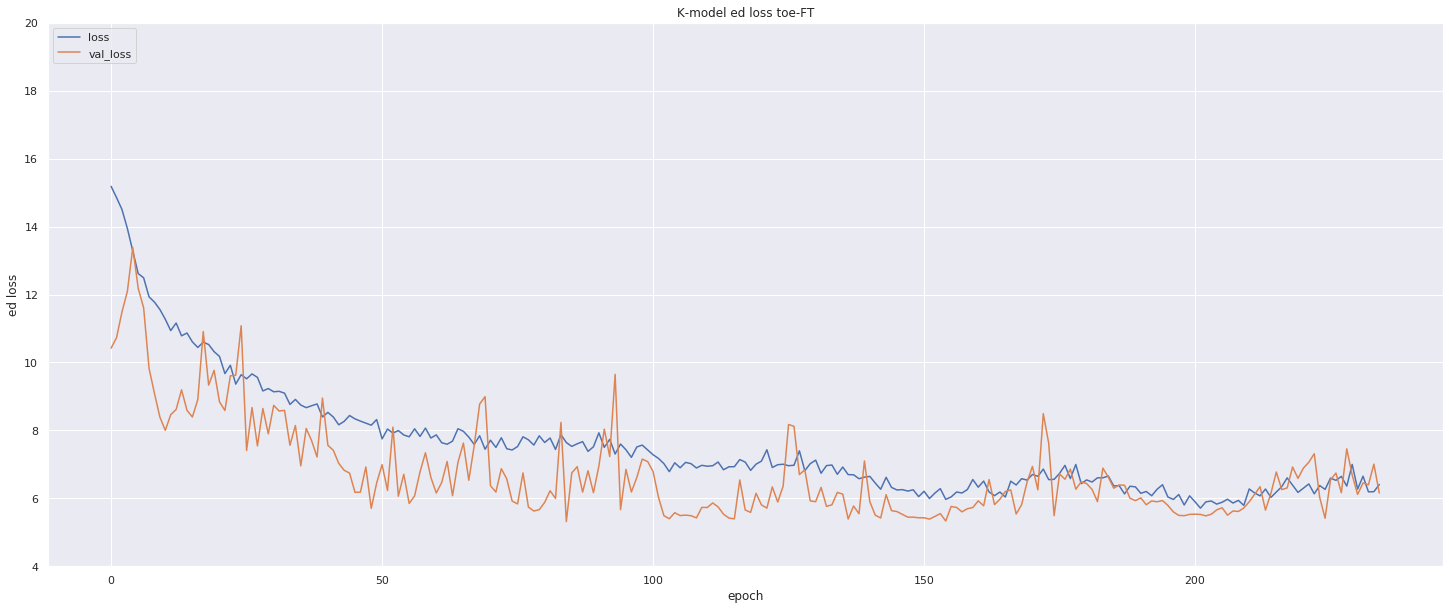

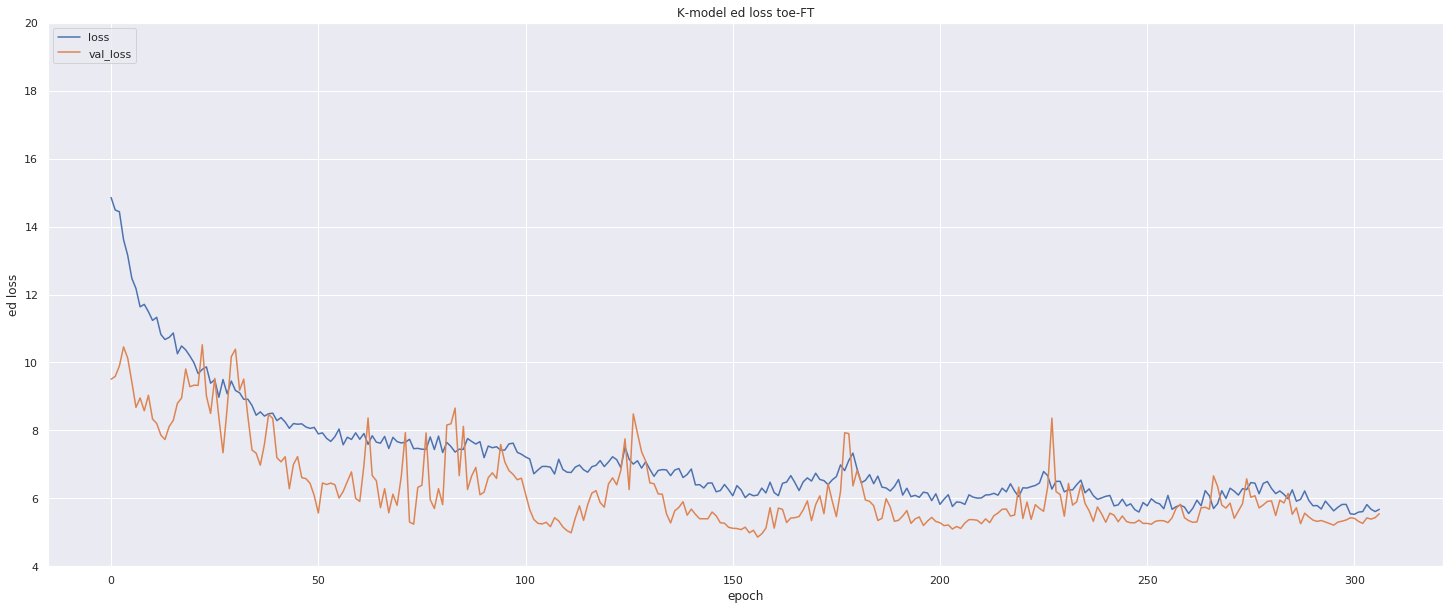

In [101]:
# Single plot loss toe-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])
    plt.title('K-model ed loss toe-FT')
    plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Heel K-model removed

In [102]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')
print(f'toe ED = {round(t_vl,5)}')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
toe ED = 5.26769


In [103]:
# K134520210224-114845.csv
# 5.63922 + 3.34466 = 8.98389 LB:8.4890610

In [104]:
t_vl

5.2676914691925045

In [105]:
# h_vl

In [106]:
t_timer.toc() #Time elapsed since t.tic()

Elapsed time is 22528.232049 seconds.
